In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_182295/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
import torch
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
#torch.manual_seed(1)
import matplotlib.pyplot as plt


In [2]:
import glob
raw_dir="/grid_mnt/data__data.polcms/cms/sghosh/TESTBEAMDATA/TBDGRAPHS/test31052023_l/"
fnamelist = [filepath for filepath in glob.glob(raw_dir+'tbd*.pt')]
data_list = []
label_list = []
tren = []
ctr = 0
import random
random.shuffle(fnamelist)
for i in tqdm(fnamelist):
    idx = torch.load(i)
    #print(type(idx))
    #idx.y = torch.sum(idx.cl2d[:,3])/idx.truen
    data_list.append(idx.rhl)
    label_list.append(idx.truen)
    if len(idx.rhl) < 28:
        print(len(idx.rhl))
    #tren.append(idx.truen)
    
    #ctr += 1
    #if ctr > 200:
    #    break

  9%|▉         | 2837/30237 [00:47<07:36, 59.99it/s] 


KeyboardInterrupt: 

In [98]:
from torch.utils.data import Dataset
class CalibDataset(Dataset):
    def __init__(self, layerens, trueens):
        self.layerens = layerens
        self.trueens = trueens
        

    def __getitem__(self, idx):
        layeren = self.layerens[idx]
        trueen = self.trueens[idx]      

        return layeren, trueen
    def __len__(self):
        return len(self.trueens)

In [100]:
totalev = len(data_list)
ntrain = int(0.8*totalev)
ntest = totalev - ntrain


ntrainbatch = 200
ntestbatch = 100
from torch.utils.data import DataLoader
full_dataset = CalibDataset(torch.stack(data_list,dim=0), torch.stack(label_list,dim=0))
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [ntrain, ntest])
trainloader = DataLoader(train_dataset, batch_size=ntrainbatch)
testloader = DataLoader(test_dataset, batch_size=ntestbatch)

In [101]:
class Model(torch.nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        
        super().__init__()
        # initialize weights with random numbers
        #weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        weights = torch.ones(size=(28,),requires_grad=True,dtype=torch.float)
        # make weights torch parameters
        self.weights = torch.nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        #a, k, b = self.weights
        #return a * torch.exp(-k * X) + b
        batch_size = X.shape[0]
        output = X*self.weights.repeat(batch_size,1)
        return torch.sum(output,dim=-1)

In [102]:
def scaleloss(inputt):
    #tote = torch.matmul(inputt,calibfacs)
    loss = torch.nn.L1Loss()
    #tote=inputt
    #print(tote.shape,tden.shape)
    #loss1 = torch.nn.functional.mse_loss(tote, tden, reduction='mean')
    loss1 = loss(tote, tden)
    #loss1 = torch.sum(((tote-tden)/tden)**2)/len(tote)
    return loss1

def resoloss(inputt):
    allietas = torch.tensor(np.unique(tieta))
    sumt = torch.sum(inputt/tden,dim=1)
    sumt = sumt.view((sumt.shape[0],1))
    sums = 0
    for i in allietas:
        #sumt[tieta == i]
        sums += torch.var(sumt[tieta == i])
        
    return sums/len(allietas)
    
def totalloss(inputt):
    lossc = scaleloss(inputt)
    lossr = resoloss(inputt)
    return lossc,lossr


In [111]:
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

lossdef = torch.nn.MSELoss()
lossc,lossr = [],[]
epochs = []
opt = torch.optim.Adam(model.parameters(), lr=0.001)
#opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=1e-1)#, nesterov=True)

def train(epoch):
    model.train()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            optimizer.zero_grad()
            result = model(data[0])
            lossc = lossdef(result, data[1])
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))



def evaluate(epoch):
    model.eval()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    pred = []
    true = []
    calc = []
    for data in tqdm(testloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            #print(data[0])
            optimizer.zero_grad()
            result = model(data[0])
            #print(result)
            lossc = lossdef(result, data[1])
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
            for i in result:
                pred.append(i.detach().cpu())
                #predc.append(i.detach().cpu().argmax())
            for i in data[1].detach():
                true.append(i.detach().cpu())
            for i in data[0].detach():
                calc.append(torch.sum(i.detach().cpu()))    
            
    from matplotlib.pyplot import figure
    figure(figsize=(15, 15), dpi=40)
    #plt.rcParams['axes.labelsize'] = 36
    #plt.rcParams['axes.titlesize'] = 36
    #plt.hist2d(truea,preda,bins=200)
    #plt.scatter(truea,preda,alpha=0.4)
    #plt.scatter(truea,preda,alpha=0.4)
    
    plt.hist(np.array(pred)/np.array(true),bins=100,range=[0.75,1.25],label='pred')
    plt.hist(np.array(calc)/np.array(true),bins=100,range=[0.75,1.25],label='calc')
    #plt.plot([0,2], [0,2], 'k-')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.xlim([-2, 18])
    #plt.ylim([-2, 20])
    plt.axvline(x=1.0,c='r')
    #plt.axhline(y=1.0,c='r')
    plt.legend()
    plt.show()
    
    
    print( 'batches for test:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print("calib weights:",model.weights)
    return np.mean(np.array(loss))




epoch: 0


100%|██████████| 121/121 [00:00<00:00, 311.94it/s]


batches for train: 121
train loss: 48.175373802500324


100%|██████████| 61/61 [00:00<00:00, 137.68it/s]


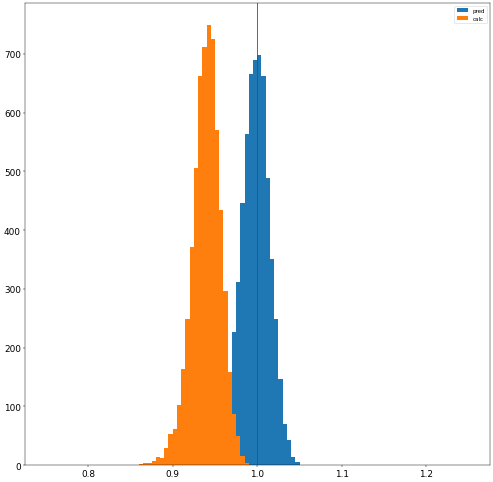

batches for test: 61
test loss: 14.119916931527559
calib weights: Parameter containing:
tensor([1.0636, 1.0636, 1.0630, 1.0624, 1.0618, 1.0613, 1.0608, 1.0606, 1.0603,
        1.0600, 1.0599, 1.0600, 1.0602, 1.0604, 1.0606, 1.0610, 1.0611, 1.0617,
        1.0621, 1.0622, 1.0624, 1.0634, 1.0638, 1.0646, 1.0643, 1.0653, 1.0652,
        1.0670], device='cuda:1', requires_grad=True)
new best test loss: 14.119916931527559
epoch: 1


100%|██████████| 121/121 [00:00<00:00, 448.51it/s]


batches for train: 121
train loss: 13.664126672035406


100%|██████████| 61/61 [00:00<00:00, 143.27it/s]


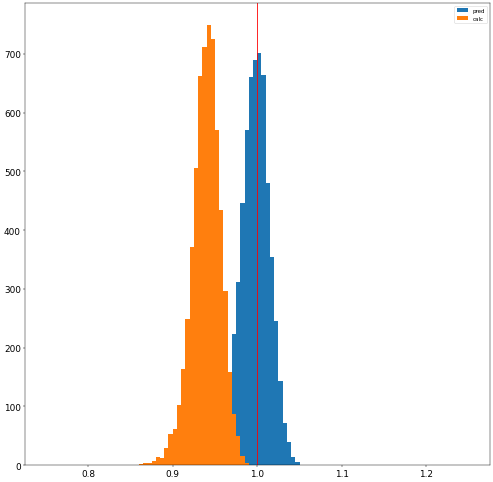

batches for test: 61
test loss: 14.085390309818456
calib weights: Parameter containing:
tensor([1.0714, 1.0703, 1.0683, 1.0660, 1.0640, 1.0624, 1.0607, 1.0599, 1.0588,
        1.0583, 1.0579, 1.0583, 1.0588, 1.0595, 1.0602, 1.0615, 1.0621, 1.0636,
        1.0645, 1.0655, 1.0655, 1.0678, 1.0688, 1.0718, 1.0709, 1.0736, 1.0731,
        1.0796], device='cuda:1', requires_grad=True)
new best test loss: 14.085390309818456
epoch: 2


100%|██████████| 121/121 [00:00<00:00, 507.19it/s]


batches for train: 121
train loss: 13.63132313657398


100%|██████████| 61/61 [00:00<00:00, 155.39it/s]


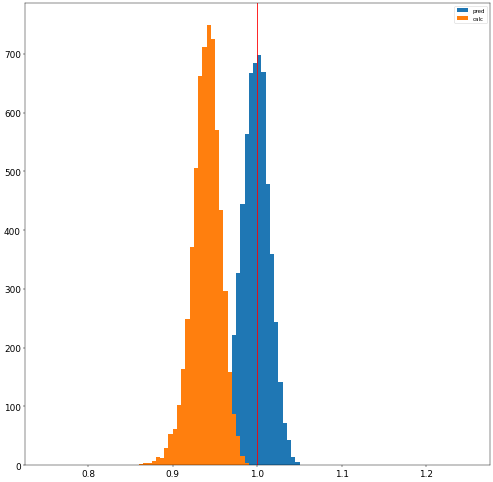

batches for test: 61
test loss: 14.046619321479172
calib weights: Parameter containing:
tensor([1.0810, 1.0787, 1.0749, 1.0705, 1.0669, 1.0639, 1.0607, 1.0591, 1.0572,
        1.0563, 1.0555, 1.0563, 1.0572, 1.0584, 1.0597, 1.0621, 1.0632, 1.0659,
        1.0674, 1.0694, 1.0689, 1.0728, 1.0743, 1.0800, 1.0783, 1.0833, 1.0821,
        1.0948], device='cuda:1', requires_grad=True)
new best test loss: 14.046619321479172
epoch: 3


100%|██████████| 121/121 [00:00<00:00, 449.77it/s]


batches for train: 121
train loss: 13.598862892340037


100%|██████████| 61/61 [00:00<00:00, 138.50it/s]


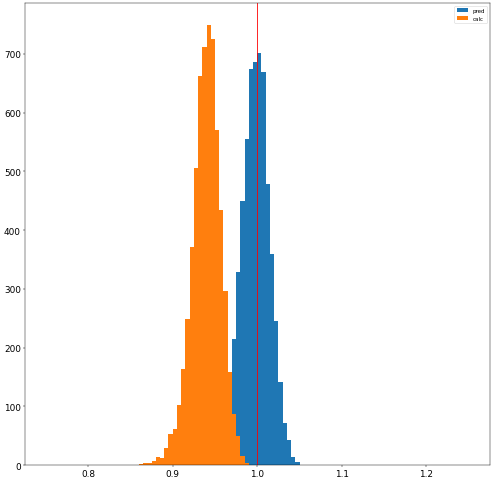

batches for test: 61
test loss: 14.010231956106718
calib weights: Parameter containing:
tensor([1.0915, 1.0879, 1.0822, 1.0755, 1.0701, 1.0656, 1.0608, 1.0585, 1.0556,
        1.0543, 1.0530, 1.0542, 1.0555, 1.0573, 1.0591, 1.0627, 1.0643, 1.0684,
        1.0702, 1.0734, 1.0720, 1.0777, 1.0794, 1.0884, 1.0856, 1.0934, 1.0910,
        1.1112], device='cuda:1', requires_grad=True)
new best test loss: 14.010231956106718
epoch: 4


100%|██████████| 121/121 [00:00<00:00, 521.21it/s]


batches for train: 121
train loss: 13.57094143638926


100%|██████████| 61/61 [00:00<00:00, 155.60it/s]


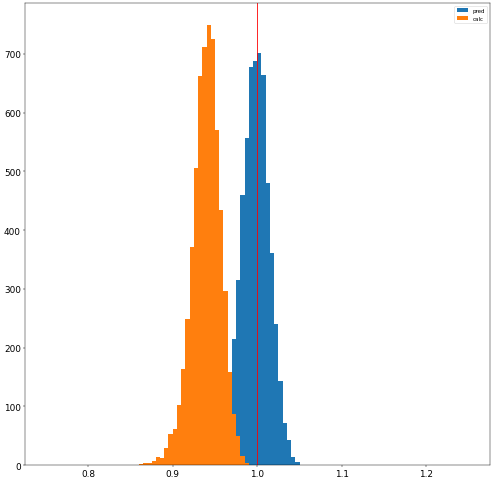

batches for test: 61
test loss: 13.979500598594791
calib weights: Parameter containing:
tensor([1.1021, 1.0972, 1.0895, 1.0805, 1.0733, 1.0673, 1.0609, 1.0580, 1.0540,
        1.0524, 1.0505, 1.0521, 1.0538, 1.0562, 1.0586, 1.0634, 1.0654, 1.0709,
        1.0731, 1.0773, 1.0746, 1.0821, 1.0836, 1.0964, 1.0921, 1.1031, 1.0993,
        1.1281], device='cuda:1', requires_grad=True)
new best test loss: 13.979500598594791
epoch: 5


100%|██████████| 121/121 [00:00<00:00, 422.36it/s]


batches for train: 121
train loss: 13.549333982231204


100%|██████████| 61/61 [00:00<00:00, 140.06it/s]


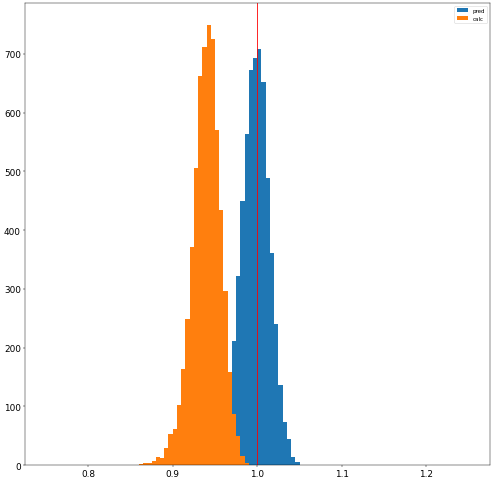

batches for test: 61
test loss: 13.95547185178663
calib weights: Parameter containing:
tensor([1.1123, 1.1062, 1.0966, 1.0852, 1.0762, 1.0690, 1.0610, 1.0575, 1.0526,
        1.0506, 1.0482, 1.0503, 1.0524, 1.0553, 1.0581, 1.0642, 1.0665, 1.0734,
        1.0758, 1.0811, 1.0765, 1.0859, 1.0867, 1.1038, 1.0975, 1.1122, 1.1066,
        1.1452], device='cuda:1', requires_grad=True)
new best test loss: 13.95547185178663
epoch: 6


100%|██████████| 121/121 [00:00<00:00, 526.79it/s]


batches for train: 121
train loss: 13.53411200814996


100%|██████████| 61/61 [00:00<00:00, 155.38it/s]


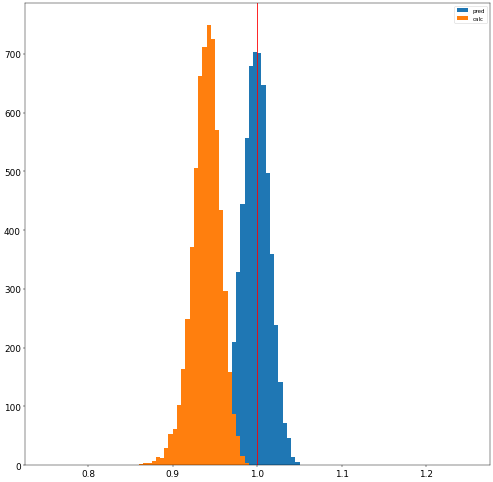

batches for test: 61
test loss: 13.937800641919745
calib weights: Parameter containing:
tensor([1.1217, 1.1144, 1.1031, 1.0895, 1.0788, 1.0705, 1.0609, 1.0572, 1.0513,
        1.0491, 1.0461, 1.0487, 1.0511, 1.0545, 1.0578, 1.0652, 1.0676, 1.0758,
        1.0784, 1.0846, 1.0777, 1.0888, 1.0883, 1.1102, 1.1017, 1.1204, 1.1126,
        1.1621], device='cuda:1', requires_grad=True)
new best test loss: 13.937800641919745
epoch: 7


100%|██████████| 121/121 [00:00<00:00, 505.06it/s]


batches for train: 121
train loss: 13.524288161727023


100%|██████████| 61/61 [00:00<00:00, 155.74it/s]


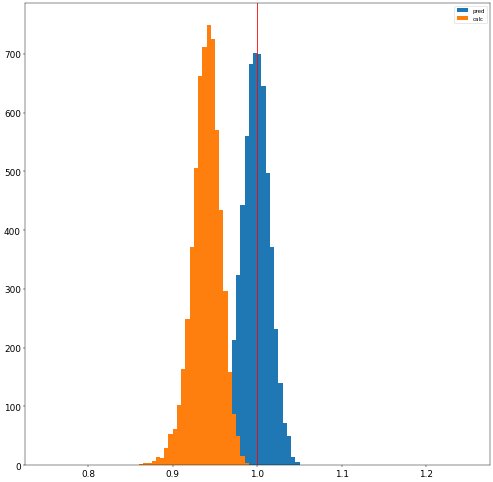

batches for test: 61
test loss: 13.92542432566158
calib weights: Parameter containing:
tensor([1.1300, 1.1216, 1.1089, 1.0930, 1.0810, 1.0717, 1.0608, 1.0570, 1.0501,
        1.0478, 1.0441, 1.0473, 1.0502, 1.0540, 1.0576, 1.0662, 1.0687, 1.0782,
        1.0807, 1.0878, 1.0781, 1.0907, 1.0886, 1.1156, 1.1044, 1.1276, 1.1174,
        1.1787], device='cuda:1', requires_grad=True)
new best test loss: 13.92542432566158
epoch: 8


100%|██████████| 121/121 [00:00<00:00, 459.41it/s]


batches for train: 121
train loss: 13.51841794951888


100%|██████████| 61/61 [00:00<00:00, 142.55it/s]


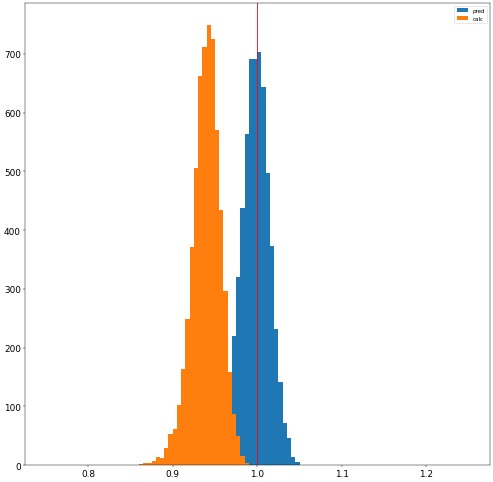

batches for test: 61
test loss: 13.917061305436931
calib weights: Parameter containing:
tensor([1.1373, 1.1279, 1.1139, 1.0960, 1.0827, 1.0728, 1.0606, 1.0569, 1.0491,
        1.0468, 1.0425, 1.0463, 1.0494, 1.0536, 1.0575, 1.0673, 1.0696, 1.0805,
        1.0827, 1.0906, 1.0776, 1.0918, 1.0874, 1.1201, 1.1057, 1.1338, 1.1208,
        1.1951], device='cuda:1', requires_grad=True)
new best test loss: 13.917061305436931
epoch: 9


100%|██████████| 121/121 [00:00<00:00, 490.64it/s]


batches for train: 121
train loss: 13.51505881695708


100%|██████████| 61/61 [00:00<00:00, 149.71it/s]


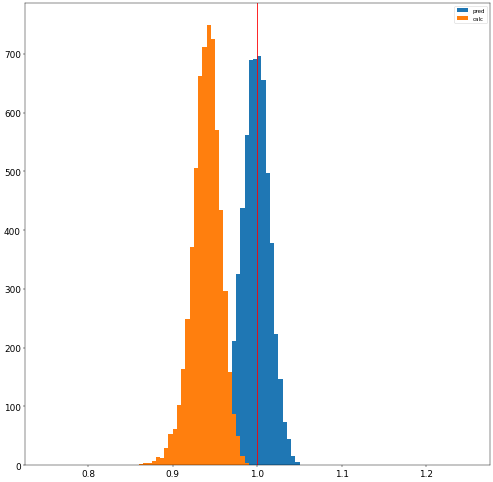

batches for test: 61
test loss: 13.911557697858967
calib weights: Parameter containing:
tensor([1.1434, 1.1332, 1.1182, 1.0982, 1.0839, 1.0735, 1.0602, 1.0569, 1.0483,
        1.0461, 1.0410, 1.0455, 1.0489, 1.0534, 1.0574, 1.0684, 1.0705, 1.0827,
        1.0845, 1.0932, 1.0763, 1.0920, 1.0849, 1.1236, 1.1058, 1.1392, 1.1231,
        1.2114], device='cuda:1', requires_grad=True)
new best test loss: 13.911557697858967


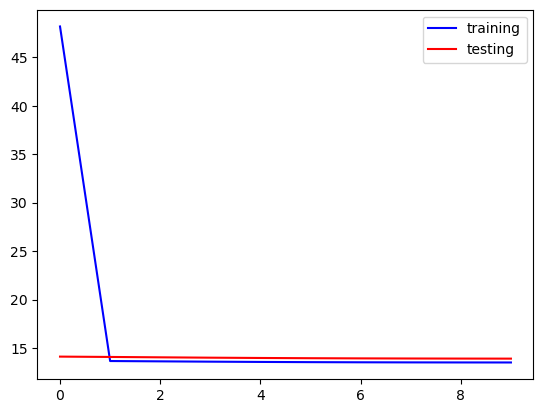

epoch: 10


100%|██████████| 121/121 [00:00<00:00, 486.98it/s]


batches for train: 121
train loss: 13.5130528694342


100%|██████████| 61/61 [00:00<00:00, 144.86it/s]


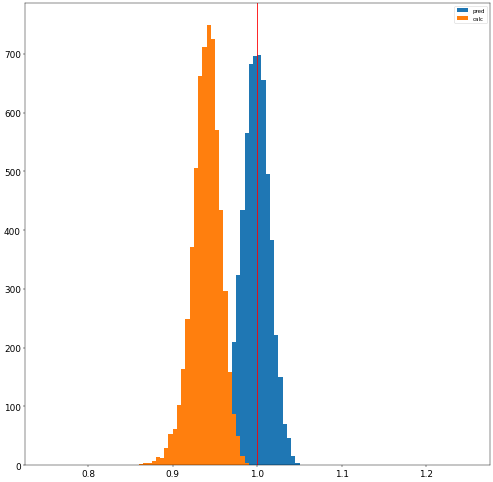

batches for test: 61
test loss: 13.908031979545218
calib weights: Parameter containing:
tensor([1.1485, 1.1376, 1.1217, 1.0999, 1.0847, 1.0741, 1.0597, 1.0570, 1.0476,
        1.0455, 1.0396, 1.0448, 1.0486, 1.0533, 1.0574, 1.0696, 1.0713, 1.0848,
        1.0860, 1.0954, 1.0743, 1.0914, 1.0813, 1.1264, 1.1049, 1.1440, 1.1244,
        1.2278], device='cuda:1', requires_grad=True)
new best test loss: 13.908031979545218
epoch: 11


100%|██████████| 121/121 [00:00<00:00, 520.76it/s]


batches for train: 121
train loss: 13.511599658934538


100%|██████████| 61/61 [00:00<00:00, 154.70it/s]


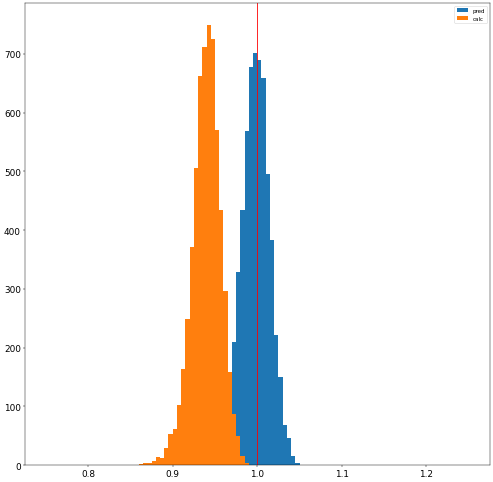

batches for test: 61
test loss: 13.905870234380004
calib weights: Parameter containing:
tensor([1.1528, 1.1413, 1.1247, 1.1011, 1.0852, 1.0745, 1.0592, 1.0572, 1.0470,
        1.0451, 1.0384, 1.0444, 1.0483, 1.0533, 1.0574, 1.0708, 1.0720, 1.0868,
        1.0874, 1.0975, 1.0717, 1.0903, 1.0769, 1.1287, 1.1032, 1.1483, 1.1251,
        1.2446], device='cuda:1', requires_grad=True)
new best test loss: 13.905870234380004
epoch: 12


100%|██████████| 121/121 [00:00<00:00, 441.99it/s]


batches for train: 121
train loss: 13.510219526684974


100%|██████████| 61/61 [00:00<00:00, 96.89it/s] 


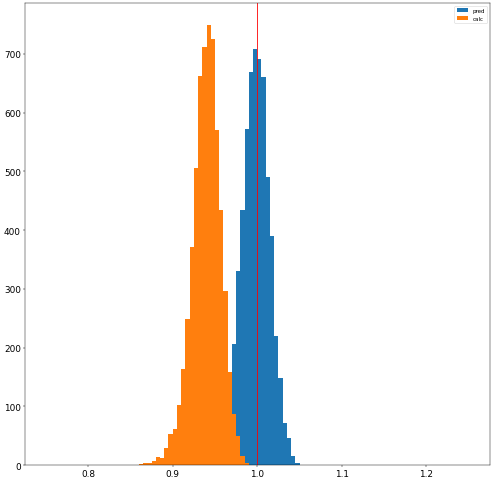

batches for test: 61
test loss: 13.904665696816366
calib weights: Parameter containing:
tensor([1.1563, 1.1443, 1.1272, 1.1019, 1.0854, 1.0748, 1.0586, 1.0575, 1.0465,
        1.0449, 1.0373, 1.0440, 1.0482, 1.0533, 1.0574, 1.0720, 1.0726, 1.0887,
        1.0886, 1.0995, 1.0687, 1.0887, 1.0717, 1.1306, 1.1009, 1.1525, 1.1253,
        1.2618], device='cuda:1', requires_grad=True)
new best test loss: 13.904665696816366
epoch: 13


100%|██████████| 121/121 [00:00<00:00, 509.51it/s]


batches for train: 121
train loss: 13.508676907247748


100%|██████████| 61/61 [00:00<00:00, 158.23it/s]


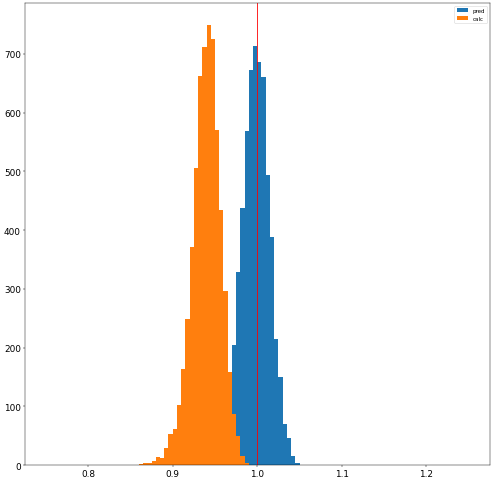

batches for test: 61
test loss: 13.904139409299757
calib weights: Parameter containing:
tensor([1.1593, 1.1468, 1.1294, 1.1024, 1.0854, 1.0751, 1.0580, 1.0579, 1.0462,
        1.0448, 1.0363, 1.0438, 1.0482, 1.0534, 1.0574, 1.0733, 1.0732, 1.0907,
        1.0898, 1.1014, 1.0653, 1.0868, 1.0662, 1.1324, 1.0983, 1.1567, 1.1254,
        1.2798], device='cuda:1', requires_grad=True)
new best test loss: 13.904139409299757
epoch: 14


100%|██████████| 121/121 [00:00<00:00, 544.45it/s]


batches for train: 121
train loss: 13.506916921000835


100%|██████████| 61/61 [00:00<00:00, 156.59it/s]


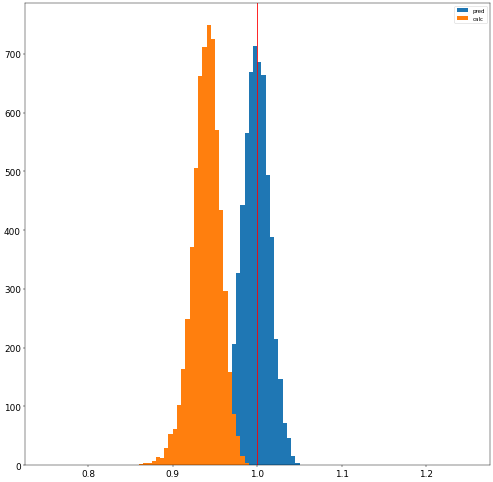

batches for test: 61
test loss: 13.904093773638616
calib weights: Parameter containing:
tensor([1.1617, 1.1490, 1.1313, 1.1026, 1.0853, 1.0753, 1.0574, 1.0584, 1.0459,
        1.0448, 1.0353, 1.0436, 1.0482, 1.0535, 1.0574, 1.0745, 1.0737, 1.0926,
        1.0909, 1.1033, 1.0616, 1.0847, 1.0603, 1.1342, 1.0955, 1.1609, 1.1253,
        1.2985], device='cuda:1', requires_grad=True)
new best test loss: 13.904093773638616
epoch: 15


100%|██████████| 121/121 [00:00<00:00, 527.29it/s]


batches for train: 121
train loss: 13.50501263043112


100%|██████████| 61/61 [00:00<00:00, 152.04it/s]


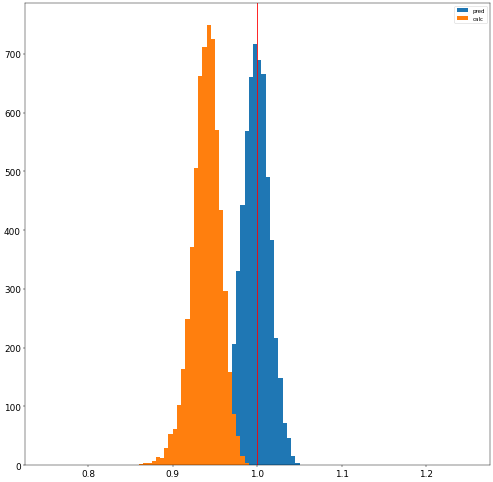

batches for test: 61
test loss: 13.904392226797636
calib weights: Parameter containing:
tensor([1.1638, 1.1509, 1.1331, 1.1027, 1.0851, 1.0755, 1.0568, 1.0591, 1.0456,
        1.0449, 1.0344, 1.0434, 1.0483, 1.0536, 1.0573, 1.0758, 1.0742, 1.0946,
        1.0920, 1.1052, 1.0578, 1.0826, 1.0544, 1.1360, 1.0927, 1.1654, 1.1252,
        1.3180], device='cuda:1', requires_grad=True)
epoch: 16


100%|██████████| 121/121 [00:00<00:00, 530.73it/s]


batches for train: 121
train loss: 13.503089282138289


100%|██████████| 61/61 [00:00<00:00, 155.53it/s]


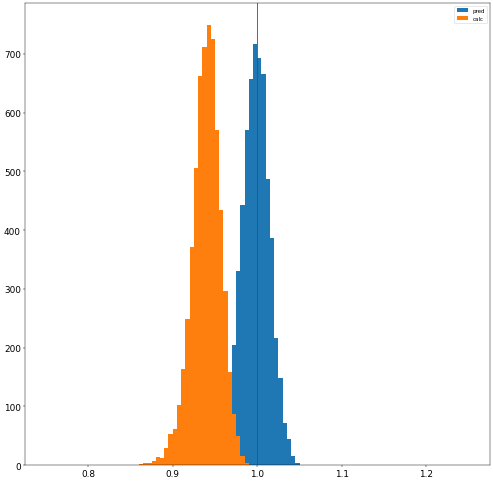

batches for test: 61
test loss: 13.90493899486104
calib weights: Parameter containing:
tensor([1.1655, 1.1525, 1.1347, 1.1027, 1.0848, 1.0757, 1.0562, 1.0598, 1.0455,
        1.0451, 1.0334, 1.0433, 1.0484, 1.0538, 1.0573, 1.0771, 1.0747, 1.0966,
        1.0930, 1.1071, 1.0538, 1.0804, 1.0484, 1.1379, 1.0899, 1.1700, 1.1252,
        1.3383], device='cuda:1', requires_grad=True)
epoch: 17


100%|██████████| 121/121 [00:00<00:00, 451.15it/s]


batches for train: 121
train loss: 13.501271350324647


100%|██████████| 61/61 [00:00<00:00, 150.53it/s]


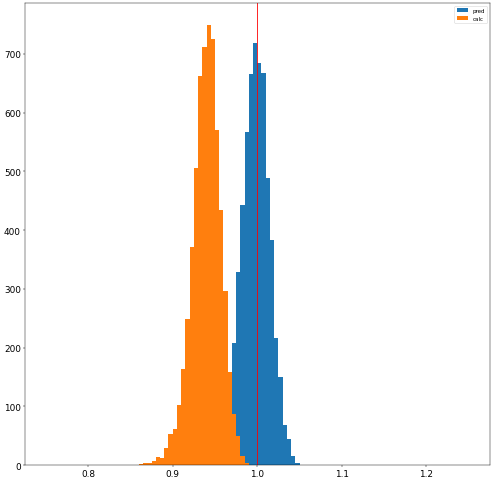

batches for test: 61
test loss: 13.905658331073699
calib weights: Parameter containing:
tensor([1.1669, 1.1539, 1.1362, 1.1026, 1.0845, 1.0759, 1.0557, 1.0606, 1.0453,
        1.0453, 1.0325, 1.0432, 1.0485, 1.0539, 1.0571, 1.0784, 1.0751, 1.0987,
        1.0941, 1.1091, 1.0498, 1.0782, 1.0425, 1.1400, 1.0872, 1.1749, 1.1253,
        1.3593], device='cuda:1', requires_grad=True)
epoch: 18


100%|██████████| 121/121 [00:00<00:00, 487.84it/s]


batches for train: 121
train loss: 13.49963297725709


100%|██████████| 61/61 [00:00<00:00, 149.75it/s]


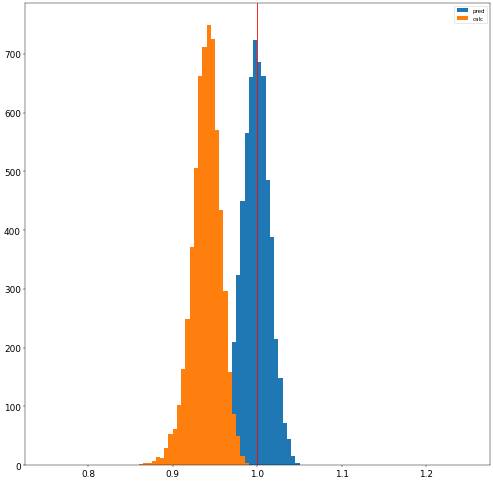

batches for test: 61
test loss: 13.906493061878642
calib weights: Parameter containing:
tensor([1.1681, 1.1552, 1.1376, 1.1024, 1.0841, 1.0762, 1.0551, 1.0615, 1.0453,
        1.0456, 1.0316, 1.0432, 1.0485, 1.0539, 1.0569, 1.0796, 1.0754, 1.1007,
        1.0951, 1.1111, 1.0457, 1.0760, 1.0368, 1.1422, 1.0846, 1.1800, 1.1255,
        1.3809], device='cuda:1', requires_grad=True)
epoch: 19


100%|██████████| 121/121 [00:00<00:00, 454.47it/s]


batches for train: 121
train loss: 13.498205452911124


100%|██████████| 61/61 [00:00<00:00, 147.16it/s]


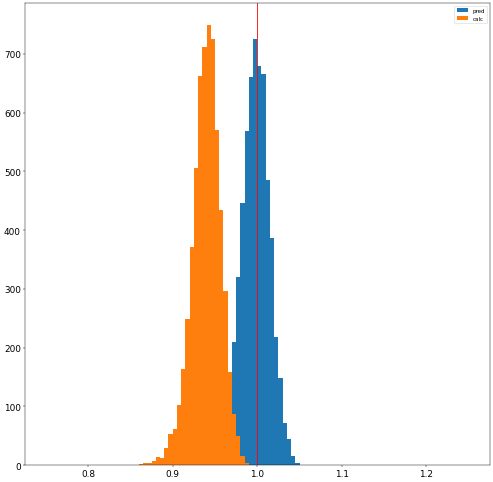

batches for test: 61
test loss: 13.907379369266698
calib weights: Parameter containing:
tensor([1.1691, 1.1563, 1.1390, 1.1021, 1.0837, 1.0764, 1.0546, 1.0625, 1.0452,
        1.0460, 1.0306, 1.0431, 1.0486, 1.0540, 1.0567, 1.0809, 1.0757, 1.1028,
        1.0961, 1.1132, 1.0417, 1.0738, 1.0311, 1.1445, 1.0821, 1.1852, 1.1257,
        1.4029], device='cuda:1', requires_grad=True)


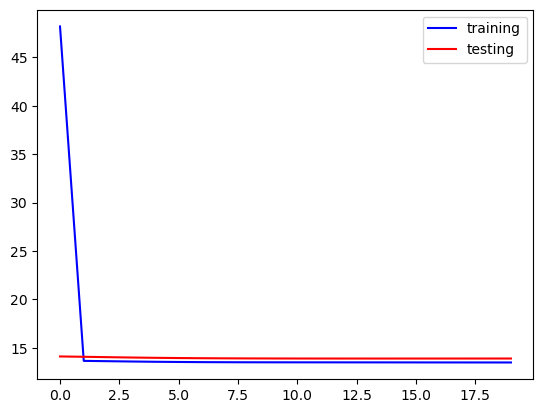

epoch: 20


100%|██████████| 121/121 [00:00<00:00, 497.07it/s]


batches for train: 121
train loss: 13.496988769405144


100%|██████████| 61/61 [00:00<00:00, 154.97it/s]


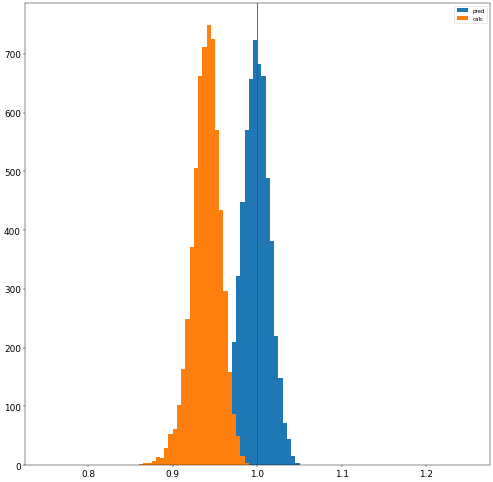

batches for test: 61
test loss: 13.908252262678303
calib weights: Parameter containing:
tensor([1.1698, 1.1573, 1.1403, 1.1017, 1.0833, 1.0767, 1.0541, 1.0635, 1.0452,
        1.0463, 1.0297, 1.0430, 1.0487, 1.0540, 1.0564, 1.0821, 1.0760, 1.1048,
        1.0971, 1.1153, 1.0376, 1.0717, 1.0257, 1.1469, 1.0798, 1.1904, 1.1260,
        1.4253], device='cuda:1', requires_grad=True)
epoch: 21


100%|██████████| 121/121 [00:00<00:00, 493.20it/s]


batches for train: 121
train loss: 13.49595806027247


100%|██████████| 61/61 [00:00<00:00, 147.14it/s]


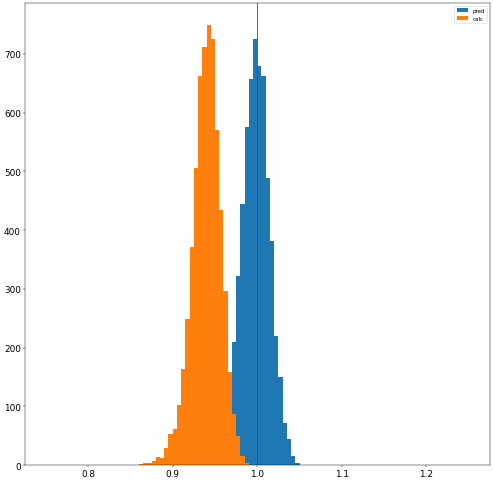

batches for test: 61
test loss: 13.909033931669642
calib weights: Parameter containing:
tensor([1.1703, 1.1582, 1.1415, 1.1014, 1.0829, 1.0769, 1.0535, 1.0645, 1.0452,
        1.0467, 1.0287, 1.0429, 1.0488, 1.0540, 1.0561, 1.0833, 1.0762, 1.1068,
        1.0981, 1.1174, 1.0336, 1.0697, 1.0204, 1.1493, 1.0775, 1.1957, 1.1263,
        1.4480], device='cuda:1', requires_grad=True)
epoch: 22


100%|██████████| 121/121 [00:00<00:00, 525.84it/s]


batches for train: 121
train loss: 13.495087166463048


100%|██████████| 61/61 [00:00<00:00, 154.99it/s]


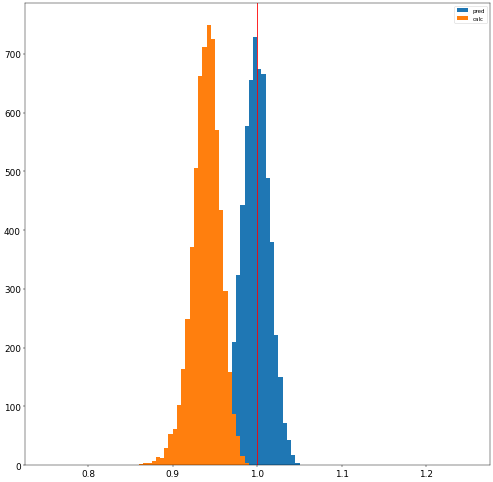

batches for test: 61
test loss: 13.90967602026267
calib weights: Parameter containing:
tensor([1.1708, 1.1590, 1.1427, 1.1009, 1.0824, 1.0772, 1.0530, 1.0656, 1.0452,
        1.0471, 1.0278, 1.0429, 1.0488, 1.0540, 1.0558, 1.0845, 1.0763, 1.1088,
        1.0990, 1.1194, 1.0296, 1.0677, 1.0153, 1.1518, 1.0753, 1.2010, 1.1265,
        1.4707], device='cuda:1', requires_grad=True)
epoch: 23


100%|██████████| 121/121 [00:00<00:00, 507.99it/s]


batches for train: 121
train loss: 13.494343907379907


100%|██████████| 61/61 [00:00<00:00, 97.56it/s] 


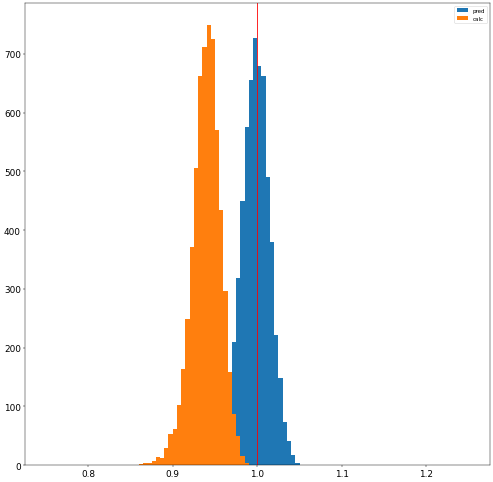

batches for test: 61
test loss: 13.910142288833368
calib weights: Parameter containing:
tensor([1.1710, 1.1597, 1.1439, 1.1005, 1.0820, 1.0775, 1.0525, 1.0666, 1.0452,
        1.0476, 1.0268, 1.0428, 1.0489, 1.0540, 1.0554, 1.0856, 1.0764, 1.1108,
        1.0999, 1.1214, 1.0257, 1.0657, 1.0105, 1.1542, 1.0732, 1.2063, 1.1268,
        1.4935], device='cuda:1', requires_grad=True)
epoch: 24


100%|██████████| 121/121 [00:00<00:00, 394.78it/s]


batches for train: 121
train loss: 13.493702423474021


100%|██████████| 61/61 [00:00<00:00, 135.45it/s]


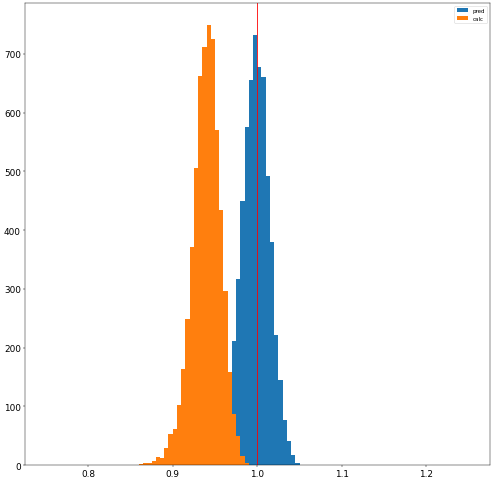

batches for test: 61
test loss: 13.910409286373952
calib weights: Parameter containing:
tensor([1.1712, 1.1603, 1.1450, 1.1000, 1.0815, 1.0777, 1.0519, 1.0677, 1.0452,
        1.0480, 1.0259, 1.0427, 1.0490, 1.0539, 1.0550, 1.0867, 1.0765, 1.1127,
        1.1008, 1.1234, 1.0219, 1.0638, 1.0058, 1.1566, 1.0712, 1.2115, 1.1270,
        1.5162], device='cuda:1', requires_grad=True)
epoch: 25


100%|██████████| 121/121 [00:00<00:00, 449.17it/s]


batches for train: 121
train loss: 13.493140937868228


100%|██████████| 61/61 [00:00<00:00, 145.41it/s]


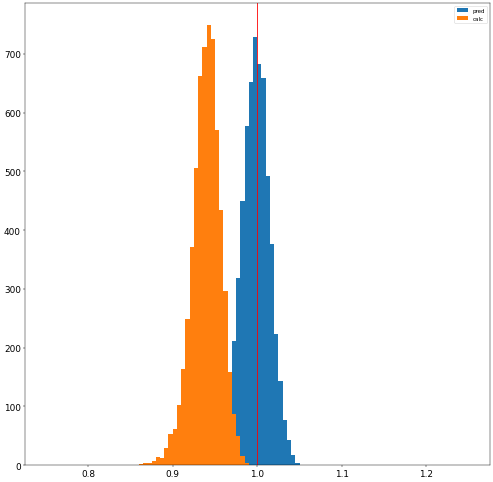

batches for test: 61
test loss: 13.910469070809786
calib weights: Parameter containing:
tensor([1.1713, 1.1609, 1.1461, 1.0996, 1.0810, 1.0780, 1.0514, 1.0688, 1.0452,
        1.0484, 1.0249, 1.0426, 1.0490, 1.0538, 1.0545, 1.0878, 1.0765, 1.1145,
        1.1016, 1.1254, 1.0182, 1.0620, 1.0014, 1.1590, 1.0693, 1.2165, 1.1271,
        1.5388], device='cuda:1', requires_grad=True)
epoch: 26


100%|██████████| 121/121 [00:00<00:00, 528.69it/s]


batches for train: 121
train loss: 13.49263631016755


100%|██████████| 61/61 [00:00<00:00, 155.79it/s]


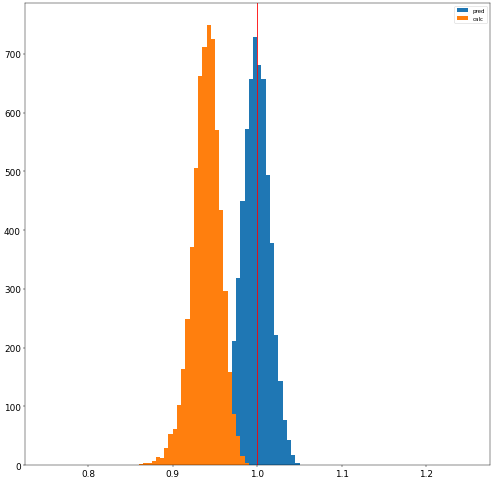

batches for test: 61
test loss: 13.910342654243845
calib weights: Parameter containing:
tensor([1.1713, 1.1614, 1.1472, 1.0991, 1.0806, 1.0782, 1.0509, 1.0699, 1.0452,
        1.0488, 1.0240, 1.0426, 1.0491, 1.0538, 1.0541, 1.0888, 1.0765, 1.1163,
        1.1024, 1.1273, 1.0146, 1.0602, 0.9972, 1.1613, 1.0674, 1.2214, 1.1271,
        1.5611], device='cuda:1', requires_grad=True)
epoch: 27


100%|██████████| 121/121 [00:00<00:00, 460.02it/s]


batches for train: 121
train loss: 13.492179058800058


100%|██████████| 61/61 [00:00<00:00, 145.92it/s]


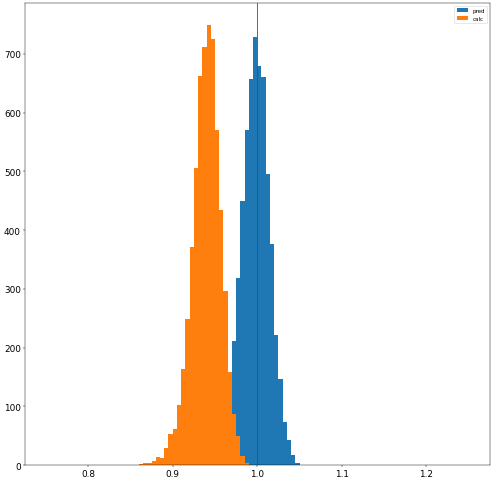

batches for test: 61
test loss: 13.910042762756348
calib weights: Parameter containing:
tensor([1.1712, 1.1619, 1.1482, 1.0986, 1.0801, 1.0785, 1.0504, 1.0709, 1.0452,
        1.0493, 1.0231, 1.0425, 1.0491, 1.0537, 1.0536, 1.0898, 1.0764, 1.1181,
        1.1031, 1.1291, 1.0110, 1.0585, 0.9931, 1.1636, 1.0655, 1.2262, 1.1271,
        1.5832], device='cuda:1', requires_grad=True)
epoch: 28


100%|██████████| 121/121 [00:00<00:00, 441.52it/s]


batches for train: 121
train loss: 13.491756896342128


100%|██████████| 61/61 [00:00<00:00, 142.25it/s]


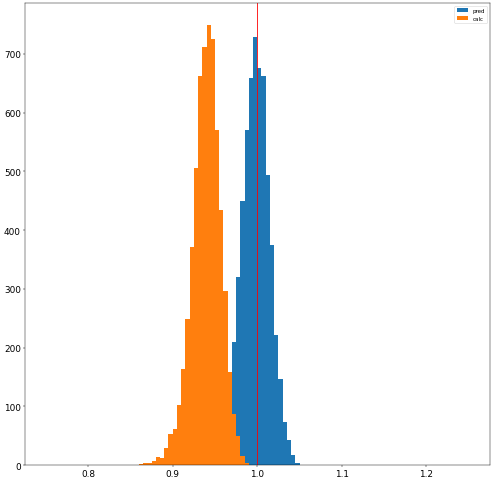

batches for test: 61
test loss: 13.909593394545258
calib weights: Parameter containing:
tensor([1.1711, 1.1623, 1.1493, 1.0981, 1.0796, 1.0787, 1.0498, 1.0720, 1.0452,
        1.0497, 1.0222, 1.0425, 1.0492, 1.0536, 1.0532, 1.0907, 1.0763, 1.1197,
        1.1038, 1.1309, 1.0076, 1.0569, 0.9893, 1.1657, 1.0637, 1.2308, 1.1270,
        1.6050], device='cuda:1', requires_grad=True)
epoch: 29


100%|██████████| 121/121 [00:00<00:00, 568.79it/s]


batches for train: 121
train loss: 13.491365574608164


100%|██████████| 61/61 [00:00<00:00, 156.19it/s]


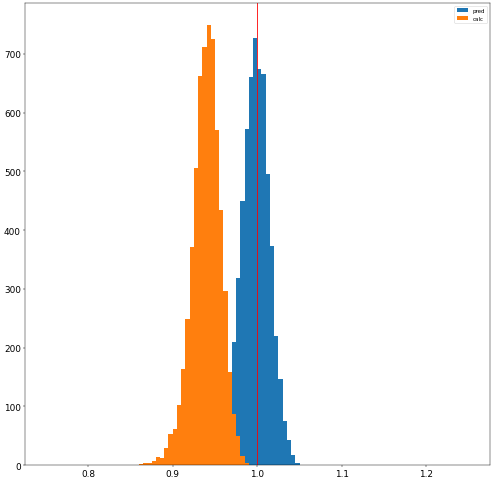

batches for test: 61
test loss: 13.909020189379083
calib weights: Parameter containing:
tensor([1.1709, 1.1627, 1.1503, 1.0977, 1.0792, 1.0790, 1.0493, 1.0730, 1.0452,
        1.0501, 1.0213, 1.0424, 1.0492, 1.0535, 1.0527, 1.0916, 1.0762, 1.1214,
        1.1044, 1.1327, 1.0044, 1.0553, 0.9857, 1.1678, 1.0620, 1.2352, 1.1269,
        1.6265], device='cuda:1', requires_grad=True)


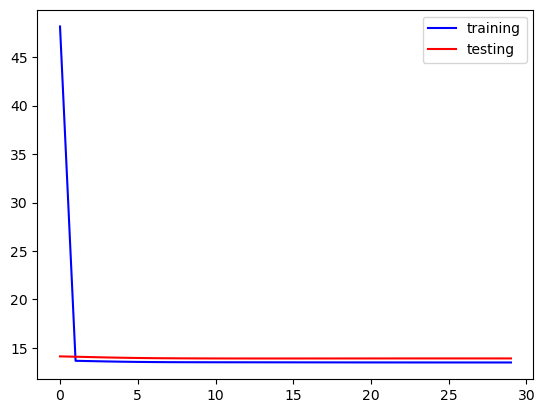

epoch: 30


100%|██████████| 121/121 [00:00<00:00, 477.81it/s]


batches for train: 121
train loss: 13.49099838635153


100%|██████████| 61/61 [00:00<00:00, 94.75it/s] 


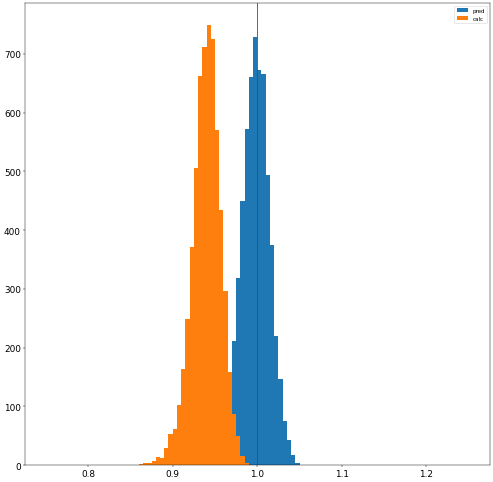

batches for test: 61
test loss: 13.908351788755324
calib weights: Parameter containing:
tensor([1.1707, 1.1631, 1.1512, 1.0972, 1.0787, 1.0792, 1.0488, 1.0740, 1.0452,
        1.0505, 1.0205, 1.0424, 1.0493, 1.0534, 1.0522, 1.0925, 1.0761, 1.1229,
        1.1050, 1.1344, 1.0012, 1.0538, 0.9823, 1.1698, 1.0602, 1.2394, 1.1266,
        1.6476], device='cuda:1', requires_grad=True)
epoch: 31


100%|██████████| 121/121 [00:00<00:00, 499.60it/s]


batches for train: 121
train loss: 13.490655315809013


100%|██████████| 61/61 [00:00<00:00, 152.03it/s]


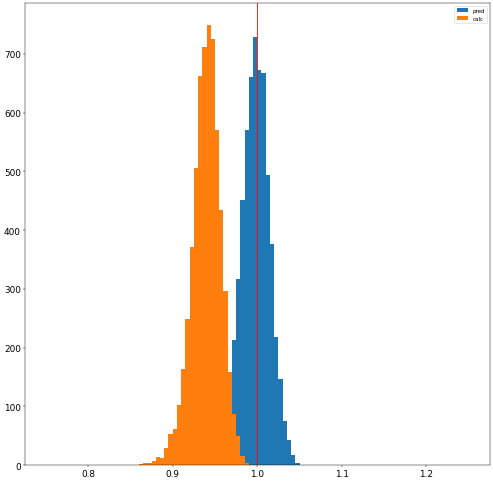

batches for test: 61
test loss: 13.907606859676173
calib weights: Parameter containing:
tensor([1.1705, 1.1634, 1.1522, 1.0967, 1.0783, 1.0795, 1.0482, 1.0749, 1.0452,
        1.0509, 1.0197, 1.0423, 1.0494, 1.0533, 1.0517, 1.0933, 1.0760, 1.1244,
        1.1055, 1.1360, 0.9982, 1.0524, 0.9790, 1.1717, 1.0586, 1.2435, 1.1263,
        1.6683], device='cuda:1', requires_grad=True)
epoch: 32


100%|██████████| 121/121 [00:00<00:00, 512.84it/s]


batches for train: 121
train loss: 13.490332863547586


100%|██████████| 61/61 [00:00<00:00, 157.27it/s]


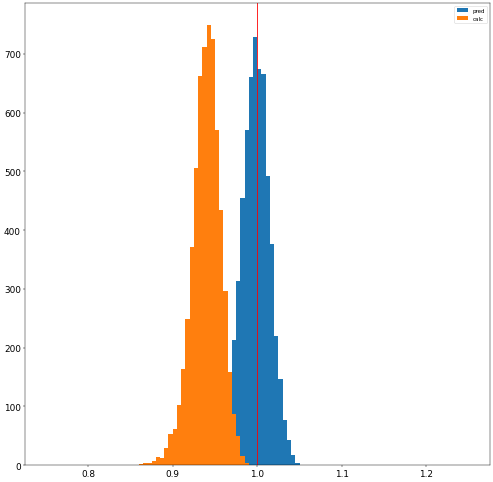

batches for test: 61
test loss: 13.906804366189926
calib weights: Parameter containing:
tensor([1.1702, 1.1637, 1.1531, 1.0963, 1.0778, 1.0797, 1.0477, 1.0759, 1.0452,
        1.0513, 1.0188, 1.0423, 1.0495, 1.0532, 1.0512, 1.0942, 1.0758, 1.1259,
        1.1061, 1.1376, 0.9953, 1.0510, 0.9760, 1.1736, 1.0569, 1.2473, 1.1258,
        1.6887], device='cuda:1', requires_grad=True)
epoch: 33


100%|██████████| 121/121 [00:00<00:00, 549.77it/s]


batches for train: 121
train loss: 13.490028499571745


100%|██████████| 61/61 [00:00<00:00, 154.84it/s]


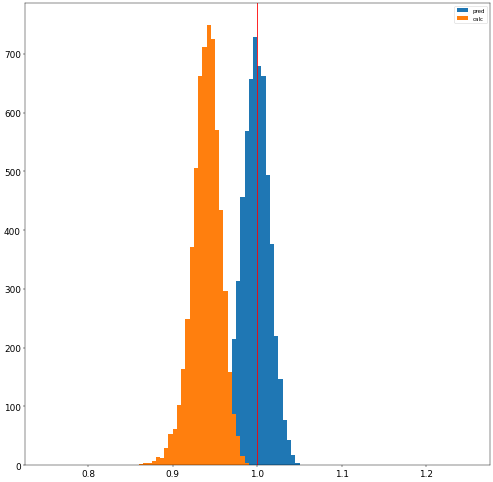

batches for test: 61
test loss: 13.905970307647205
calib weights: Parameter containing:
tensor([1.1700, 1.1640, 1.1540, 1.0958, 1.0774, 1.0799, 1.0472, 1.0768, 1.0451,
        1.0517, 1.0181, 1.0423, 1.0495, 1.0530, 1.0508, 1.0949, 1.0756, 1.1272,
        1.1065, 1.1392, 0.9925, 1.0496, 0.9731, 1.1753, 1.0553, 1.2510, 1.1254,
        1.7087], device='cuda:1', requires_grad=True)
epoch: 34


100%|██████████| 121/121 [00:00<00:00, 432.90it/s]


batches for train: 121
train loss: 13.489742704659454


100%|██████████| 61/61 [00:00<00:00, 144.92it/s]


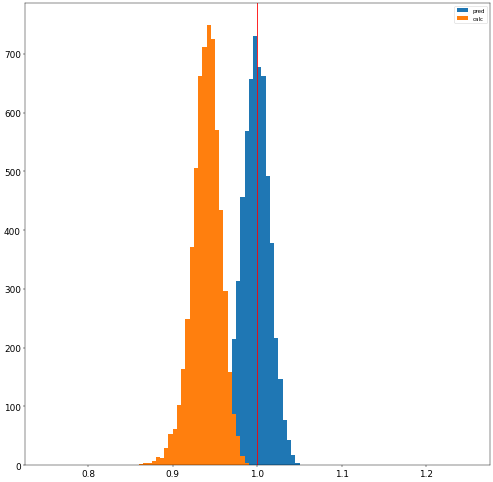

batches for test: 61
test loss: 13.905112563586625
calib weights: Parameter containing:
tensor([1.1697, 1.1643, 1.1549, 1.0954, 1.0770, 1.0801, 1.0467, 1.0777, 1.0451,
        1.0521, 1.0173, 1.0423, 1.0496, 1.0529, 1.0503, 1.0957, 1.0754, 1.1286,
        1.1070, 1.1407, 0.9898, 1.0484, 0.9703, 1.1770, 1.0537, 1.2545, 1.1248,
        1.7282], device='cuda:1', requires_grad=True)
epoch: 35


100%|██████████| 121/121 [00:00<00:00, 543.84it/s]


batches for train: 121
train loss: 13.489475005914358


100%|██████████| 61/61 [00:00<00:00, 154.98it/s]


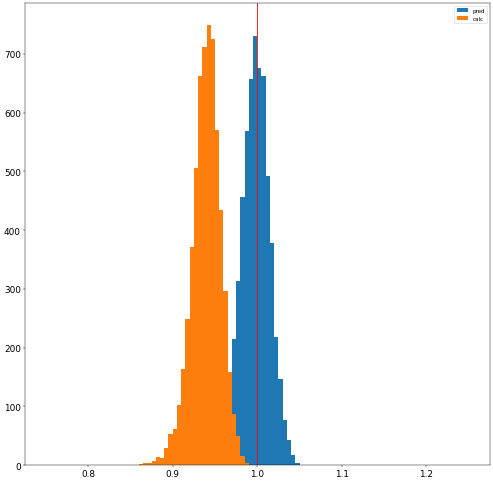

batches for test: 61
test loss: 13.904243719382364
calib weights: Parameter containing:
tensor([1.1693, 1.1645, 1.1558, 1.0950, 1.0766, 1.0803, 1.0462, 1.0786, 1.0450,
        1.0525, 1.0166, 1.0423, 1.0497, 1.0529, 1.0498, 1.0964, 1.0752, 1.1299,
        1.1074, 1.1421, 0.9872, 1.0471, 0.9677, 1.1785, 1.0522, 1.2579, 1.1242,
        1.7474], device='cuda:1', requires_grad=True)
epoch: 36


100%|██████████| 121/121 [00:00<00:00, 522.74it/s]


batches for train: 121
train loss: 13.489225868351204


100%|██████████| 61/61 [00:00<00:00, 155.24it/s]


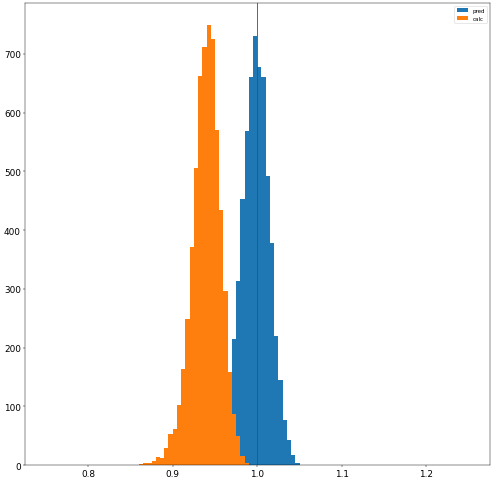

batches for test: 61
test loss: 13.903372702051382
calib weights: Parameter containing:
tensor([1.1690, 1.1648, 1.1567, 1.0946, 1.0763, 1.0805, 1.0457, 1.0794, 1.0450,
        1.0529, 1.0159, 1.0423, 1.0498, 1.0528, 1.0494, 1.0971, 1.0750, 1.1311,
        1.1078, 1.1435, 0.9847, 1.0460, 0.9653, 1.1801, 1.0507, 1.2610, 1.1235,
        1.7662], device='cuda:1', requires_grad=True)
new best test loss: 13.903372702051382
epoch: 37


100%|██████████| 121/121 [00:00<00:00, 573.07it/s]


batches for train: 121
train loss: 13.488992375775803


100%|██████████| 61/61 [00:00<00:00, 98.61it/s] 


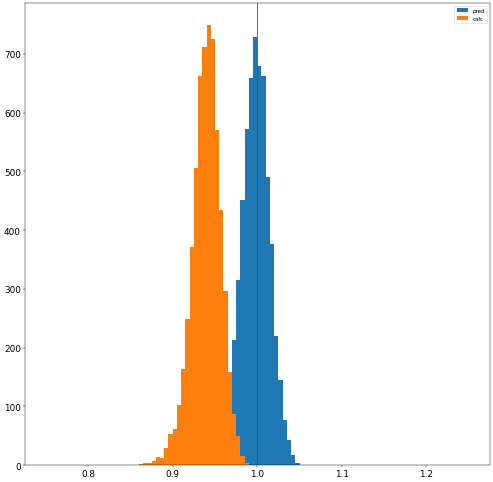

batches for test: 61
test loss: 13.902513769806408
calib weights: Parameter containing:
tensor([1.1686, 1.1650, 1.1575, 1.0942, 1.0759, 1.0808, 1.0452, 1.0802, 1.0449,
        1.0532, 1.0152, 1.0423, 1.0499, 1.0527, 1.0489, 1.0978, 1.0747, 1.1323,
        1.1082, 1.1448, 0.9824, 1.0449, 0.9630, 1.1815, 1.0492, 1.2640, 1.1228,
        1.7846], device='cuda:1', requires_grad=True)
new best test loss: 13.902513769806408
epoch: 38


100%|██████████| 121/121 [00:00<00:00, 530.26it/s]


batches for train: 121
train loss: 13.488775663139407


100%|██████████| 61/61 [00:00<00:00, 156.39it/s]


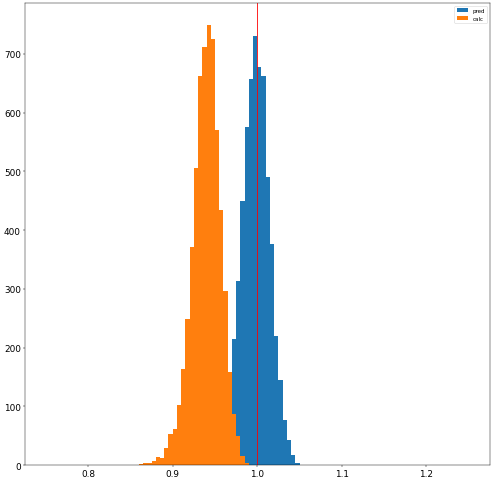

batches for test: 61
test loss: 13.90166024692723
calib weights: Parameter containing:
tensor([1.1683, 1.1652, 1.1583, 1.0939, 1.0756, 1.0810, 1.0447, 1.0810, 1.0449,
        1.0536, 1.0145, 1.0423, 1.0500, 1.0526, 1.0485, 1.0984, 1.0745, 1.1335,
        1.1085, 1.1461, 0.9801, 1.0438, 0.9608, 1.1828, 1.0478, 1.2669, 1.1220,
        1.8027], device='cuda:1', requires_grad=True)
new best test loss: 13.90166024692723
epoch: 39


100%|██████████| 121/121 [00:00<00:00, 577.50it/s]


batches for train: 121
train loss: 13.488572041850444


100%|██████████| 61/61 [00:00<00:00, 157.10it/s]


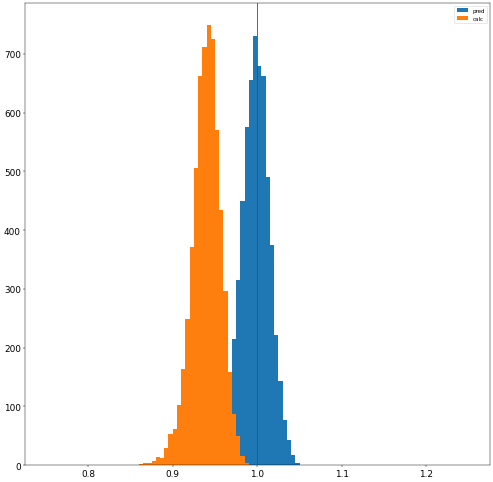

batches for test: 61
test loss: 13.900829924911749
calib weights: Parameter containing:
tensor([1.1679, 1.1653, 1.1591, 1.0935, 1.0752, 1.0812, 1.0443, 1.0818, 1.0448,
        1.0539, 1.0138, 1.0423, 1.0501, 1.0525, 1.0481, 1.0991, 1.0742, 1.1346,
        1.1088, 1.1473, 0.9779, 1.0428, 0.9587, 1.1841, 1.0464, 1.2696, 1.1212,
        1.8203], device='cuda:1', requires_grad=True)
new best test loss: 13.900829924911749


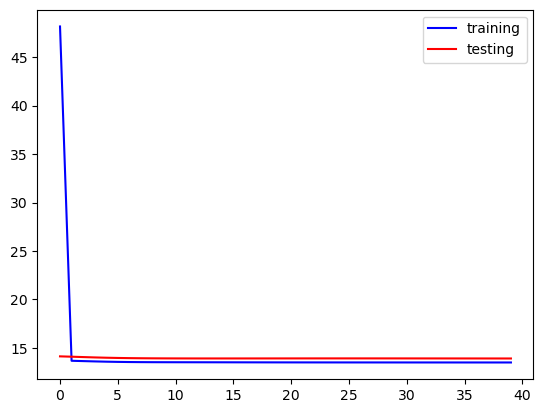

epoch: 40


100%|██████████| 121/121 [00:00<00:00, 525.25it/s]


batches for train: 121
train loss: 13.488385066513187


100%|██████████| 61/61 [00:00<00:00, 154.05it/s]


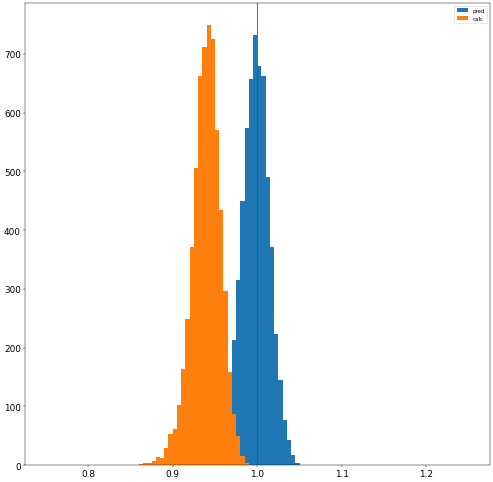

batches for test: 61
test loss: 13.900018832722647
calib weights: Parameter containing:
tensor([1.1675, 1.1655, 1.1599, 1.0931, 1.0749, 1.0814, 1.0438, 1.0825, 1.0448,
        1.0543, 1.0132, 1.0423, 1.0502, 1.0524, 1.0476, 1.0997, 1.0740, 1.1356,
        1.1091, 1.1485, 0.9759, 1.0418, 0.9568, 1.1854, 1.0450, 1.2722, 1.1203,
        1.8376], device='cuda:1', requires_grad=True)
new best test loss: 13.900018832722647
epoch: 41


100%|██████████| 121/121 [00:00<00:00, 432.33it/s]


batches for train: 121
train loss: 13.488210662337375


100%|██████████| 61/61 [00:00<00:00, 145.95it/s]


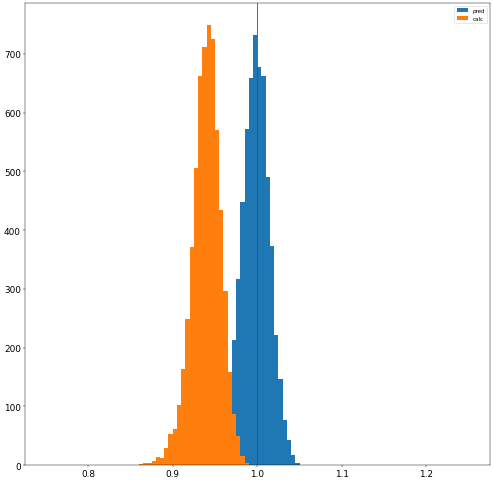

batches for test: 61
test loss: 13.89923044110908
calib weights: Parameter containing:
tensor([1.1671, 1.1657, 1.1606, 1.0928, 1.0746, 1.0816, 1.0433, 1.0833, 1.0447,
        1.0546, 1.0126, 1.0423, 1.0503, 1.0524, 1.0472, 1.1002, 1.0737, 1.1366,
        1.1094, 1.1497, 0.9739, 1.0409, 0.9549, 1.1865, 1.0436, 1.2746, 1.1194,
        1.8545], device='cuda:1', requires_grad=True)
new best test loss: 13.89923044110908
epoch: 42


100%|██████████| 121/121 [00:00<00:00, 442.19it/s]


batches for train: 121
train loss: 13.48804905000797


100%|██████████| 61/61 [00:00<00:00, 147.96it/s]


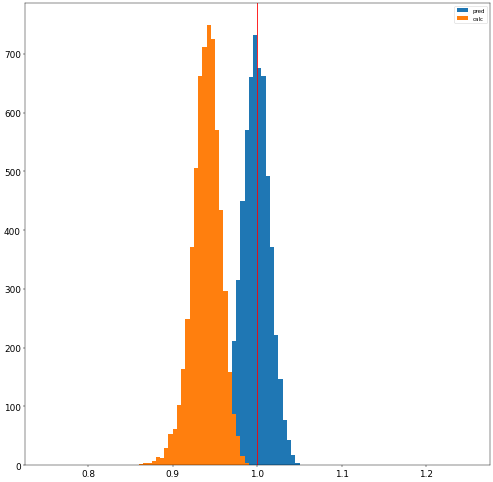

batches for test: 61
test loss: 13.89847222312552
calib weights: Parameter containing:
tensor([1.1667, 1.1658, 1.1614, 1.0925, 1.0743, 1.0817, 1.0429, 1.0840, 1.0446,
        1.0549, 1.0120, 1.0423, 1.0504, 1.0523, 1.0468, 1.1008, 1.0735, 1.1376,
        1.1096, 1.1508, 0.9720, 1.0400, 0.9532, 1.1876, 1.0423, 1.2769, 1.1184,
        1.8711], device='cuda:1', requires_grad=True)
new best test loss: 13.89847222312552
epoch: 43


100%|██████████| 121/121 [00:00<00:00, 545.73it/s]


batches for train: 121
train loss: 13.48790160880601


100%|██████████| 61/61 [00:00<00:00, 154.82it/s]


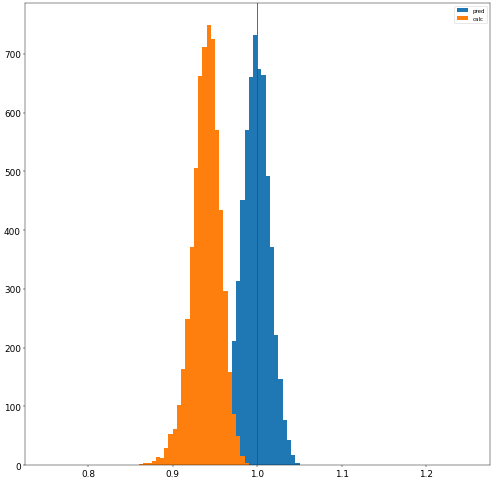

batches for test: 61
test loss: 13.89773139015573
calib weights: Parameter containing:
tensor([1.1663, 1.1659, 1.1621, 1.0922, 1.0740, 1.0819, 1.0424, 1.0847, 1.0446,
        1.0552, 1.0115, 1.0424, 1.0505, 1.0522, 1.0464, 1.1013, 1.0732, 1.1386,
        1.1099, 1.1519, 0.9702, 1.0392, 0.9515, 1.1887, 1.0410, 1.2791, 1.1175,
        1.8873], device='cuda:1', requires_grad=True)
new best test loss: 13.89773139015573
epoch: 44


100%|██████████| 121/121 [00:00<00:00, 528.16it/s]


batches for train: 121
train loss: 13.48776425605963


100%|██████████| 61/61 [00:00<00:00, 153.76it/s]


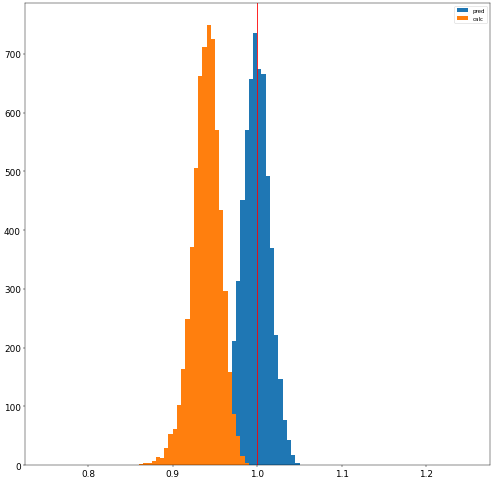

batches for test: 61
test loss: 13.897020465037862
calib weights: Parameter containing:
tensor([1.1659, 1.1660, 1.1628, 1.0919, 1.0738, 1.0821, 1.0420, 1.0853, 1.0445,
        1.0555, 1.0109, 1.0424, 1.0506, 1.0522, 1.0461, 1.1019, 1.0730, 1.1395,
        1.1101, 1.1529, 0.9685, 1.0384, 0.9499, 1.1896, 1.0398, 1.2811, 1.1165,
        1.9032], device='cuda:1', requires_grad=True)
new best test loss: 13.897020465037862
epoch: 45


100%|██████████| 121/121 [00:00<00:00, 444.76it/s]


batches for train: 121
train loss: 13.487637598652485


100%|██████████| 61/61 [00:00<00:00, 145.29it/s]


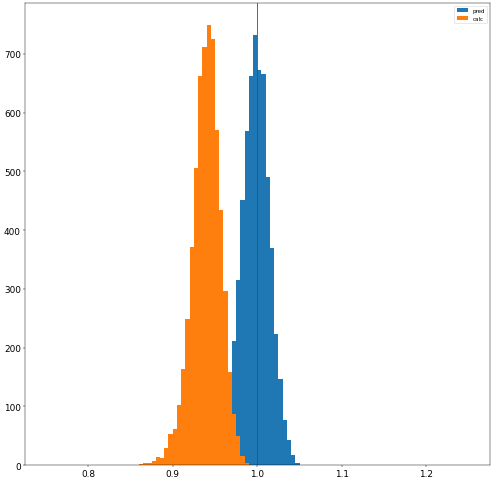

batches for test: 61
test loss: 13.896339260163854
calib weights: Parameter containing:
tensor([1.1655, 1.1661, 1.1635, 1.0916, 1.0735, 1.0823, 1.0416, 1.0860, 1.0444,
        1.0558, 1.0104, 1.0424, 1.0508, 1.0521, 1.0457, 1.1024, 1.0727, 1.1403,
        1.1103, 1.1539, 0.9669, 1.0377, 0.9485, 1.1906, 1.0385, 1.2830, 1.1154,
        1.9187], device='cuda:1', requires_grad=True)
new best test loss: 13.896339260163854
epoch: 46


100%|██████████| 121/121 [00:00<00:00, 527.08it/s]


batches for train: 121
train loss: 13.487521116398582


100%|██████████| 61/61 [00:00<00:00, 155.58it/s]


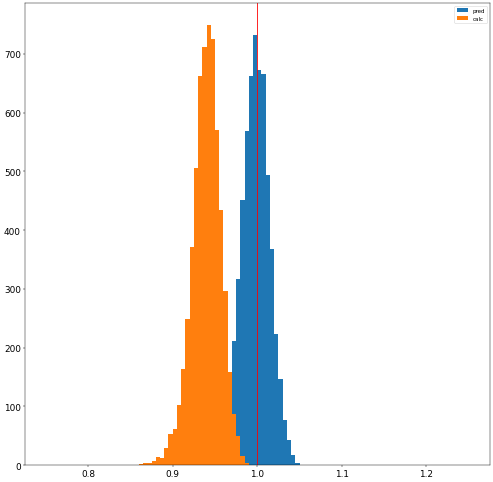

batches for test: 61
test loss: 13.895682053487809
calib weights: Parameter containing:
tensor([1.1651, 1.1662, 1.1642, 1.0913, 1.0732, 1.0825, 1.0411, 1.0866, 1.0443,
        1.0561, 1.0099, 1.0425, 1.0509, 1.0520, 1.0453, 1.1028, 1.0725, 1.1412,
        1.1105, 1.1549, 0.9653, 1.0369, 0.9471, 1.1915, 1.0373, 1.2849, 1.1144,
        1.9340], device='cuda:1', requires_grad=True)
new best test loss: 13.895682053487809
epoch: 47


100%|██████████| 121/121 [00:00<00:00, 557.86it/s]


batches for train: 121
train loss: 13.487414557086534


100%|██████████| 61/61 [00:00<00:00, 155.46it/s]


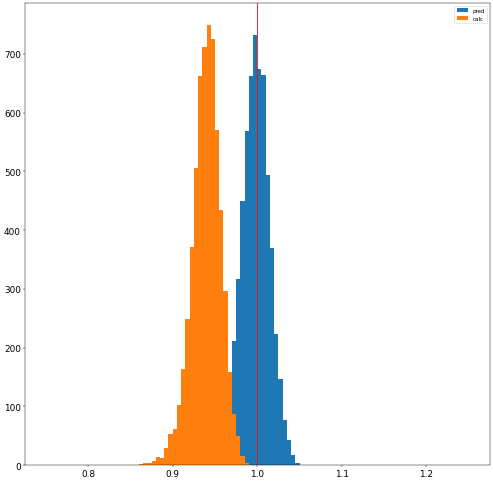

batches for test: 61
test loss: 13.89504675005303
calib weights: Parameter containing:
tensor([1.1647, 1.1663, 1.1648, 1.0910, 1.0730, 1.0827, 1.0407, 1.0872, 1.0442,
        1.0564, 1.0094, 1.0425, 1.0510, 1.0520, 1.0450, 1.1033, 1.0722, 1.1420,
        1.1106, 1.1558, 0.9638, 1.0362, 0.9457, 1.1923, 1.0362, 1.2866, 1.1133,
        1.9489], device='cuda:1', requires_grad=True)
new best test loss: 13.89504675005303
epoch: 48


100%|██████████| 121/121 [00:00<00:00, 526.99it/s]


batches for train: 121
train loss: 13.487315382839235


100%|██████████| 61/61 [00:00<00:00, 98.86it/s] 


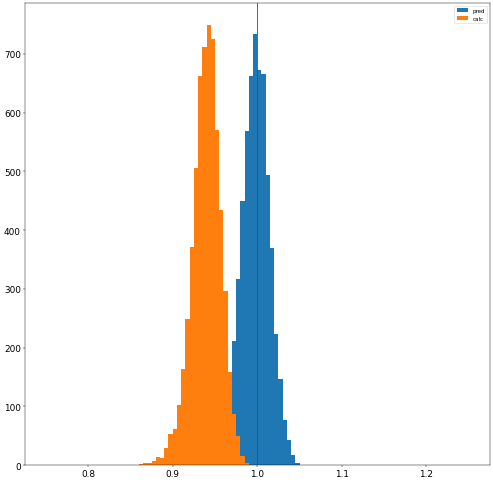

batches for test: 61
test loss: 13.894441323202164
calib weights: Parameter containing:
tensor([1.1643, 1.1663, 1.1654, 1.0908, 1.0728, 1.0829, 1.0403, 1.0878, 1.0442,
        1.0567, 1.0089, 1.0425, 1.0511, 1.0519, 1.0446, 1.1038, 1.0719, 1.1428,
        1.1108, 1.1567, 0.9623, 1.0356, 0.9445, 1.1931, 1.0350, 1.2882, 1.1122,
        1.9635], device='cuda:1', requires_grad=True)
new best test loss: 13.894441323202164
epoch: 49


100%|██████████| 121/121 [00:00<00:00, 511.56it/s]


batches for train: 121
train loss: 13.487225343373197


100%|██████████| 61/61 [00:00<00:00, 155.37it/s]


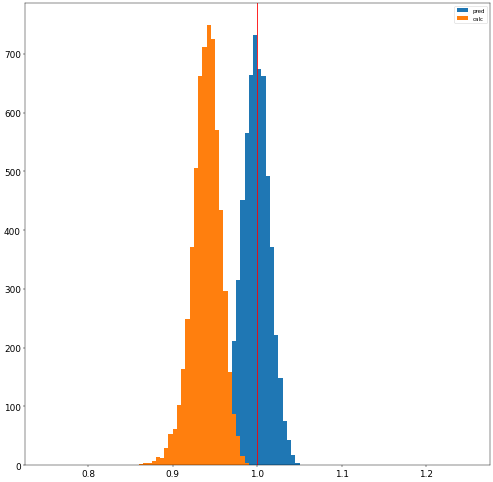

batches for test: 61
test loss: 13.89385859692683
calib weights: Parameter containing:
tensor([1.1639, 1.1664, 1.1661, 1.0905, 1.0725, 1.0830, 1.0399, 1.0884, 1.0441,
        1.0570, 1.0084, 1.0426, 1.0512, 1.0519, 1.0443, 1.1042, 1.0717, 1.1435,
        1.1109, 1.1576, 0.9610, 1.0350, 0.9433, 1.1938, 1.0339, 1.2897, 1.1111,
        1.9777], device='cuda:1', requires_grad=True)
new best test loss: 13.89385859692683


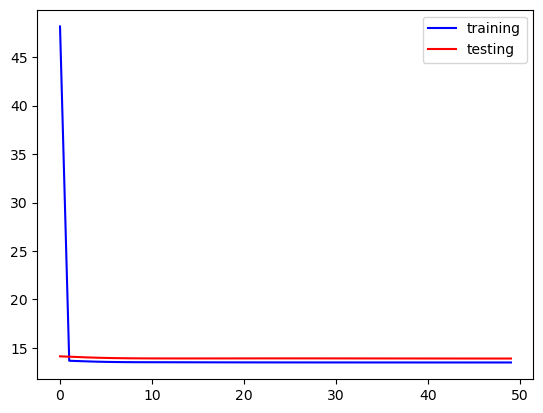

epoch: 50


100%|██████████| 121/121 [00:00<00:00, 516.35it/s]


batches for train: 121
train loss: 13.487142562866211


100%|██████████| 61/61 [00:00<00:00, 154.53it/s]


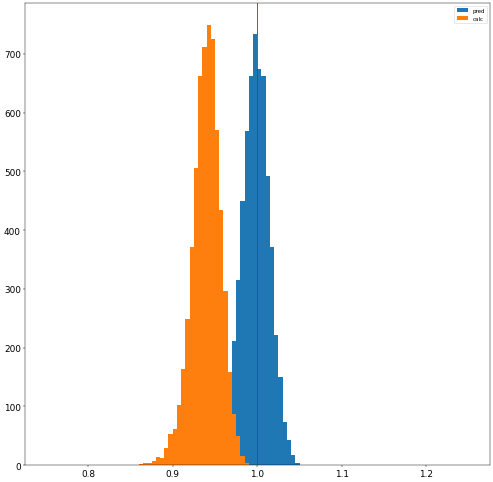

batches for test: 61
test loss: 13.893301526054007
calib weights: Parameter containing:
tensor([1.1634, 1.1664, 1.1667, 1.0903, 1.0723, 1.0832, 1.0395, 1.0889, 1.0440,
        1.0572, 1.0080, 1.0426, 1.0513, 1.0519, 1.0439, 1.1046, 1.0714, 1.1443,
        1.1111, 1.1584, 0.9597, 1.0344, 0.9422, 1.1946, 1.0328, 1.2912, 1.1100,
        1.9917], device='cuda:1', requires_grad=True)
new best test loss: 13.893301526054007
epoch: 51


100%|██████████| 121/121 [00:00<00:00, 565.71it/s]


batches for train: 121
train loss: 13.487067750662812


100%|██████████| 61/61 [00:00<00:00, 155.24it/s]


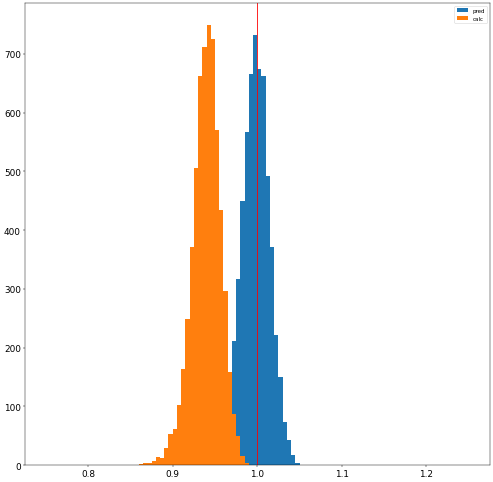

batches for test: 61
test loss: 13.892767749848913
calib weights: Parameter containing:
tensor([1.1630, 1.1665, 1.1673, 1.0900, 1.0721, 1.0834, 1.0392, 1.0894, 1.0439,
        1.0575, 1.0075, 1.0427, 1.0514, 1.0518, 1.0436, 1.1050, 1.0712, 1.1450,
        1.1112, 1.1592, 0.9584, 1.0338, 0.9411, 1.1952, 1.0318, 1.2925, 1.1089,
        2.0054], device='cuda:1', requires_grad=True)
new best test loss: 13.892767749848913
epoch: 52


100%|██████████| 121/121 [00:00<00:00, 518.73it/s]


batches for train: 121
train loss: 13.486997943279171


100%|██████████| 61/61 [00:00<00:00, 155.62it/s]


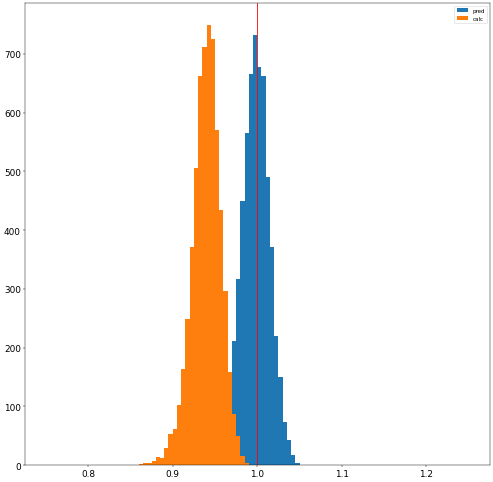

batches for test: 61
test loss: 13.892252578109991
calib weights: Parameter containing:
tensor([1.1626, 1.1665, 1.1678, 1.0898, 1.0719, 1.0836, 1.0388, 1.0900, 1.0438,
        1.0577, 1.0071, 1.0427, 1.0515, 1.0518, 1.0433, 1.1054, 1.0709, 1.1456,
        1.1113, 1.1600, 0.9572, 1.0332, 0.9401, 1.1959, 1.0307, 1.2938, 1.1078,
        2.0188], device='cuda:1', requires_grad=True)
new best test loss: 13.892252578109991
epoch: 53


100%|██████████| 121/121 [00:00<00:00, 519.85it/s]


batches for train: 121
train loss: 13.486934118034426


100%|██████████| 61/61 [00:00<00:00, 148.64it/s]


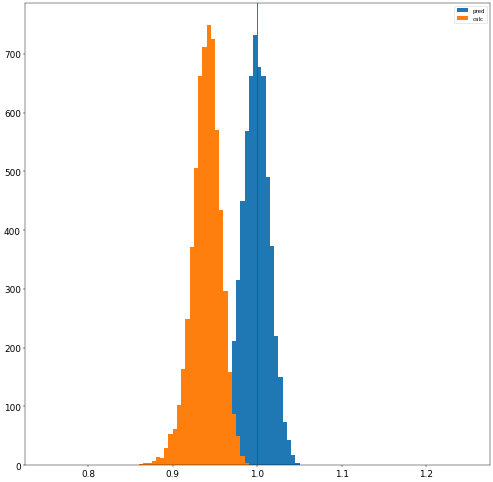

batches for test: 61
test loss: 13.891755698157139
calib weights: Parameter containing:
tensor([1.1622, 1.1665, 1.1684, 1.0896, 1.0717, 1.0837, 1.0384, 1.0905, 1.0437,
        1.0580, 1.0067, 1.0428, 1.0517, 1.0517, 1.0430, 1.1058, 1.0706, 1.1463,
        1.1114, 1.1608, 0.9561, 1.0327, 0.9391, 1.1965, 1.0297, 1.2950, 1.1067,
        2.0319], device='cuda:1', requires_grad=True)
new best test loss: 13.891755698157139
epoch: 54


100%|██████████| 121/121 [00:00<00:00, 536.22it/s]


batches for train: 121
train loss: 13.486876408915874


100%|██████████| 61/61 [00:00<00:00, 156.37it/s]


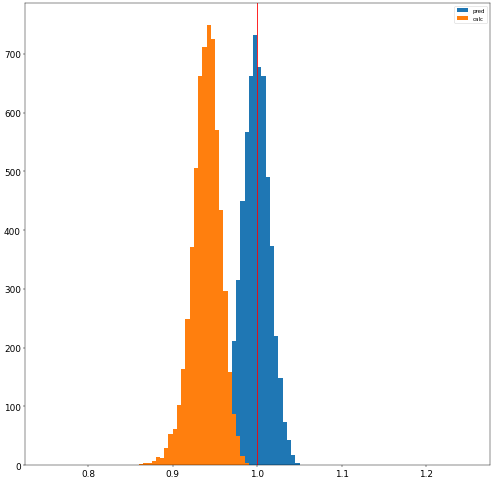

batches for test: 61
test loss: 13.89128846027812
calib weights: Parameter containing:
tensor([1.1618, 1.1665, 1.1689, 1.0894, 1.0715, 1.0839, 1.0381, 1.0910, 1.0436,
        1.0582, 1.0063, 1.0428, 1.0518, 1.0517, 1.0427, 1.1061, 1.0704, 1.1469,
        1.1115, 1.1615, 0.9550, 1.0322, 0.9382, 1.1970, 1.0287, 1.2961, 1.1056,
        2.0447], device='cuda:1', requires_grad=True)
new best test loss: 13.89128846027812
epoch: 55


100%|██████████| 121/121 [00:00<00:00, 522.83it/s]


batches for train: 121
train loss: 13.486822632718678


100%|██████████| 61/61 [00:00<00:00, 153.43it/s]


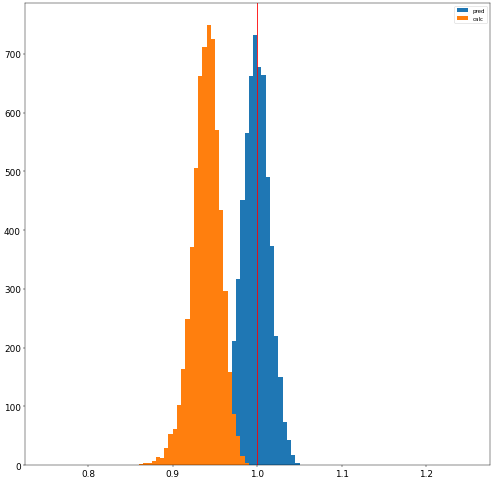

batches for test: 61
test loss: 13.890833401289143
calib weights: Parameter containing:
tensor([1.1614, 1.1665, 1.1695, 1.0891, 1.0714, 1.0841, 1.0377, 1.0914, 1.0436,
        1.0584, 1.0059, 1.0429, 1.0519, 1.0517, 1.0424, 1.1065, 1.0701, 1.1475,
        1.1116, 1.1622, 0.9539, 1.0317, 0.9373, 1.1976, 1.0278, 1.2972, 1.1045,
        2.0573], device='cuda:1', requires_grad=True)
new best test loss: 13.890833401289143
epoch: 56


100%|██████████| 121/121 [00:00<00:00, 526.98it/s]


batches for train: 121
train loss: 13.486775823861114


100%|██████████| 61/61 [00:00<00:00, 153.38it/s]


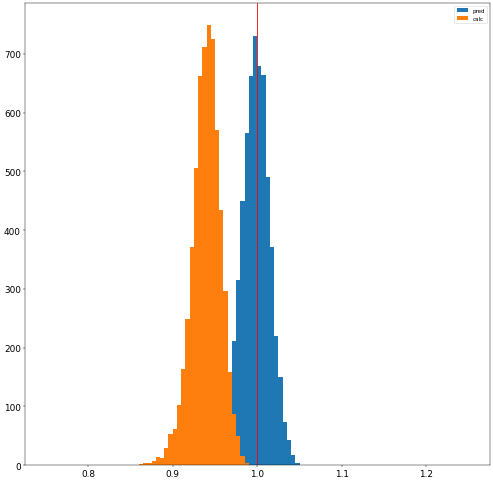

batches for test: 61
test loss: 13.890399979763343
calib weights: Parameter containing:
tensor([1.1610, 1.1665, 1.1700, 1.0889, 1.0712, 1.0842, 1.0374, 1.0919, 1.0435,
        1.0586, 1.0055, 1.0429, 1.0520, 1.0516, 1.0421, 1.1068, 1.0699, 1.1481,
        1.1116, 1.1629, 0.9529, 1.0313, 0.9365, 1.1981, 1.0268, 1.2982, 1.1033,
        2.0696], device='cuda:1', requires_grad=True)
new best test loss: 13.890399979763343
epoch: 57


100%|██████████| 121/121 [00:00<00:00, 574.32it/s]


batches for train: 121
train loss: 13.486732435620521


100%|██████████| 61/61 [00:00<00:00, 156.68it/s]


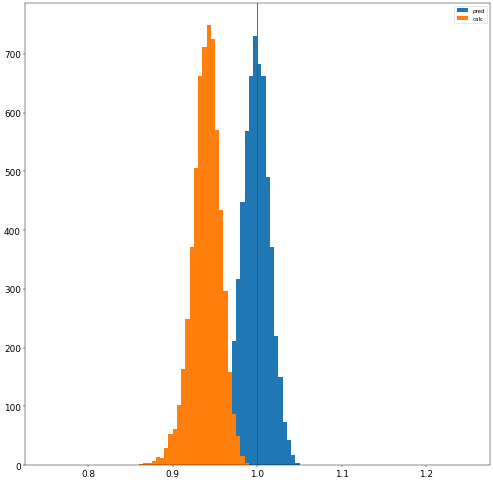

batches for test: 61
test loss: 13.889978643323554
calib weights: Parameter containing:
tensor([1.1606, 1.1665, 1.1705, 1.0887, 1.0710, 1.0844, 1.0370, 1.0924, 1.0434,
        1.0589, 1.0052, 1.0429, 1.0521, 1.0516, 1.0419, 1.1072, 1.0697, 1.1486,
        1.1117, 1.1635, 0.9520, 1.0309, 0.9358, 1.1986, 1.0259, 1.2991, 1.1022,
        2.0817], device='cuda:1', requires_grad=True)
new best test loss: 13.889978643323554
epoch: 58


100%|██████████| 121/121 [00:00<00:00, 517.32it/s]


batches for train: 121
train loss: 13.486693839396327


100%|██████████| 61/61 [00:00<00:00, 154.08it/s]


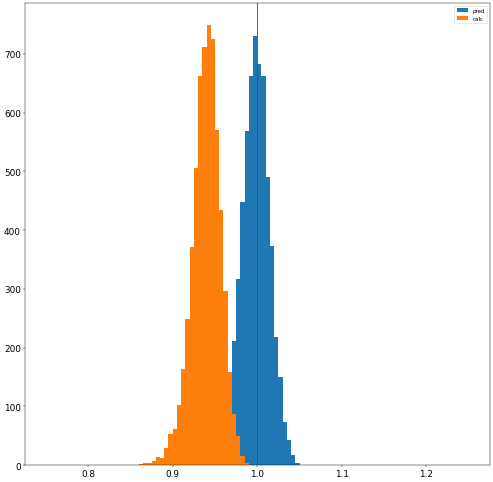

batches for test: 61
test loss: 13.889582415096095
calib weights: Parameter containing:
tensor([1.1602, 1.1665, 1.1710, 1.0886, 1.0709, 1.0845, 1.0367, 1.0928, 1.0433,
        1.0591, 1.0048, 1.0430, 1.0522, 1.0516, 1.0416, 1.1075, 1.0694, 1.1492,
        1.1118, 1.1642, 0.9511, 1.0305, 0.9350, 1.1990, 1.0251, 1.3000, 1.1011,
        2.0935], device='cuda:1', requires_grad=True)
new best test loss: 13.889582415096095
epoch: 59


100%|██████████| 121/121 [00:00<00:00, 528.15it/s]


batches for train: 121
train loss: 13.486658663789102


100%|██████████| 61/61 [00:00<00:00, 98.53it/s] 


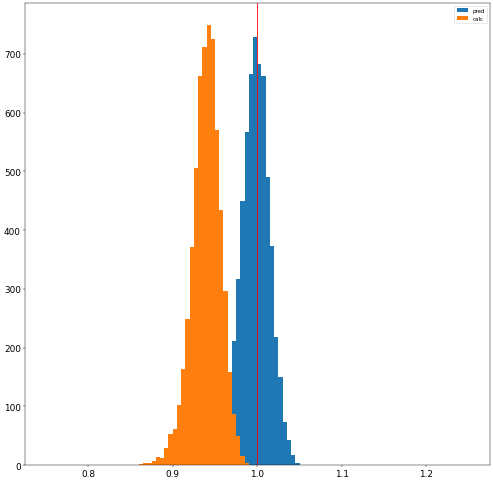

batches for test: 61
test loss: 13.889199288164983
calib weights: Parameter containing:
tensor([1.1599, 1.1665, 1.1714, 1.0884, 1.0707, 1.0847, 1.0364, 1.0932, 1.0432,
        1.0593, 1.0045, 1.0430, 1.0523, 1.0516, 1.0413, 1.1078, 1.0692, 1.1497,
        1.1118, 1.1648, 0.9502, 1.0301, 0.9343, 1.1994, 1.0242, 1.3008, 1.1000,
        2.1051], device='cuda:1', requires_grad=True)
new best test loss: 13.889199288164983


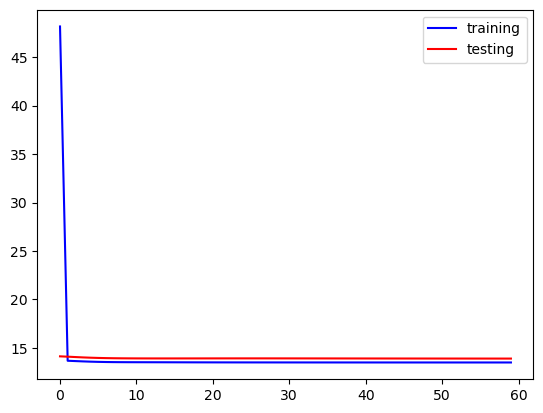

epoch: 60


100%|██████████| 121/121 [00:00<00:00, 482.84it/s]


batches for train: 121
train loss: 13.48662735016878


100%|██████████| 61/61 [00:00<00:00, 149.46it/s]


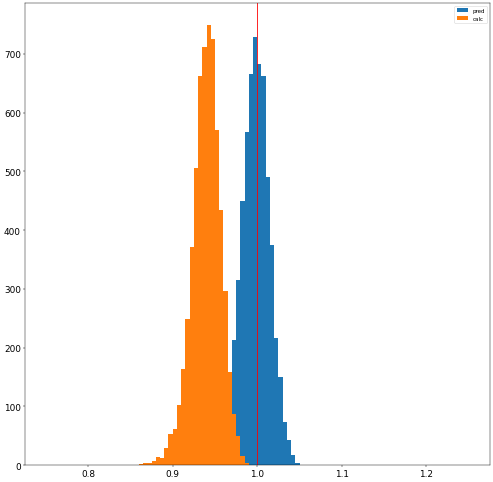

batches for test: 61
test loss: 13.888829325066238
calib weights: Parameter containing:
tensor([1.1595, 1.1665, 1.1719, 1.0882, 1.0706, 1.0849, 1.0361, 1.0936, 1.0431,
        1.0595, 1.0041, 1.0431, 1.0524, 1.0515, 1.0411, 1.1081, 1.0689, 1.1502,
        1.1119, 1.1653, 0.9493, 1.0297, 0.9337, 1.1998, 1.0233, 1.3015, 1.0989,
        2.1164], device='cuda:1', requires_grad=True)
new best test loss: 13.888829325066238
epoch: 61


100%|██████████| 121/121 [00:00<00:00, 570.94it/s]


batches for train: 121
train loss: 13.486597187262921


100%|██████████| 61/61 [00:00<00:00, 158.18it/s]


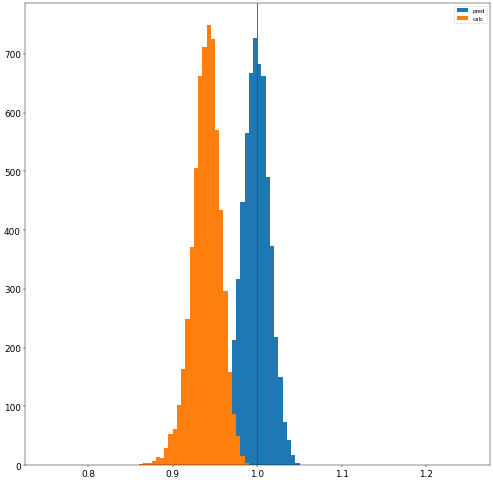

batches for test: 61
test loss: 13.888474542586529
calib weights: Parameter containing:
tensor([1.1591, 1.1665, 1.1723, 1.0880, 1.0705, 1.0850, 1.0357, 1.0940, 1.0430,
        1.0597, 1.0038, 1.0431, 1.0525, 1.0515, 1.0408, 1.1084, 1.0687, 1.1507,
        1.1119, 1.1659, 0.9485, 1.0293, 0.9330, 1.2002, 1.0225, 1.3022, 1.0978,
        2.1275], device='cuda:1', requires_grad=True)
new best test loss: 13.888474542586529
epoch: 62


100%|██████████| 121/121 [00:00<00:00, 511.17it/s]


batches for train: 121
train loss: 13.486572202572154


100%|██████████| 61/61 [00:00<00:00, 155.61it/s]


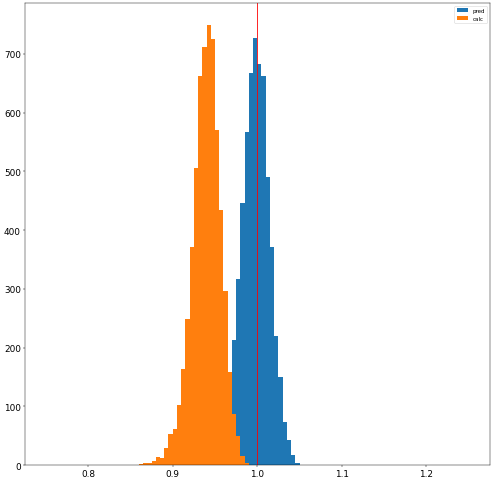

batches for test: 61
test loss: 13.888132908305185
calib weights: Parameter containing:
tensor([1.1587, 1.1664, 1.1728, 1.0879, 1.0703, 1.0852, 1.0354, 1.0944, 1.0429,
        1.0599, 1.0035, 1.0432, 1.0526, 1.0515, 1.0406, 1.1087, 1.0685, 1.1512,
        1.1119, 1.1665, 0.9478, 1.0290, 0.9324, 1.2006, 1.0217, 1.3029, 1.0967,
        2.1384], device='cuda:1', requires_grad=True)
new best test loss: 13.888132908305185
epoch: 63


100%|██████████| 121/121 [00:00<00:00, 578.82it/s]


batches for train: 121
train loss: 13.486549937035427


100%|██████████| 61/61 [00:00<00:00, 156.92it/s]


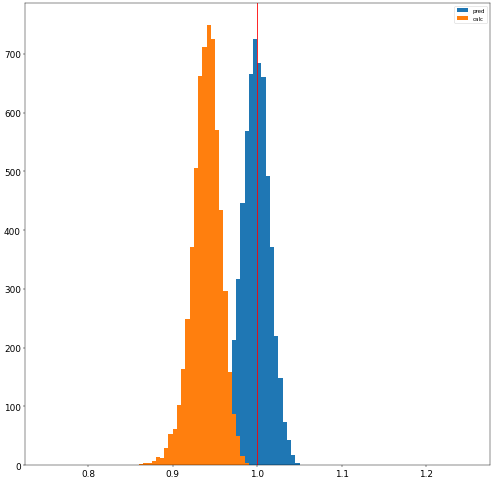

batches for test: 61
test loss: 13.88780764282727
calib weights: Parameter containing:
tensor([1.1584, 1.1664, 1.1732, 1.0877, 1.0702, 1.0853, 1.0351, 1.0948, 1.0429,
        1.0601, 1.0032, 1.0432, 1.0527, 1.0515, 1.0404, 1.1090, 1.0683, 1.1516,
        1.1120, 1.1670, 0.9471, 1.0287, 0.9319, 1.2009, 1.0210, 1.3035, 1.0956,
        2.1490], device='cuda:1', requires_grad=True)
new best test loss: 13.88780764282727
epoch: 64


100%|██████████| 121/121 [00:00<00:00, 535.50it/s]


batches for train: 121
train loss: 13.48652950791288


100%|██████████| 61/61 [00:00<00:00, 157.22it/s]


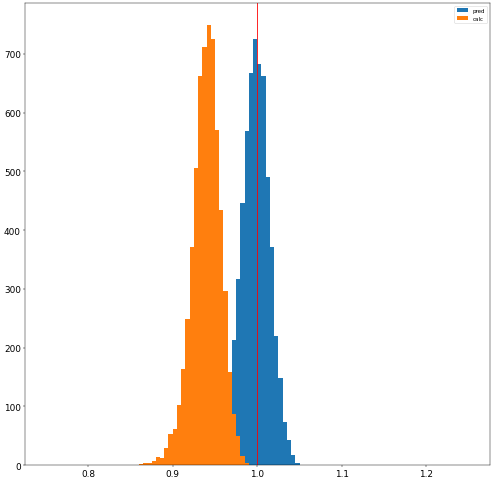

batches for test: 61
test loss: 13.887495697521773
calib weights: Parameter containing:
tensor([1.1580, 1.1664, 1.1736, 1.0875, 1.0701, 1.0854, 1.0349, 1.0952, 1.0428,
        1.0602, 1.0029, 1.0433, 1.0528, 1.0515, 1.0401, 1.1092, 1.0680, 1.1521,
        1.1120, 1.1675, 0.9464, 1.0284, 0.9313, 1.2012, 1.0202, 1.3040, 1.0946,
        2.1595], device='cuda:1', requires_grad=True)
new best test loss: 13.887495697521773
epoch: 65


100%|██████████| 121/121 [00:00<00:00, 515.42it/s]


batches for train: 121
train loss: 13.486512247195913


100%|██████████| 61/61 [00:00<00:00, 157.67it/s]


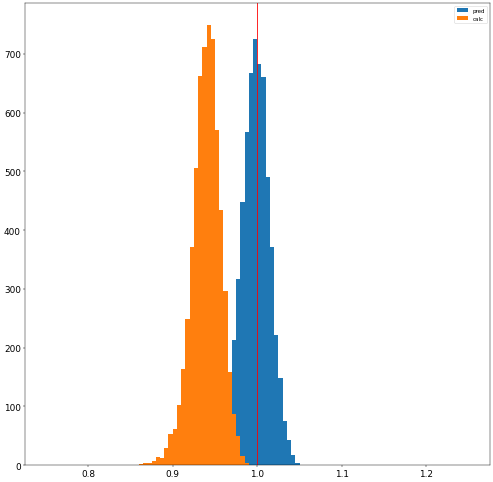

batches for test: 61
test loss: 13.887192194579077
calib weights: Parameter containing:
tensor([1.1577, 1.1663, 1.1740, 1.0874, 1.0700, 1.0856, 1.0346, 1.0955, 1.0427,
        1.0604, 1.0026, 1.0433, 1.0529, 1.0514, 1.0399, 1.1095, 1.0678, 1.1525,
        1.1120, 1.1680, 0.9457, 1.0281, 0.9308, 1.2015, 1.0195, 1.3045, 1.0935,
        2.1697], device='cuda:1', requires_grad=True)
new best test loss: 13.887192194579077
epoch: 66


100%|██████████| 121/121 [00:00<00:00, 525.87it/s]


batches for train: 121
train loss: 13.486496539155313


100%|██████████| 61/61 [00:00<00:00, 154.60it/s]


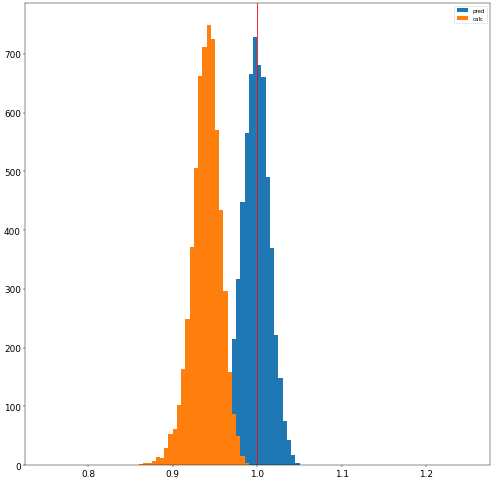

batches for test: 61
test loss: 13.886902965483118
calib weights: Parameter containing:
tensor([1.1573, 1.1663, 1.1744, 1.0872, 1.0698, 1.0857, 1.0343, 1.0959, 1.0426,
        1.0606, 1.0024, 1.0434, 1.0530, 1.0514, 1.0397, 1.1097, 1.0676, 1.1529,
        1.1120, 1.1685, 0.9450, 1.0278, 0.9303, 1.2018, 1.0188, 1.3050, 1.0925,
        2.1797], device='cuda:1', requires_grad=True)
new best test loss: 13.886902965483118
epoch: 67


100%|██████████| 121/121 [00:00<00:00, 511.30it/s]


batches for train: 121
train loss: 13.486482612357651


100%|██████████| 61/61 [00:00<00:00, 155.99it/s]


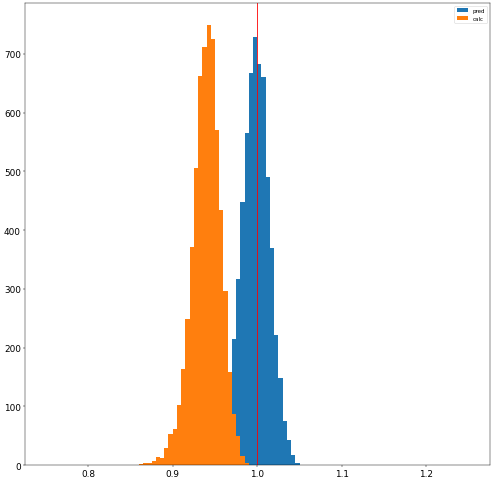

batches for test: 61
test loss: 13.886624289340661
calib weights: Parameter containing:
tensor([1.1570, 1.1662, 1.1748, 1.0871, 1.0697, 1.0859, 1.0340, 1.0962, 1.0425,
        1.0607, 1.0021, 1.0434, 1.0531, 1.0514, 1.0395, 1.1100, 1.0674, 1.1533,
        1.1120, 1.1689, 0.9444, 1.0275, 0.9299, 1.2020, 1.0181, 1.3055, 1.0914,
        2.1895], device='cuda:1', requires_grad=True)
new best test loss: 13.886624289340661
epoch: 68


100%|██████████| 121/121 [00:00<00:00, 502.26it/s]


batches for train: 121
train loss: 13.486470719014317


100%|██████████| 61/61 [00:00<00:00, 151.81it/s]


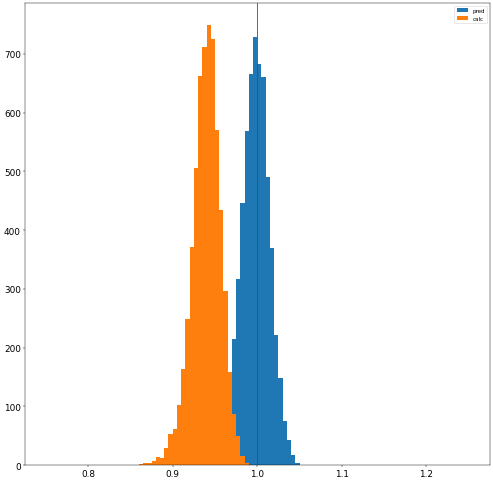

batches for test: 61
test loss: 13.886358276742403
calib weights: Parameter containing:
tensor([1.1567, 1.1662, 1.1752, 1.0869, 1.0696, 1.0860, 1.0338, 1.0966, 1.0424,
        1.0609, 1.0018, 1.0435, 1.0532, 1.0514, 1.0393, 1.1102, 1.0672, 1.1537,
        1.1121, 1.1694, 0.9439, 1.0272, 0.9294, 1.2023, 1.0174, 1.3059, 1.0904,
        2.1992], device='cuda:1', requires_grad=True)
new best test loss: 13.886358276742403
epoch: 69


100%|██████████| 121/121 [00:00<00:00, 506.53it/s]


batches for train: 121
train loss: 13.486461347784878


100%|██████████| 61/61 [00:00<00:00, 156.39it/s]


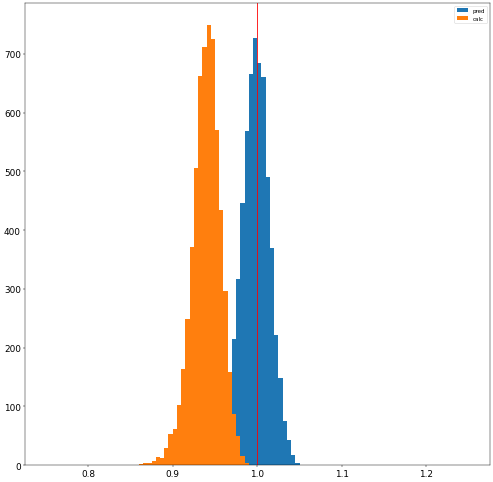

batches for test: 61
test loss: 13.886098330138159
calib weights: Parameter containing:
tensor([1.1563, 1.1661, 1.1755, 1.0868, 1.0695, 1.0861, 1.0335, 1.0969, 1.0423,
        1.0611, 1.0016, 1.0435, 1.0533, 1.0514, 1.0391, 1.1104, 1.0670, 1.1540,
        1.1121, 1.1698, 0.9433, 1.0270, 0.9290, 1.2025, 1.0167, 1.3062, 1.0894,
        2.2086], device='cuda:1', requires_grad=True)
new best test loss: 13.886098330138159


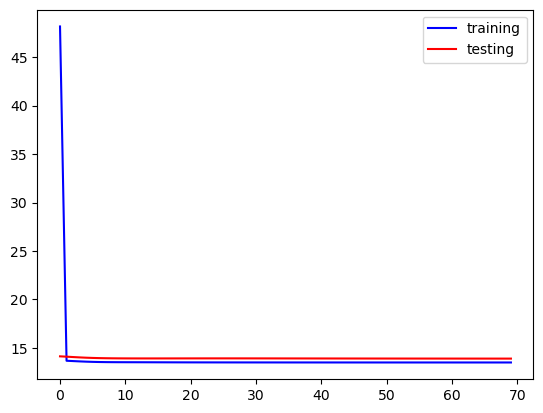

epoch: 70


100%|██████████| 121/121 [00:00<00:00, 510.40it/s]


batches for train: 121
train loss: 13.486453411007716


100%|██████████| 61/61 [00:00<00:00, 155.31it/s]


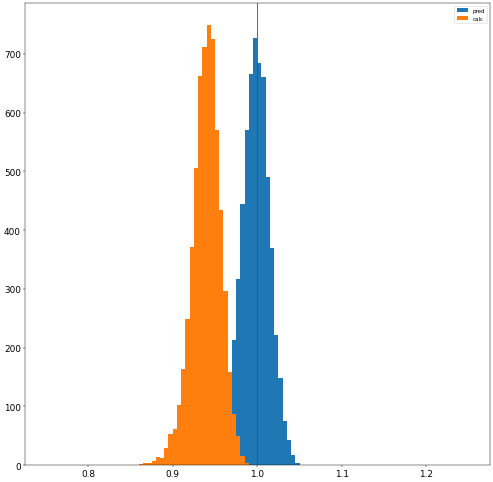

batches for test: 61
test loss: 13.885853063864786
calib weights: Parameter containing:
tensor([1.1560, 1.1661, 1.1759, 1.0867, 1.0694, 1.0863, 1.0332, 1.0972, 1.0423,
        1.0612, 1.0013, 1.0436, 1.0534, 1.0514, 1.0389, 1.1107, 1.0668, 1.1544,
        1.1121, 1.1702, 0.9428, 1.0268, 0.9286, 1.2027, 1.0161, 1.3066, 1.0884,
        2.2178], device='cuda:1', requires_grad=True)
new best test loss: 13.885853063864786
epoch: 71


100%|██████████| 121/121 [00:00<00:00, 516.47it/s]


batches for train: 121
train loss: 13.486446719524288


100%|██████████| 61/61 [00:00<00:00, 154.14it/s]


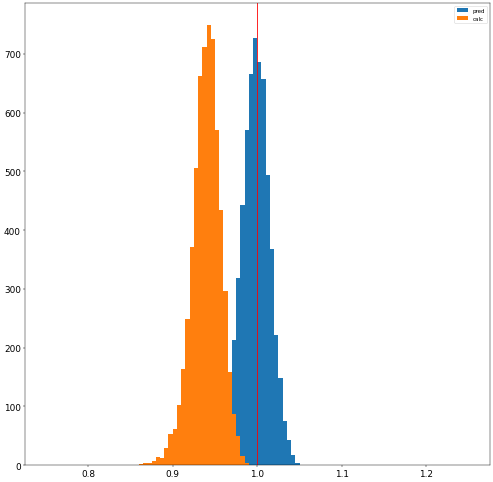

batches for test: 61
test loss: 13.885610001986144
calib weights: Parameter containing:
tensor([1.1557, 1.1660, 1.1762, 1.0865, 1.0693, 1.0864, 1.0330, 1.0975, 1.0422,
        1.0614, 1.0011, 1.0436, 1.0535, 1.0514, 1.0387, 1.1109, 1.0666, 1.1547,
        1.1121, 1.1706, 0.9422, 1.0265, 0.9282, 1.2029, 1.0155, 1.3069, 1.0874,
        2.2269], device='cuda:1', requires_grad=True)
new best test loss: 13.885610001986144
epoch: 72


100%|██████████| 121/121 [00:00<00:00, 536.22it/s]


batches for train: 121
train loss: 13.486441147228904


100%|██████████| 61/61 [00:00<00:00, 155.96it/s]


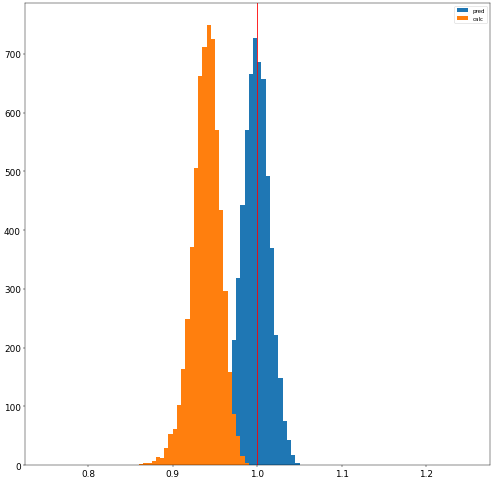

batches for test: 61
test loss: 13.885381557902353
calib weights: Parameter containing:
tensor([1.1554, 1.1660, 1.1766, 1.0864, 1.0692, 1.0865, 1.0328, 1.0978, 1.0421,
        1.0615, 1.0009, 1.0437, 1.0536, 1.0514, 1.0385, 1.1111, 1.0664, 1.1551,
        1.1121, 1.1710, 0.9418, 1.0263, 0.9279, 1.2031, 1.0148, 1.3072, 1.0864,
        2.2357], device='cuda:1', requires_grad=True)
new best test loss: 13.885381557902353
epoch: 73


100%|██████████| 121/121 [00:00<00:00, 490.44it/s]


batches for train: 121
train loss: 13.48643765567748


100%|██████████| 61/61 [00:00<00:00, 152.10it/s]


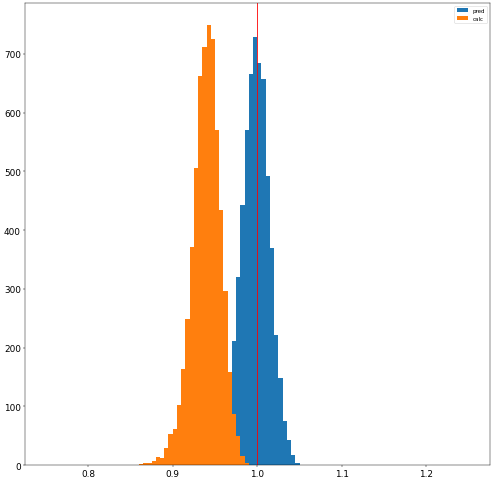

batches for test: 61
test loss: 13.885159977146836
calib weights: Parameter containing:
tensor([1.1551, 1.1659, 1.1769, 1.0863, 1.0692, 1.0867, 1.0325, 1.0981, 1.0420,
        1.0617, 1.0007, 1.0437, 1.0537, 1.0514, 1.0384, 1.1113, 1.0662, 1.1554,
        1.1121, 1.1714, 0.9413, 1.0261, 0.9275, 1.2032, 1.0143, 1.3074, 1.0855,
        2.2444], device='cuda:1', requires_grad=True)
new best test loss: 13.885159977146836
epoch: 74


100%|██████████| 121/121 [00:00<00:00, 497.64it/s]


batches for train: 121
train loss: 13.486434187770875


100%|██████████| 61/61 [00:00<00:00, 96.36it/s] 


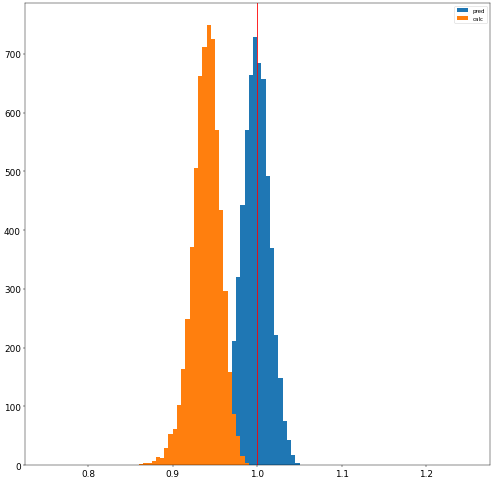

batches for test: 61
test loss: 13.884948136376552
calib weights: Parameter containing:
tensor([1.1548, 1.1659, 1.1772, 1.0862, 1.0691, 1.0868, 1.0323, 1.0984, 1.0419,
        1.0618, 1.0004, 1.0438, 1.0537, 1.0514, 1.0382, 1.1115, 1.0660, 1.1557,
        1.1121, 1.1717, 0.9408, 1.0259, 0.9272, 1.2034, 1.0137, 1.3076, 1.0845,
        2.2529], device='cuda:1', requires_grad=True)
new best test loss: 13.884948136376552
epoch: 75


100%|██████████| 121/121 [00:00<00:00, 538.97it/s]


batches for train: 121
train loss: 13.48643213067173


100%|██████████| 61/61 [00:00<00:00, 157.50it/s]


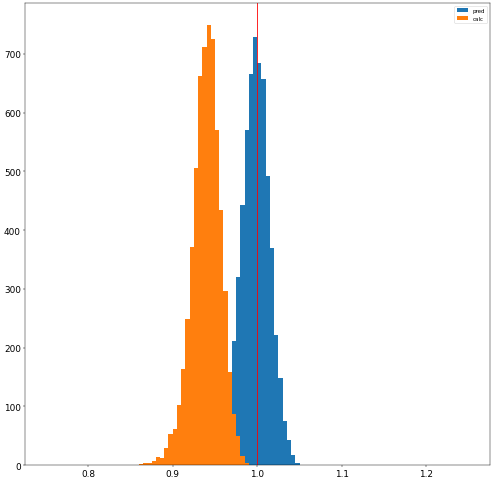

batches for test: 61
test loss: 13.884741048343846
calib weights: Parameter containing:
tensor([1.1546, 1.1658, 1.1775, 1.0860, 1.0690, 1.0869, 1.0321, 1.0987, 1.0419,
        1.0619, 1.0002, 1.0438, 1.0538, 1.0513, 1.0380, 1.1117, 1.0659, 1.1560,
        1.1120, 1.1721, 0.9404, 1.0257, 0.9269, 1.2036, 1.0131, 1.3078, 1.0836,
        2.2612], device='cuda:1', requires_grad=True)
new best test loss: 13.884741048343846
epoch: 76


100%|██████████| 121/121 [00:00<00:00, 466.43it/s]


batches for train: 121
train loss: 13.486431949394794


100%|██████████| 61/61 [00:00<00:00, 144.53it/s]


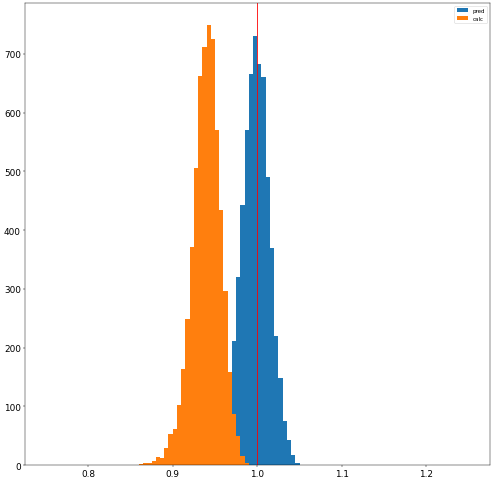

batches for test: 61
test loss: 13.884544497630635
calib weights: Parameter containing:
tensor([1.1543, 1.1657, 1.1778, 1.0859, 1.0689, 1.0870, 1.0318, 1.0989, 1.0418,
        1.0621, 1.0000, 1.0438, 1.0539, 1.0513, 1.0379, 1.1118, 1.0657, 1.1563,
        1.1120, 1.1724, 0.9400, 1.0255, 0.9266, 1.2037, 1.0126, 1.3080, 1.0827,
        2.2693], device='cuda:1', requires_grad=True)
new best test loss: 13.884544497630635
epoch: 77


100%|██████████| 121/121 [00:00<00:00, 527.50it/s]


batches for train: 121
train loss: 13.486431421327197


100%|██████████| 61/61 [00:00<00:00, 155.51it/s]


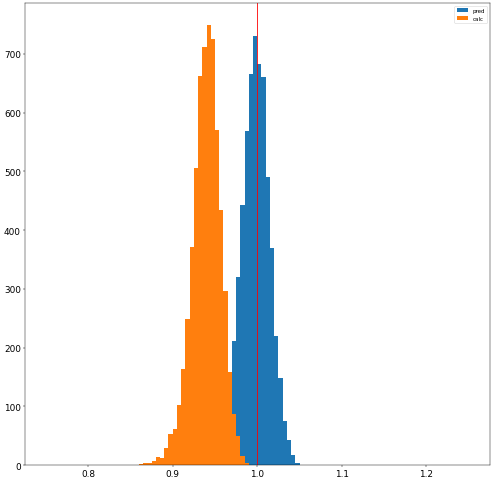

batches for test: 61
test loss: 13.884354935317743
calib weights: Parameter containing:
tensor([1.1540, 1.1657, 1.1781, 1.0858, 1.0688, 1.0871, 1.0316, 1.0992, 1.0417,
        1.0622, 0.9999, 1.0439, 1.0540, 1.0513, 1.0377, 1.1120, 1.0655, 1.1566,
        1.1120, 1.1727, 0.9396, 1.0254, 0.9263, 1.2038, 1.0121, 1.3082, 1.0818,
        2.2773], device='cuda:1', requires_grad=True)
new best test loss: 13.884354935317743
epoch: 78


100%|██████████| 121/121 [00:00<00:00, 449.45it/s]


batches for train: 121
train loss: 13.48643238288312


100%|██████████| 61/61 [00:00<00:00, 148.10it/s]


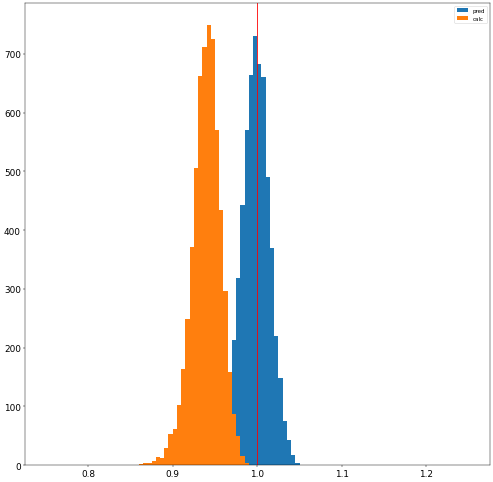

batches for test: 61
test loss: 13.884172861693335
calib weights: Parameter containing:
tensor([1.1538, 1.1656, 1.1784, 1.0857, 1.0688, 1.0873, 1.0314, 1.0994, 1.0416,
        1.0623, 0.9997, 1.0439, 1.0541, 1.0513, 1.0376, 1.1122, 1.0653, 1.1569,
        1.1120, 1.1730, 0.9392, 1.0252, 0.9260, 1.2039, 1.0115, 1.3083, 1.0809,
        2.2851], device='cuda:1', requires_grad=True)
new best test loss: 13.884172861693335
epoch: 79


100%|██████████| 121/121 [00:00<00:00, 528.57it/s]


batches for train: 121
train loss: 13.486434369047812


100%|██████████| 61/61 [00:00<00:00, 155.90it/s]


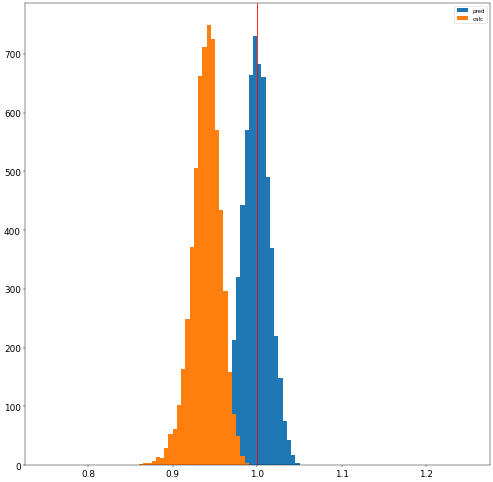

batches for test: 61
test loss: 13.883994180648052
calib weights: Parameter containing:
tensor([1.1535, 1.1656, 1.1787, 1.0856, 1.0687, 1.0874, 1.0312, 1.0997, 1.0416,
        1.0624, 0.9995, 1.0440, 1.0541, 1.0513, 1.0374, 1.1124, 1.0652, 1.1571,
        1.1120, 1.1733, 0.9389, 1.0250, 0.9258, 1.2041, 1.0110, 1.3084, 1.0800,
        2.2928], device='cuda:1', requires_grad=True)
new best test loss: 13.883994180648052


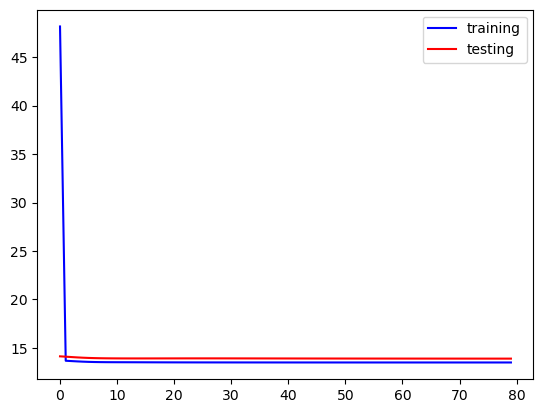

epoch: 80


100%|██████████| 121/121 [00:00<00:00, 472.28it/s]


batches for train: 121
train loss: 13.486437103965066


100%|██████████| 61/61 [00:00<00:00, 141.39it/s]


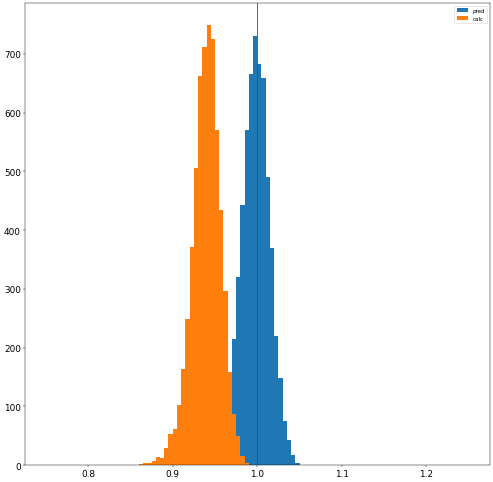

batches for test: 61
test loss: 13.883823801259526
calib weights: Parameter containing:
tensor([1.1532, 1.1655, 1.1790, 1.0855, 1.0686, 1.0875, 1.0310, 1.0999, 1.0415,
        1.0625, 0.9993, 1.0440, 1.0542, 1.0513, 1.0373, 1.1125, 1.0650, 1.1574,
        1.1120, 1.1736, 0.9385, 1.0249, 0.9255, 1.2042, 1.0106, 1.3085, 1.0792,
        2.3003], device='cuda:1', requires_grad=True)
new best test loss: 13.883823801259526
epoch: 81


100%|██████████| 121/121 [00:00<00:00, 477.10it/s]


batches for train: 121
train loss: 13.48643937386757


100%|██████████| 61/61 [00:00<00:00, 145.18it/s]


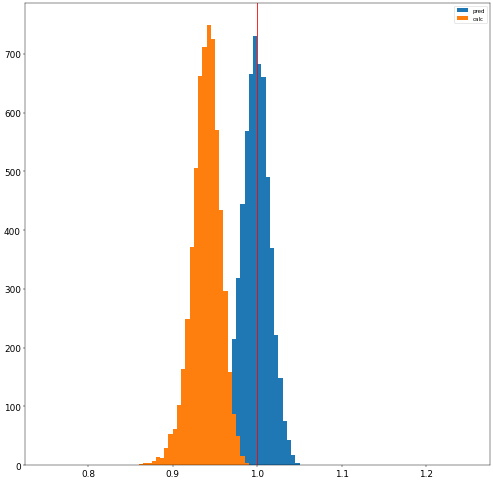

batches for test: 61
test loss: 13.883658596726715
calib weights: Parameter containing:
tensor([1.1530, 1.1654, 1.1792, 1.0854, 1.0686, 1.0876, 1.0308, 1.1002, 1.0414,
        1.0626, 0.9991, 1.0440, 1.0543, 1.0513, 1.0371, 1.1127, 1.0649, 1.1576,
        1.1120, 1.1739, 0.9382, 1.0247, 0.9253, 1.2042, 1.0101, 1.3086, 1.0783,
        2.3076], device='cuda:1', requires_grad=True)
new best test loss: 13.883658596726715
epoch: 82


100%|██████████| 121/121 [00:00<00:00, 491.70it/s]


batches for train: 121
train loss: 13.486443598408345


100%|██████████| 61/61 [00:00<00:00, 156.14it/s]


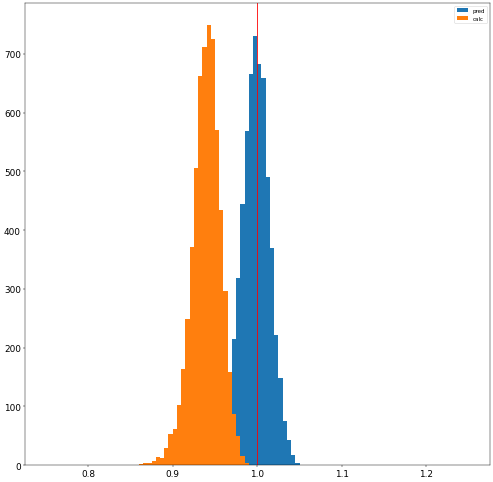

batches for test: 61
test loss: 13.883501787654689
calib weights: Parameter containing:
tensor([1.1528, 1.1654, 1.1795, 1.0853, 1.0685, 1.0877, 1.0306, 1.1004, 1.0413,
        1.0628, 0.9990, 1.0441, 1.0544, 1.0513, 1.0370, 1.1128, 1.0647, 1.1579,
        1.1119, 1.1742, 0.9379, 1.0246, 0.9251, 1.2043, 1.0096, 1.3087, 1.0775,
        2.3148], device='cuda:1', requires_grad=True)
new best test loss: 13.883501787654689
epoch: 83


100%|██████████| 121/121 [00:00<00:00, 518.93it/s]


batches for train: 121
train loss: 13.486448366779927


100%|██████████| 61/61 [00:00<00:00, 154.95it/s]


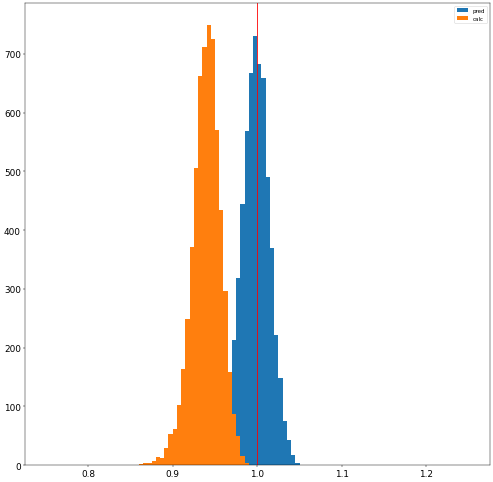

batches for test: 61
test loss: 13.88334915286205
calib weights: Parameter containing:
tensor([1.1525, 1.1653, 1.1797, 1.0852, 1.0684, 1.0878, 1.0304, 1.1006, 1.0413,
        1.0629, 0.9988, 1.0441, 1.0544, 1.0513, 1.0369, 1.1130, 1.0646, 1.1581,
        1.1119, 1.1744, 0.9376, 1.0245, 0.9248, 1.2044, 1.0092, 1.3087, 1.0767,
        2.3219], device='cuda:1', requires_grad=True)
new best test loss: 13.88334915286205
epoch: 84


100%|██████████| 121/121 [00:00<00:00, 527.68it/s]


batches for train: 121
train loss: 13.486452985400996


100%|██████████| 61/61 [00:00<00:00, 153.72it/s]


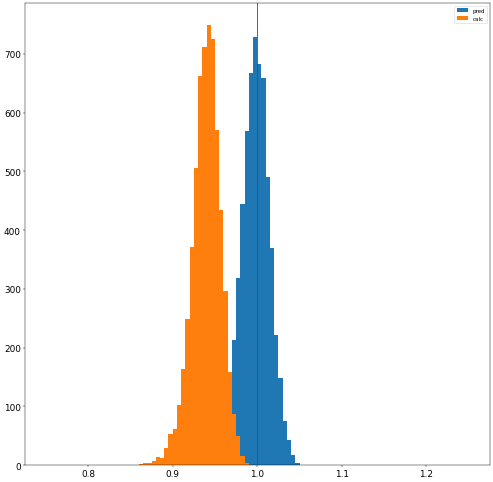

batches for test: 61
test loss: 13.883200879956854
calib weights: Parameter containing:
tensor([1.1523, 1.1652, 1.1800, 1.0851, 1.0684, 1.0879, 1.0302, 1.1008, 1.0412,
        1.0630, 0.9987, 1.0441, 1.0545, 1.0513, 1.0367, 1.1131, 1.0644, 1.1583,
        1.1119, 1.1747, 0.9373, 1.0243, 0.9246, 1.2045, 1.0087, 1.3088, 1.0759,
        2.3288], device='cuda:1', requires_grad=True)
new best test loss: 13.883200879956854
epoch: 85


100%|██████████| 121/121 [00:00<00:00, 529.91it/s]


batches for train: 121
train loss: 13.486457698601336


100%|██████████| 61/61 [00:00<00:00, 98.81it/s] 


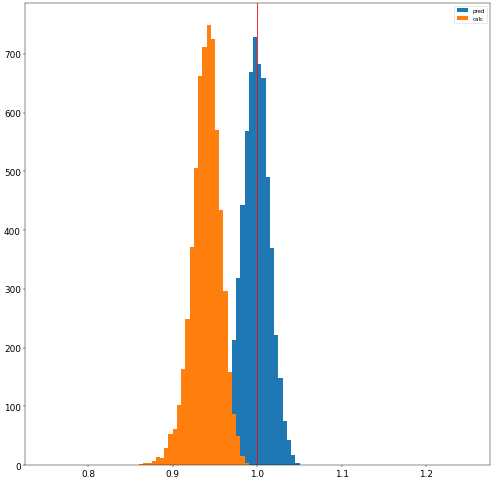

batches for test: 61
test loss: 13.883058047685466
calib weights: Parameter containing:
tensor([1.1521, 1.1652, 1.1802, 1.0850, 1.0683, 1.0880, 1.0301, 1.1010, 1.0411,
        1.0631, 0.9985, 1.0442, 1.0546, 1.0513, 1.0366, 1.1133, 1.0643, 1.1585,
        1.1119, 1.1749, 0.9370, 1.0242, 0.9244, 1.2045, 1.0083, 1.3088, 1.0751,
        2.3356], device='cuda:1', requires_grad=True)
new best test loss: 13.883058047685466
epoch: 86


100%|██████████| 121/121 [00:00<00:00, 533.58it/s]


batches for train: 121
train loss: 13.48646389354359


100%|██████████| 61/61 [00:00<00:00, 157.99it/s]


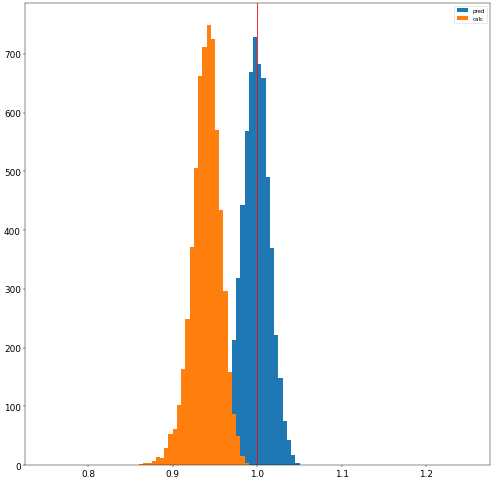

batches for test: 61
test loss: 13.88292024956375
calib weights: Parameter containing:
tensor([1.1519, 1.1651, 1.1804, 1.0849, 1.0683, 1.0881, 1.0299, 1.1012, 1.0411,
        1.0632, 0.9984, 1.0442, 1.0546, 1.0513, 1.0365, 1.1134, 1.0641, 1.1587,
        1.1118, 1.1752, 0.9368, 1.0241, 0.9243, 1.2046, 1.0079, 1.3088, 1.0743,
        2.3423], device='cuda:1', requires_grad=True)
new best test loss: 13.88292024956375
epoch: 87


100%|██████████| 121/121 [00:00<00:00, 528.70it/s]


batches for train: 121
train loss: 13.486470395868475


100%|██████████| 61/61 [00:00<00:00, 157.97it/s]


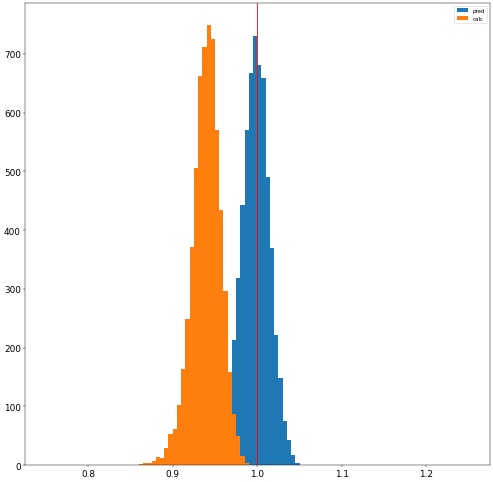

batches for test: 61
test loss: 13.882785937825187
calib weights: Parameter containing:
tensor([1.1517, 1.1650, 1.1807, 1.0849, 1.0682, 1.0882, 1.0297, 1.1014, 1.0410,
        1.0633, 0.9982, 1.0442, 1.0547, 1.0513, 1.0364, 1.1135, 1.0640, 1.1589,
        1.1118, 1.1754, 0.9365, 1.0240, 0.9241, 1.2047, 1.0075, 1.3088, 1.0736,
        2.3488], device='cuda:1', requires_grad=True)
new best test loss: 13.882785937825187
epoch: 88


100%|██████████| 121/121 [00:00<00:00, 539.96it/s]


batches for train: 121
train loss: 13.486476062743131


100%|██████████| 61/61 [00:00<00:00, 158.01it/s]


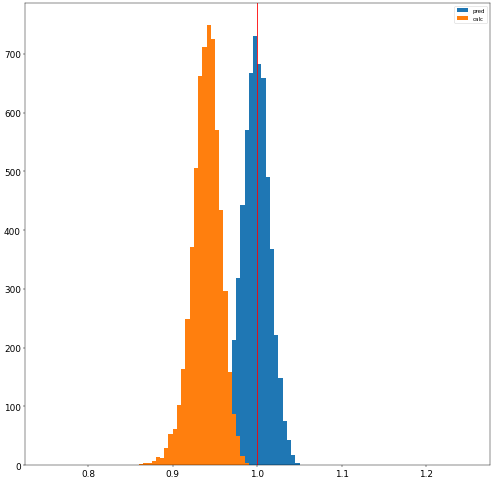

batches for test: 61
test loss: 13.882655487685907
calib weights: Parameter containing:
tensor([1.1515, 1.1650, 1.1809, 1.0848, 1.0682, 1.0883, 1.0295, 1.1016, 1.0409,
        1.0634, 0.9981, 1.0443, 1.0548, 1.0513, 1.0362, 1.1137, 1.0638, 1.1591,
        1.1118, 1.1756, 0.9363, 1.0239, 0.9239, 1.2047, 1.0071, 1.3088, 1.0728,
        2.3552], device='cuda:1', requires_grad=True)
new best test loss: 13.882655487685907
epoch: 89


100%|██████████| 121/121 [00:00<00:00, 527.70it/s]


batches for train: 121
train loss: 13.486484559114315


100%|██████████| 61/61 [00:00<00:00, 156.35it/s]


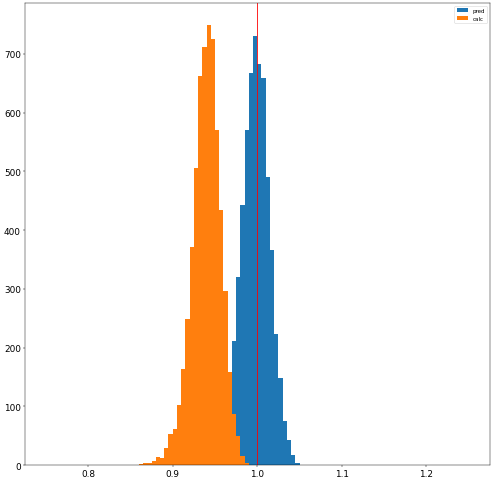

batches for test: 61
test loss: 13.882531025370614
calib weights: Parameter containing:
tensor([1.1513, 1.1649, 1.1811, 1.0847, 1.0681, 1.0884, 1.0294, 1.1018, 1.0409,
        1.0634, 0.9980, 1.0443, 1.0548, 1.0513, 1.0361, 1.1138, 1.0637, 1.1593,
        1.1118, 1.1758, 0.9360, 1.0238, 0.9237, 1.2047, 1.0067, 1.3087, 1.0721,
        2.3615], device='cuda:1', requires_grad=True)
new best test loss: 13.882531025370614


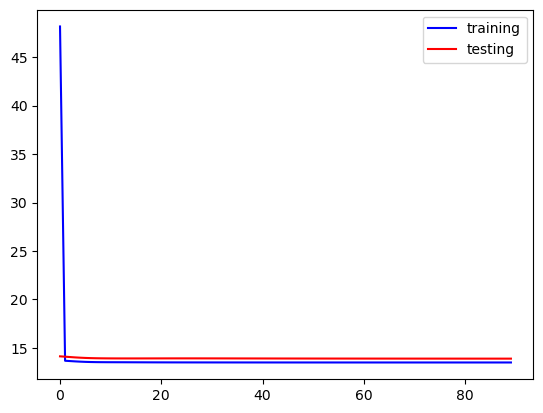

epoch: 90


100%|██████████| 121/121 [00:00<00:00, 532.59it/s]


batches for train: 121
train loss: 13.486490572779632


100%|██████████| 61/61 [00:00<00:00, 155.97it/s]


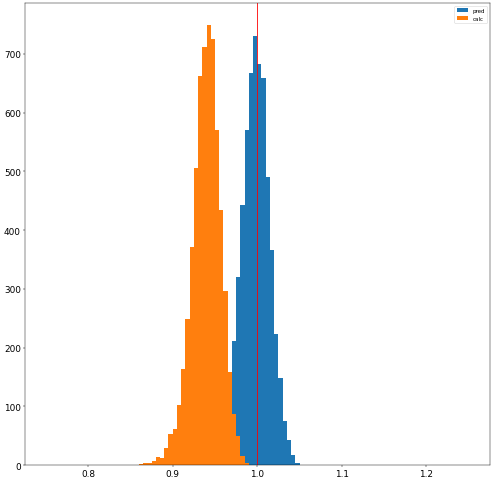

batches for test: 61
test loss: 13.882411722277032
calib weights: Parameter containing:
tensor([1.1511, 1.1649, 1.1813, 1.0846, 1.0681, 1.0885, 1.0292, 1.1020, 1.0408,
        1.0635, 0.9978, 1.0443, 1.0549, 1.0513, 1.0360, 1.1139, 1.0636, 1.1595,
        1.1117, 1.1760, 0.9358, 1.0237, 0.9236, 1.2048, 1.0064, 1.3087, 1.0714,
        2.3676], device='cuda:1', requires_grad=True)
new best test loss: 13.882411722277032
epoch: 91


100%|██████████| 121/121 [00:00<00:00, 532.28it/s]


batches for train: 121
train loss: 13.48649847803037


100%|██████████| 61/61 [00:00<00:00, 157.48it/s]


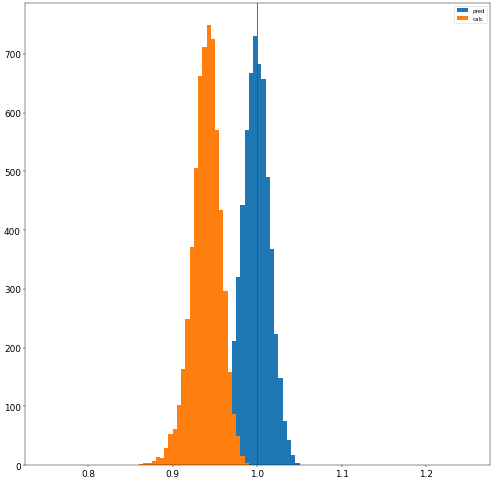

batches for test: 61
test loss: 13.882294029485983
calib weights: Parameter containing:
tensor([1.1509, 1.1648, 1.1815, 1.0845, 1.0680, 1.0886, 1.0291, 1.1022, 1.0407,
        1.0636, 0.9977, 1.0444, 1.0549, 1.0513, 1.0359, 1.1140, 1.0634, 1.1597,
        1.1117, 1.1762, 0.9356, 1.0236, 0.9234, 1.2048, 1.0060, 1.3086, 1.0707,
        2.3736], device='cuda:1', requires_grad=True)
new best test loss: 13.882294029485983
epoch: 92


100%|██████████| 121/121 [00:00<00:00, 543.77it/s]


batches for train: 121
train loss: 13.48650642268914


100%|██████████| 61/61 [00:00<00:00, 158.36it/s]


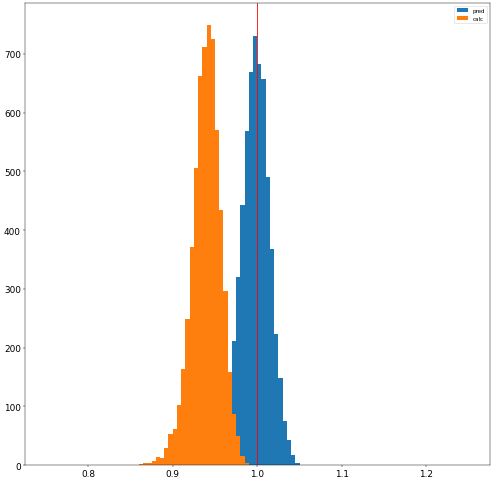

batches for test: 61
test loss: 13.882182387054943
calib weights: Parameter containing:
tensor([1.1507, 1.1647, 1.1817, 1.0845, 1.0680, 1.0887, 1.0289, 1.1023, 1.0407,
        1.0637, 0.9976, 1.0444, 1.0550, 1.0513, 1.0358, 1.1142, 1.0633, 1.1599,
        1.1117, 1.1764, 0.9354, 1.0235, 0.9233, 1.2048, 1.0057, 1.3086, 1.0700,
        2.3795], device='cuda:1', requires_grad=True)
new best test loss: 13.882182387054943
epoch: 93


100%|██████████| 121/121 [00:00<00:00, 540.18it/s]


batches for train: 121
train loss: 13.486514335821482


100%|██████████| 61/61 [00:00<00:00, 157.73it/s]


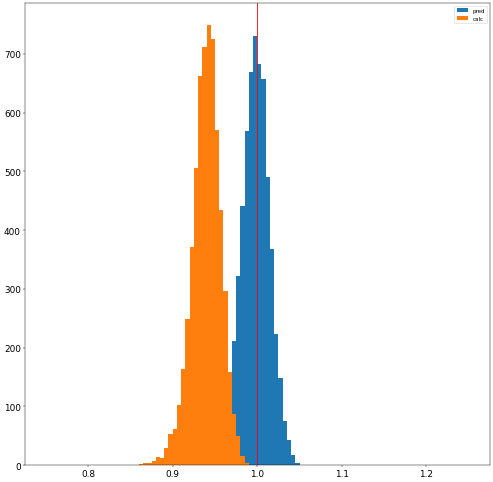

batches for test: 61
test loss: 13.88207091659796
calib weights: Parameter containing:
tensor([1.1506, 1.1647, 1.1819, 1.0844, 1.0679, 1.0888, 1.0288, 1.1025, 1.0406,
        1.0638, 0.9975, 1.0444, 1.0551, 1.0513, 1.0357, 1.1143, 1.0632, 1.1600,
        1.1117, 1.1766, 0.9352, 1.0234, 0.9231, 1.2049, 1.0053, 1.3085, 1.0693,
        2.3853], device='cuda:1', requires_grad=True)
new best test loss: 13.88207091659796
epoch: 94


100%|██████████| 121/121 [00:00<00:00, 539.17it/s]


batches for train: 121
train loss: 13.486523391786685


100%|██████████| 61/61 [00:00<00:00, 158.74it/s]


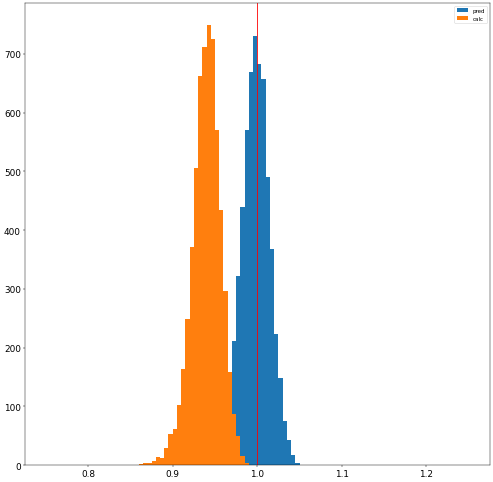

batches for test: 61
test loss: 13.881964933676798
calib weights: Parameter containing:
tensor([1.1504, 1.1646, 1.1821, 1.0843, 1.0679, 1.0889, 1.0286, 1.1027, 1.0405,
        1.0639, 0.9974, 1.0445, 1.0551, 1.0513, 1.0356, 1.1144, 1.0631, 1.1602,
        1.1116, 1.1768, 0.9350, 1.0233, 0.9230, 1.2049, 1.0050, 1.3085, 1.0687,
        2.3910], device='cuda:1', requires_grad=True)
new best test loss: 13.881964933676798
epoch: 95


100%|██████████| 121/121 [00:00<00:00, 530.56it/s]


batches for train: 121
train loss: 13.48653122610297


100%|██████████| 61/61 [00:00<00:00, 158.01it/s]


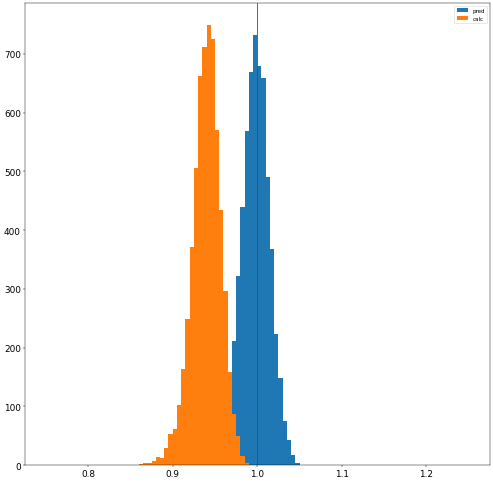

batches for test: 61
test loss: 13.881860045135998
calib weights: Parameter containing:
tensor([1.1502, 1.1645, 1.1823, 1.0842, 1.0678, 1.0890, 1.0285, 1.1028, 1.0405,
        1.0639, 0.9973, 1.0445, 1.0552, 1.0513, 1.0355, 1.1145, 1.0630, 1.1604,
        1.1116, 1.1770, 0.9348, 1.0232, 0.9229, 1.2049, 1.0047, 1.3084, 1.0680,
        2.3965], device='cuda:1', requires_grad=True)
new best test loss: 13.881860045135998
epoch: 96


100%|██████████| 121/121 [00:00<00:00, 529.66it/s]


batches for train: 121
train loss: 13.486539549078824


100%|██████████| 61/61 [00:00<00:00, 99.77it/s] 


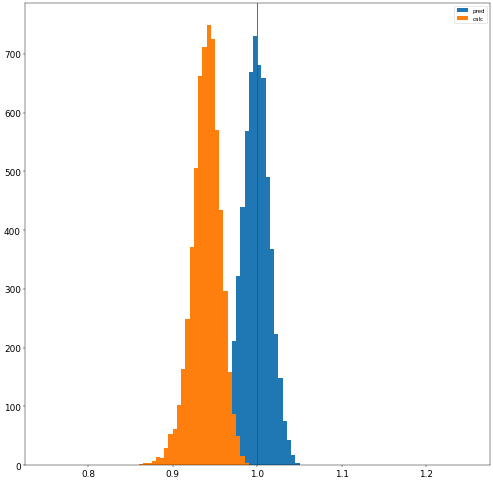

batches for test: 61
test loss: 13.88176223879955
calib weights: Parameter containing:
tensor([1.1501, 1.1645, 1.1824, 1.0842, 1.0678, 1.0891, 1.0283, 1.1030, 1.0404,
        1.0640, 0.9972, 1.0445, 1.0552, 1.0513, 1.0354, 1.1146, 1.0629, 1.1605,
        1.1116, 1.1771, 0.9346, 1.0231, 0.9228, 1.2049, 1.0044, 1.3083, 1.0674,
        2.4020], device='cuda:1', requires_grad=True)
new best test loss: 13.88176223879955
epoch: 97


100%|██████████| 121/121 [00:00<00:00, 529.18it/s]


batches for train: 121
train loss: 13.486548825728992


100%|██████████| 61/61 [00:00<00:00, 155.54it/s]


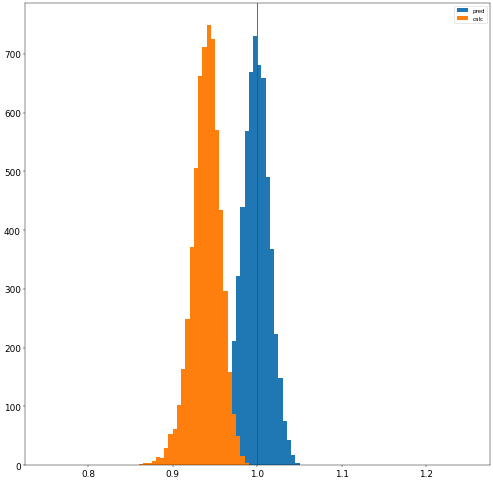

batches for test: 61
test loss: 13.881668794350546
calib weights: Parameter containing:
tensor([1.1499, 1.1644, 1.1826, 1.0841, 1.0678, 1.0891, 1.0282, 1.1032, 1.0404,
        1.0641, 0.9970, 1.0445, 1.0553, 1.0513, 1.0353, 1.1147, 1.0627, 1.1607,
        1.1116, 1.1773, 0.9345, 1.0231, 0.9226, 1.2049, 1.0041, 1.3082, 1.0667,
        2.4073], device='cuda:1', requires_grad=True)
new best test loss: 13.881668794350546
epoch: 98


100%|██████████| 121/121 [00:00<00:00, 531.16it/s]


batches for train: 121
train loss: 13.48655630537301


100%|██████████| 61/61 [00:00<00:00, 156.64it/s]


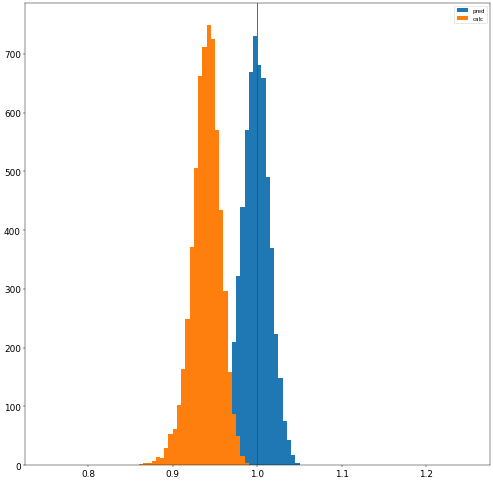

batches for test: 61
test loss: 13.881573677062988
calib weights: Parameter containing:
tensor([1.1498, 1.1643, 1.1828, 1.0840, 1.0677, 1.0892, 1.0281, 1.1033, 1.0403,
        1.0642, 0.9969, 1.0446, 1.0553, 1.0513, 1.0353, 1.1148, 1.0626, 1.1608,
        1.1115, 1.1774, 0.9343, 1.0230, 0.9225, 1.2049, 1.0038, 1.3081, 1.0661,
        2.4125], device='cuda:1', requires_grad=True)
new best test loss: 13.881573677062988
epoch: 99


100%|██████████| 121/121 [00:00<00:00, 531.84it/s]


batches for train: 121
train loss: 13.486567308094877


100%|██████████| 61/61 [00:00<00:00, 157.27it/s]


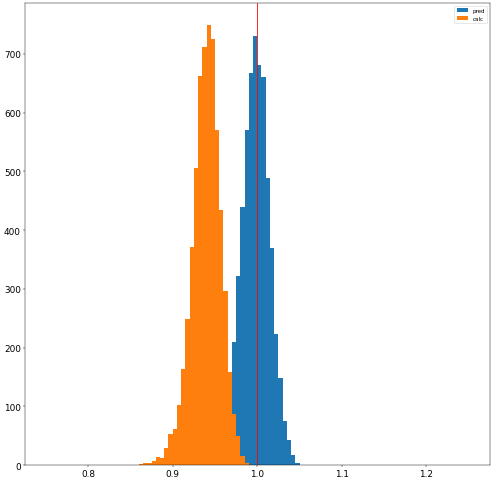

batches for test: 61
test loss: 13.881484391259365
calib weights: Parameter containing:
tensor([1.1496, 1.1643, 1.1829, 1.0840, 1.0677, 1.0893, 1.0279, 1.1035, 1.0403,
        1.0642, 0.9968, 1.0446, 1.0554, 1.0513, 1.0352, 1.1149, 1.0625, 1.1610,
        1.1115, 1.1776, 0.9342, 1.0229, 0.9224, 1.2049, 1.0035, 1.3080, 1.0655,
        2.4177], device='cuda:1', requires_grad=True)
new best test loss: 13.881484391259365


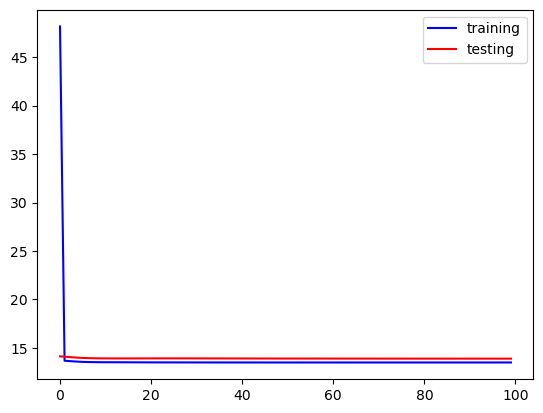

epoch: 100


100%|██████████| 121/121 [00:00<00:00, 531.77it/s]


batches for train: 121
train loss: 13.48657410203918


100%|██████████| 61/61 [00:00<00:00, 157.40it/s]


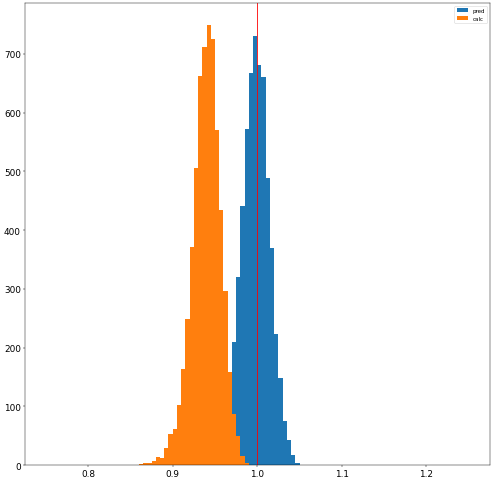

batches for test: 61
test loss: 13.881396559418224
calib weights: Parameter containing:
tensor([1.1495, 1.1642, 1.1831, 1.0839, 1.0677, 1.0894, 1.0278, 1.1036, 1.0402,
        1.0643, 0.9968, 1.0446, 1.0554, 1.0513, 1.0351, 1.1150, 1.0624, 1.1611,
        1.1115, 1.1777, 0.9340, 1.0229, 0.9223, 1.2049, 1.0032, 1.3079, 1.0649,
        2.4227], device='cuda:1', requires_grad=True)
new best test loss: 13.881396559418224
epoch: 101


100%|██████████| 121/121 [00:00<00:00, 534.25it/s]


batches for train: 121
train loss: 13.486583024017081


100%|██████████| 61/61 [00:00<00:00, 157.21it/s]


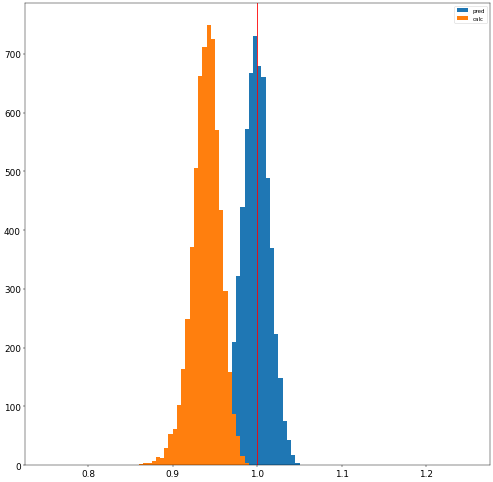

batches for test: 61
test loss: 13.881312464104324
calib weights: Parameter containing:
tensor([1.1493, 1.1642, 1.1833, 1.0838, 1.0676, 1.0895, 1.0277, 1.1037, 1.0402,
        1.0644, 0.9967, 1.0446, 1.0555, 1.0513, 1.0350, 1.1151, 1.0623, 1.1612,
        1.1114, 1.1779, 0.9339, 1.0228, 0.9222, 1.2049, 1.0029, 1.3078, 1.0644,
        2.4276], device='cuda:1', requires_grad=True)
new best test loss: 13.881312464104324
epoch: 102


100%|██████████| 121/121 [00:00<00:00, 540.98it/s]


batches for train: 121
train loss: 13.486592883906088


100%|██████████| 61/61 [00:00<00:00, 157.93it/s]


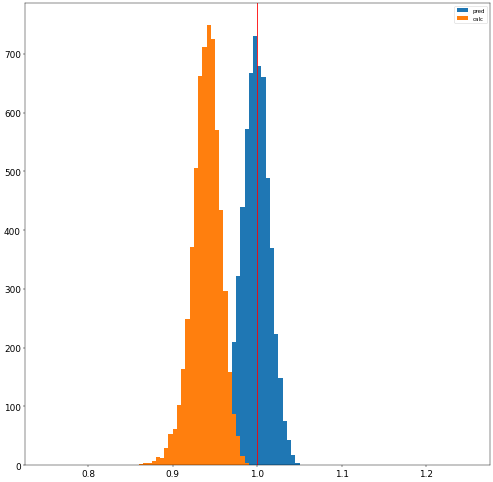

batches for test: 61
test loss: 13.881229900922932
calib weights: Parameter containing:
tensor([1.1492, 1.1641, 1.1834, 1.0838, 1.0676, 1.0895, 1.0276, 1.1039, 1.0401,
        1.0644, 0.9966, 1.0447, 1.0555, 1.0513, 1.0349, 1.1152, 1.0622, 1.1613,
        1.1114, 1.1780, 0.9337, 1.0227, 0.9221, 1.2049, 1.0027, 1.3077, 1.0638,
        2.4325], device='cuda:1', requires_grad=True)
new best test loss: 13.881229900922932
epoch: 103


100%|██████████| 121/121 [00:00<00:00, 533.84it/s]


batches for train: 121
train loss: 13.48660213691144


100%|██████████| 61/61 [00:00<00:00, 158.48it/s]


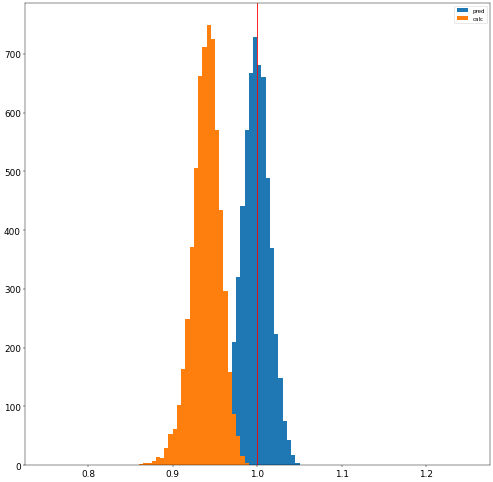

batches for test: 61
test loss: 13.881148650997975
calib weights: Parameter containing:
tensor([1.1491, 1.1641, 1.1836, 1.0837, 1.0676, 1.0896, 1.0274, 1.1040, 1.0401,
        1.0645, 0.9965, 1.0447, 1.0556, 1.0513, 1.0349, 1.1152, 1.0621, 1.1615,
        1.1114, 1.1781, 0.9336, 1.0227, 0.9220, 1.2049, 1.0024, 1.3075, 1.0632,
        2.4372], device='cuda:1', requires_grad=True)
new best test loss: 13.881148650997975
epoch: 104


100%|██████████| 121/121 [00:00<00:00, 544.98it/s]


batches for train: 121
train loss: 13.486611090415765


100%|██████████| 61/61 [00:00<00:00, 157.94it/s]


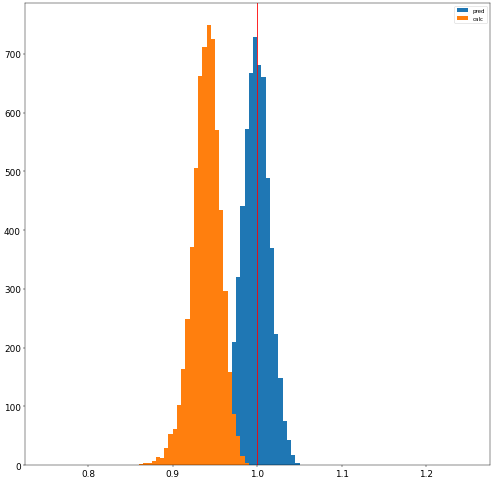

batches for test: 61
test loss: 13.881072091274573
calib weights: Parameter containing:
tensor([1.1489, 1.1640, 1.1837, 1.0837, 1.0675, 1.0897, 1.0273, 1.1041, 1.0400,
        1.0645, 0.9964, 1.0447, 1.0556, 1.0513, 1.0348, 1.1153, 1.0620, 1.1616,
        1.1114, 1.1783, 0.9335, 1.0226, 0.9219, 1.2049, 1.0022, 1.3074, 1.0627,
        2.4418], device='cuda:1', requires_grad=True)
new best test loss: 13.881072091274573
epoch: 105


100%|██████████| 121/121 [00:00<00:00, 538.29it/s]


batches for train: 121
train loss: 13.486620461645206


100%|██████████| 61/61 [00:00<00:00, 158.09it/s]


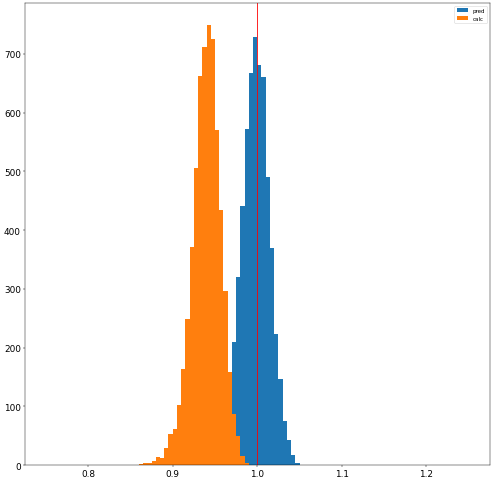

batches for test: 61
test loss: 13.880995594087194
calib weights: Parameter containing:
tensor([1.1488, 1.1639, 1.1838, 1.0836, 1.0675, 1.0898, 1.0272, 1.1043, 1.0400,
        1.0646, 0.9963, 1.0447, 1.0556, 1.0513, 1.0347, 1.1154, 1.0620, 1.1617,
        1.1113, 1.1784, 0.9334, 1.0226, 0.9218, 1.2049, 1.0019, 1.3073, 1.0622,
        2.4464], device='cuda:1', requires_grad=True)
new best test loss: 13.880995594087194
epoch: 106


100%|██████████| 121/121 [00:00<00:00, 531.69it/s]


batches for train: 121
train loss: 13.48662999838837


100%|██████████| 61/61 [00:00<00:00, 158.04it/s]


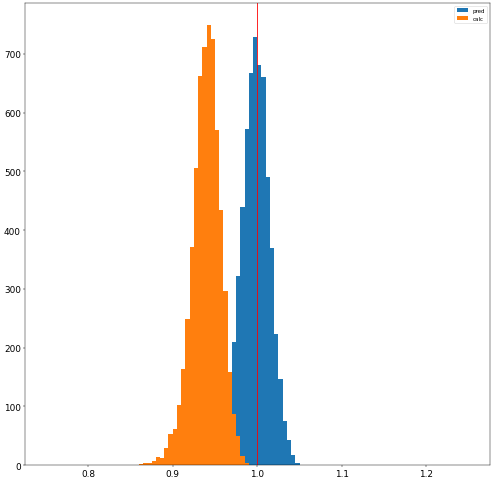

batches for test: 61
test loss: 13.880922380040904
calib weights: Parameter containing:
tensor([1.1487, 1.1639, 1.1840, 1.0836, 1.0675, 1.0898, 1.0271, 1.1044, 1.0399,
        1.0647, 0.9962, 1.0448, 1.0557, 1.0513, 1.0346, 1.1155, 1.0619, 1.1618,
        1.1113, 1.1785, 0.9333, 1.0225, 0.9218, 1.2049, 1.0017, 1.3072, 1.0616,
        2.4508], device='cuda:1', requires_grad=True)
new best test loss: 13.880922380040904
epoch: 107


100%|██████████| 121/121 [00:00<00:00, 531.66it/s]


batches for train: 121
train loss: 13.48663929080175


100%|██████████| 61/61 [00:00<00:00, 158.43it/s]


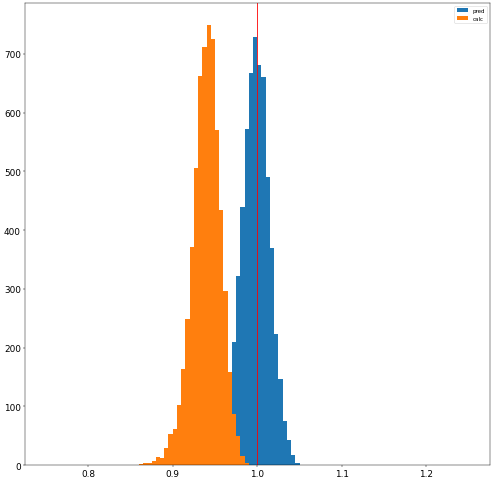

batches for test: 61
test loss: 13.880851260951308
calib weights: Parameter containing:
tensor([1.1486, 1.1638, 1.1841, 1.0835, 1.0674, 1.0899, 1.0270, 1.1045, 1.0399,
        1.0647, 0.9962, 1.0448, 1.0557, 1.0513, 1.0346, 1.1156, 1.0618, 1.1619,
        1.1113, 1.1786, 0.9332, 1.0225, 0.9217, 1.2049, 1.0015, 1.3070, 1.0611,
        2.4552], device='cuda:1', requires_grad=True)
new best test loss: 13.880851260951308
epoch: 108


100%|██████████| 121/121 [00:00<00:00, 546.24it/s]


batches for train: 121
train loss: 13.486647897515414


100%|██████████| 61/61 [00:00<00:00, 157.78it/s]


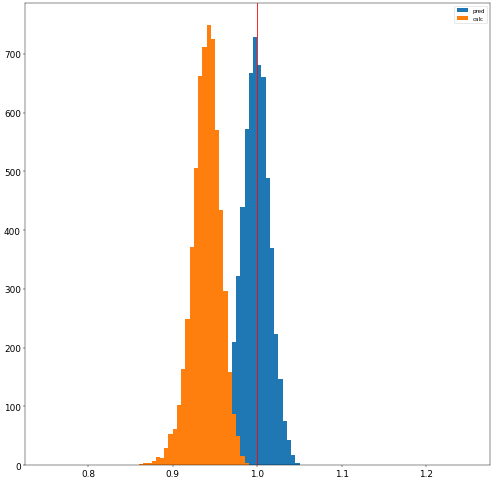

batches for test: 61
test loss: 13.880784050363008
calib weights: Parameter containing:
tensor([1.1485, 1.1638, 1.1842, 1.0835, 1.0674, 1.0900, 1.0269, 1.1046, 1.0398,
        1.0648, 0.9961, 1.0448, 1.0558, 1.0513, 1.0345, 1.1156, 1.0617, 1.1620,
        1.1113, 1.1787, 0.9330, 1.0224, 0.9216, 1.2049, 1.0012, 1.3069, 1.0606,
        2.4595], device='cuda:1', requires_grad=True)
new best test loss: 13.880784050363008
epoch: 109


100%|██████████| 121/121 [00:00<00:00, 546.26it/s]


batches for train: 121
train loss: 13.48665808843187


100%|██████████| 61/61 [00:00<00:00, 157.54it/s]


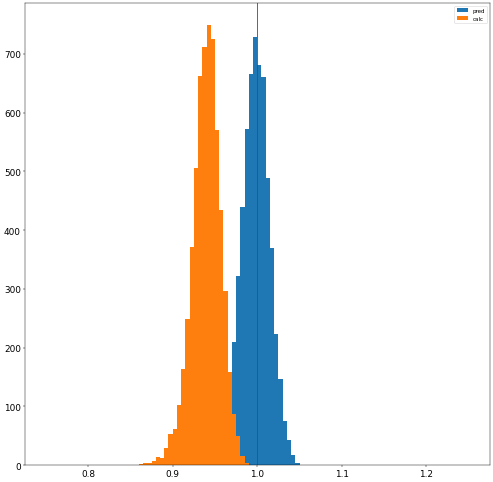

batches for test: 61
test loss: 13.8807171055528
calib weights: Parameter containing:
tensor([1.1484, 1.1637, 1.1844, 1.0834, 1.0674, 1.0900, 1.0268, 1.1047, 1.0398,
        1.0648, 0.9960, 1.0448, 1.0558, 1.0513, 1.0344, 1.1157, 1.0616, 1.1621,
        1.1112, 1.1788, 0.9329, 1.0224, 0.9215, 1.2049, 1.0010, 1.3068, 1.0601,
        2.4637], device='cuda:1', requires_grad=True)
new best test loss: 13.8807171055528


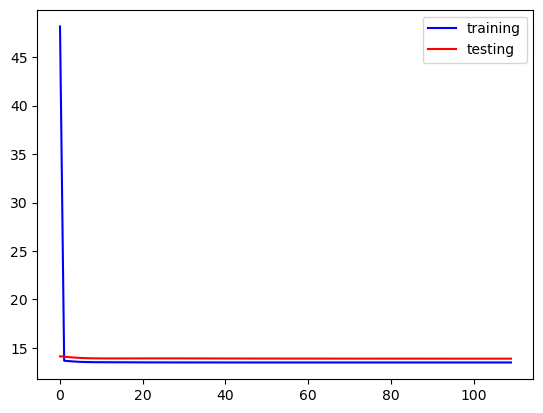

epoch: 110


100%|██████████| 121/121 [00:00<00:00, 542.68it/s]


batches for train: 121
train loss: 13.48666682125123


100%|██████████| 61/61 [00:00<00:00, 158.06it/s]


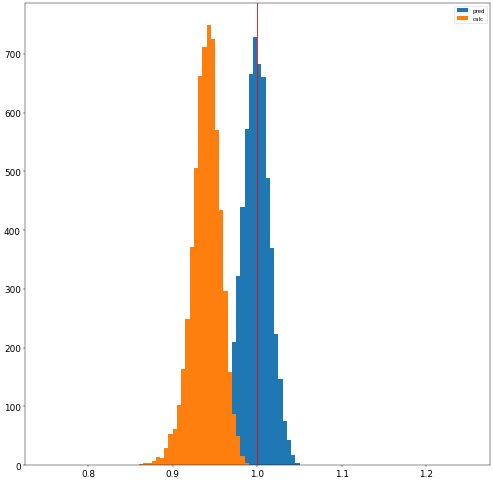

batches for test: 61
test loss: 13.88064950411437
calib weights: Parameter containing:
tensor([1.1483, 1.1637, 1.1845, 1.0833, 1.0674, 1.0901, 1.0267, 1.1048, 1.0397,
        1.0649, 0.9959, 1.0448, 1.0558, 1.0513, 1.0344, 1.1158, 1.0615, 1.1622,
        1.1112, 1.1789, 0.9329, 1.0223, 0.9215, 1.2048, 1.0008, 1.3066, 1.0596,
        2.4678], device='cuda:1', requires_grad=True)
new best test loss: 13.88064950411437
epoch: 111


100%|██████████| 121/121 [00:00<00:00, 533.30it/s]


batches for train: 121
train loss: 13.486676216125488


100%|██████████| 61/61 [00:00<00:00, 99.31it/s] 


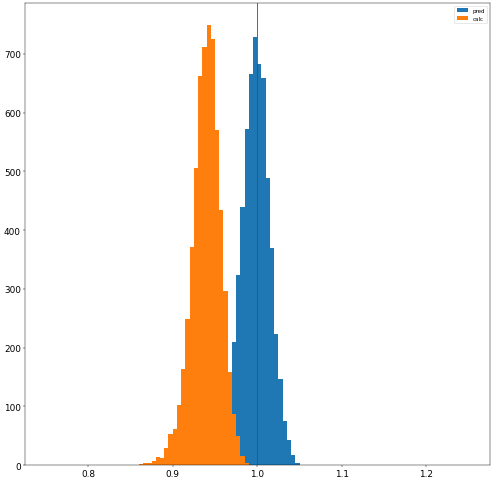

batches for test: 61
test loss: 13.880588187546026
calib weights: Parameter containing:
tensor([1.1482, 1.1636, 1.1846, 1.0833, 1.0673, 1.0902, 1.0266, 1.1049, 1.0397,
        1.0649, 0.9959, 1.0449, 1.0559, 1.0513, 1.0343, 1.1158, 1.0615, 1.1623,
        1.1112, 1.1790, 0.9328, 1.0223, 0.9214, 1.2048, 1.0006, 1.3065, 1.0592,
        2.4719], device='cuda:1', requires_grad=True)
new best test loss: 13.880588187546026
epoch: 112


100%|██████████| 121/121 [00:00<00:00, 529.10it/s]


batches for train: 121
train loss: 13.486686422805155


100%|██████████| 61/61 [00:00<00:00, 158.13it/s]


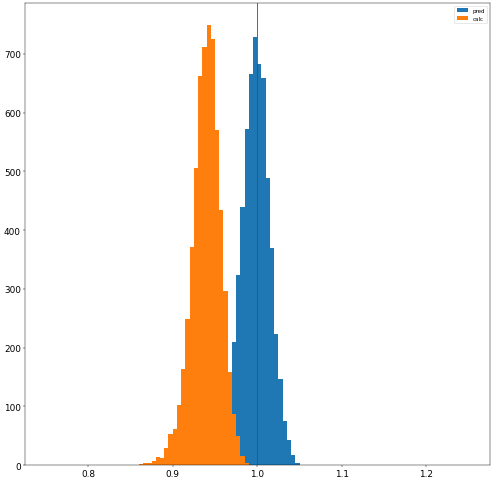

batches for test: 61
test loss: 13.880529075372415
calib weights: Parameter containing:
tensor([1.1481, 1.1636, 1.1847, 1.0833, 1.0673, 1.0902, 1.0265, 1.1051, 1.0396,
        1.0650, 0.9958, 1.0449, 1.0559, 1.0513, 1.0343, 1.1159, 1.0614, 1.1624,
        1.1112, 1.1791, 0.9327, 1.0222, 0.9213, 1.2048, 1.0004, 1.3063, 1.0587,
        2.4758], device='cuda:1', requires_grad=True)
new best test loss: 13.880529075372415
epoch: 113


100%|██████████| 121/121 [00:00<00:00, 534.89it/s]


batches for train: 121
train loss: 13.486695486651964


100%|██████████| 61/61 [00:00<00:00, 158.53it/s]


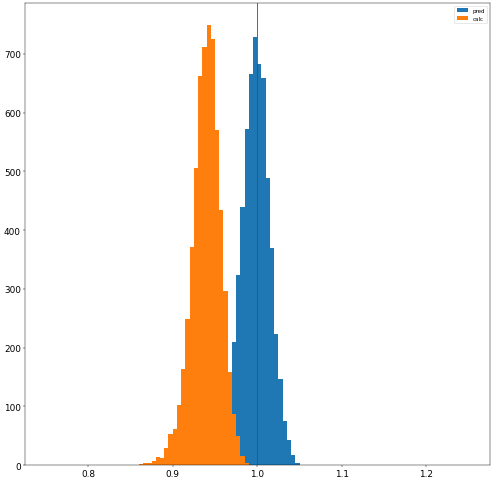

batches for test: 61
test loss: 13.880467649366034
calib weights: Parameter containing:
tensor([1.1480, 1.1635, 1.1848, 1.0832, 1.0673, 1.0903, 1.0264, 1.1052, 1.0396,
        1.0650, 0.9957, 1.0449, 1.0559, 1.0513, 1.0342, 1.1160, 1.0613, 1.1625,
        1.1111, 1.1792, 0.9326, 1.0222, 0.9213, 1.2048, 1.0002, 1.3062, 1.0583,
        2.4797], device='cuda:1', requires_grad=True)
new best test loss: 13.880467649366034
epoch: 114


100%|██████████| 121/121 [00:00<00:00, 531.87it/s]


batches for train: 121
train loss: 13.486704873644616


100%|██████████| 61/61 [00:00<00:00, 158.49it/s]


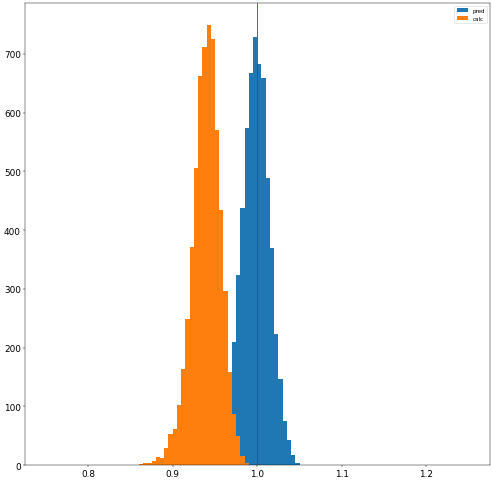

batches for test: 61
test loss: 13.880413540074082
calib weights: Parameter containing:
tensor([1.1479, 1.1634, 1.1849, 1.0832, 1.0673, 1.0904, 1.0263, 1.1053, 1.0395,
        1.0651, 0.9957, 1.0449, 1.0560, 1.0513, 1.0342, 1.1160, 1.0612, 1.1626,
        1.1111, 1.1793, 0.9325, 1.0221, 0.9212, 1.2048, 1.0000, 1.3060, 1.0578,
        2.4834], device='cuda:1', requires_grad=True)
new best test loss: 13.880413540074082
epoch: 115


100%|██████████| 121/121 [00:00<00:00, 531.61it/s]


batches for train: 121
train loss: 13.486712936527473


100%|██████████| 61/61 [00:00<00:00, 100.26it/s]


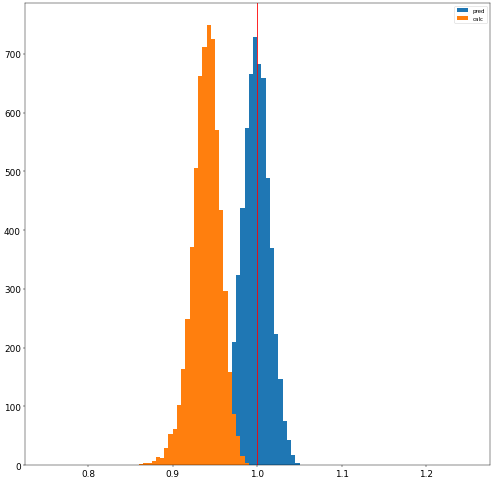

batches for test: 61
test loss: 13.880355381574788
calib weights: Parameter containing:
tensor([1.1478, 1.1634, 1.1851, 1.0831, 1.0673, 1.0904, 1.0262, 1.1054, 1.0395,
        1.0651, 0.9956, 1.0449, 1.0560, 1.0513, 1.0341, 1.1161, 1.0612, 1.1627,
        1.1111, 1.1794, 0.9324, 1.0221, 0.9211, 1.2047, 0.9998, 1.3059, 1.0574,
        2.4871], device='cuda:1', requires_grad=True)
new best test loss: 13.880355381574788
epoch: 116


100%|██████████| 121/121 [00:00<00:00, 538.25it/s]


batches for train: 121
train loss: 13.486722126479977


100%|██████████| 61/61 [00:00<00:00, 159.02it/s]


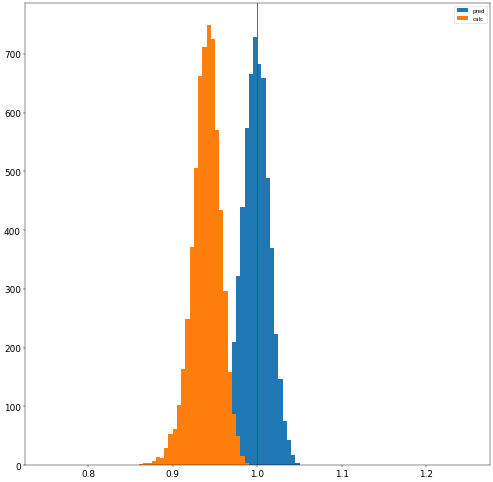

batches for test: 61
test loss: 13.880299318032186
calib weights: Parameter containing:
tensor([1.1477, 1.1633, 1.1852, 1.0831, 1.0672, 1.0905, 1.0261, 1.1054, 1.0395,
        1.0652, 0.9956, 1.0449, 1.0560, 1.0513, 1.0341, 1.1162, 1.0611, 1.1628,
        1.1111, 1.1795, 0.9323, 1.0221, 0.9211, 1.2047, 0.9997, 1.3057, 1.0570,
        2.4907], device='cuda:1', requires_grad=True)
new best test loss: 13.880299318032186
epoch: 117


100%|██████████| 121/121 [00:00<00:00, 550.12it/s]


batches for train: 121
train loss: 13.486730827772913


100%|██████████| 61/61 [00:00<00:00, 158.32it/s]


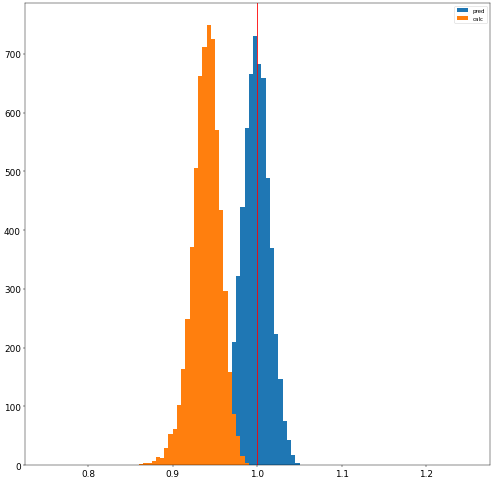

batches for test: 61
test loss: 13.88025064937404
calib weights: Parameter containing:
tensor([1.1477, 1.1633, 1.1853, 1.0830, 1.0672, 1.0905, 1.0260, 1.1055, 1.0394,
        1.0652, 0.9955, 1.0450, 1.0561, 1.0513, 1.0340, 1.1162, 1.0610, 1.1629,
        1.1110, 1.1796, 0.9323, 1.0220, 0.9210, 1.2047, 0.9995, 1.3056, 1.0565,
        2.4943], device='cuda:1', requires_grad=True)
new best test loss: 13.88025064937404
epoch: 118


100%|██████████| 121/121 [00:00<00:00, 533.79it/s]


batches for train: 121
train loss: 13.486739923146146


100%|██████████| 61/61 [00:00<00:00, 158.70it/s]


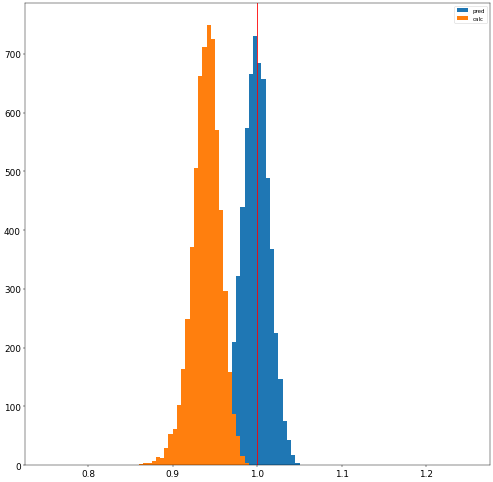

batches for test: 61
test loss: 13.880200354779353
calib weights: Parameter containing:
tensor([1.1476, 1.1632, 1.1854, 1.0830, 1.0672, 1.0906, 1.0260, 1.1056, 1.0394,
        1.0652, 0.9954, 1.0450, 1.0561, 1.0513, 1.0340, 1.1163, 1.0610, 1.1629,
        1.1110, 1.1797, 0.9322, 1.0220, 0.9210, 1.2047, 0.9993, 1.3055, 1.0561,
        2.4978], device='cuda:1', requires_grad=True)
new best test loss: 13.880200354779353
epoch: 119


100%|██████████| 121/121 [00:00<00:00, 545.23it/s]


batches for train: 121
train loss: 13.486748088489879


100%|██████████| 61/61 [00:00<00:00, 158.22it/s]


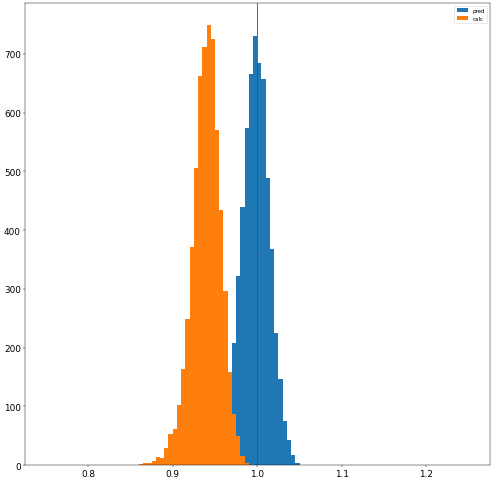

batches for test: 61
test loss: 13.880150294694744
calib weights: Parameter containing:
tensor([1.1475, 1.1632, 1.1855, 1.0829, 1.0672, 1.0906, 1.0259, 1.1057, 1.0394,
        1.0653, 0.9954, 1.0450, 1.0561, 1.0513, 1.0339, 1.1163, 1.0609, 1.1630,
        1.1110, 1.1797, 0.9321, 1.0220, 0.9209, 1.2046, 0.9992, 1.3053, 1.0557,
        2.5012], device='cuda:1', requires_grad=True)
new best test loss: 13.880150294694744


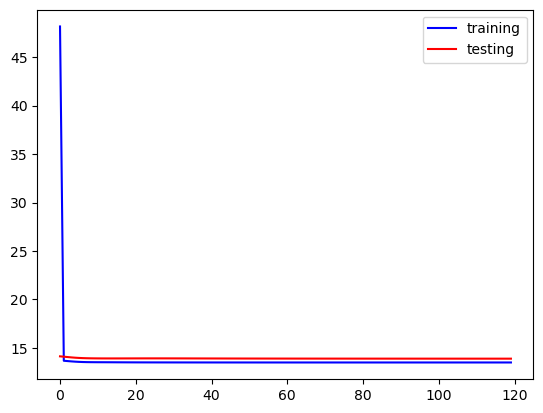

epoch: 120


100%|██████████| 121/121 [00:00<00:00, 542.24it/s]


batches for train: 121
train loss: 13.486756671558727


100%|██████████| 61/61 [00:00<00:00, 157.54it/s]


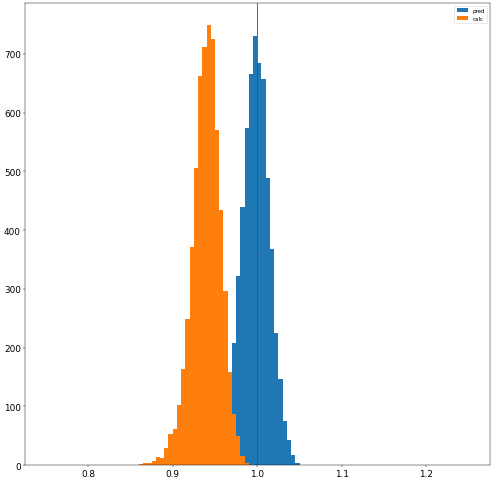

batches for test: 61
test loss: 13.880103220705125
calib weights: Parameter containing:
tensor([1.1474, 1.1632, 1.1855, 1.0829, 1.0672, 1.0907, 1.0258, 1.1058, 1.0393,
        1.0653, 0.9953, 1.0450, 1.0562, 1.0513, 1.0339, 1.1164, 1.0608, 1.1631,
        1.1110, 1.1798, 0.9321, 1.0219, 0.9209, 1.2046, 0.9990, 1.3052, 1.0554,
        2.5045], device='cuda:1', requires_grad=True)
new best test loss: 13.880103220705125
epoch: 121


100%|██████████| 121/121 [00:00<00:00, 532.10it/s]


batches for train: 121
train loss: 13.486765467430935


100%|██████████| 61/61 [00:00<00:00, 157.85it/s]


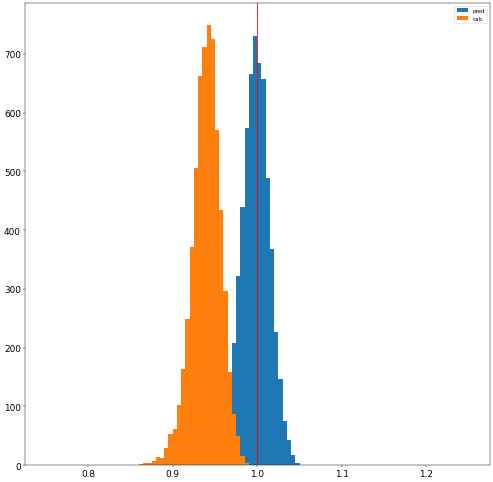

batches for test: 61
test loss: 13.880055443185274
calib weights: Parameter containing:
tensor([1.1474, 1.1631, 1.1856, 1.0829, 1.0671, 1.0907, 1.0257, 1.1059, 1.0393,
        1.0654, 0.9953, 1.0450, 1.0562, 1.0513, 1.0338, 1.1164, 1.0608, 1.1632,
        1.1109, 1.1799, 0.9320, 1.0219, 0.9208, 1.2046, 0.9989, 1.3050, 1.0550,
        2.5078], device='cuda:1', requires_grad=True)
new best test loss: 13.880055443185274
epoch: 122


100%|██████████| 121/121 [00:00<00:00, 518.58it/s]


batches for train: 121
train loss: 13.486774625857015


100%|██████████| 61/61 [00:00<00:00, 98.52it/s] 


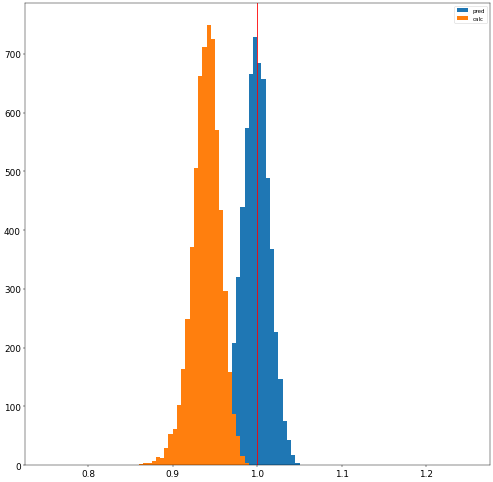

batches for test: 61
test loss: 13.880010229642274
calib weights: Parameter containing:
tensor([1.1473, 1.1631, 1.1857, 1.0828, 1.0671, 1.0908, 1.0256, 1.1060, 1.0392,
        1.0654, 0.9952, 1.0450, 1.0562, 1.0513, 1.0338, 1.1165, 1.0607, 1.1632,
        1.1109, 1.1799, 0.9320, 1.0219, 0.9208, 1.2046, 0.9987, 1.3049, 1.0546,
        2.5110], device='cuda:1', requires_grad=True)
new best test loss: 13.880010229642274
epoch: 123


100%|██████████| 121/121 [00:00<00:00, 533.42it/s]


batches for train: 121
train loss: 13.486783421729221


100%|██████████| 61/61 [00:00<00:00, 155.38it/s]


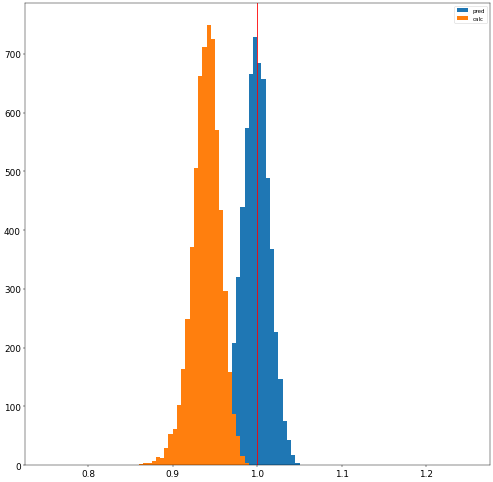

batches for test: 61
test loss: 13.879965453851419
calib weights: Parameter containing:
tensor([1.1472, 1.1630, 1.1858, 1.0828, 1.0671, 1.0908, 1.0256, 1.1061, 1.0392,
        1.0654, 0.9952, 1.0451, 1.0563, 1.0513, 1.0337, 1.1165, 1.0607, 1.1633,
        1.1109, 1.1800, 0.9319, 1.0218, 0.9207, 1.2045, 0.9986, 1.3047, 1.0542,
        2.5142], device='cuda:1', requires_grad=True)
new best test loss: 13.879965453851419
epoch: 124


100%|██████████| 121/121 [00:00<00:00, 545.09it/s]


batches for train: 121
train loss: 13.486791973271647


100%|██████████| 61/61 [00:00<00:00, 155.80it/s]


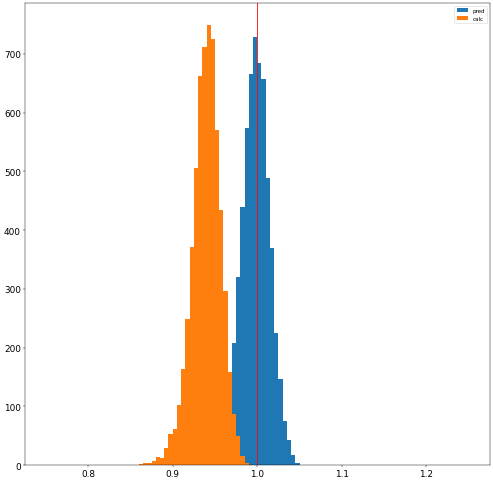

batches for test: 61
test loss: 13.879922835553279
calib weights: Parameter containing:
tensor([1.1472, 1.1630, 1.1859, 1.0828, 1.0671, 1.0909, 1.0255, 1.1061, 1.0392,
        1.0655, 0.9951, 1.0451, 1.0563, 1.0513, 1.0337, 1.1166, 1.0606, 1.1634,
        1.1109, 1.1801, 0.9318, 1.0218, 0.9207, 1.2045, 0.9984, 1.3046, 1.0539,
        2.5172], device='cuda:1', requires_grad=True)
new best test loss: 13.879922835553279
epoch: 125


100%|██████████| 121/121 [00:00<00:00, 523.36it/s]


batches for train: 121
train loss: 13.486799429270846


100%|██████████| 61/61 [00:00<00:00, 155.68it/s]


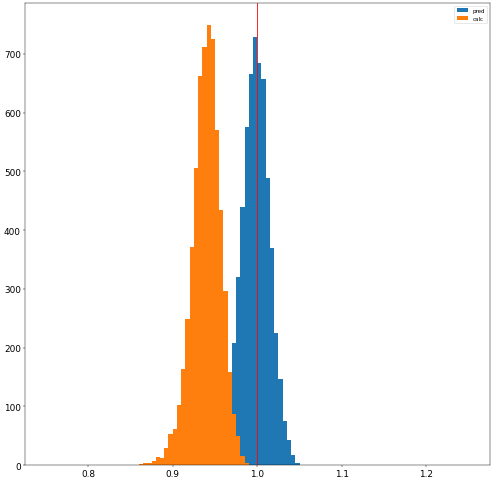

batches for test: 61
test loss: 13.879882828134004
calib weights: Parameter containing:
tensor([1.1471, 1.1629, 1.1860, 1.0827, 1.0671, 1.0909, 1.0254, 1.1062, 1.0391,
        1.0655, 0.9951, 1.0451, 1.0563, 1.0513, 1.0337, 1.1166, 1.0606, 1.1634,
        1.1109, 1.1801, 0.9318, 1.0218, 0.9206, 1.2045, 0.9983, 1.3044, 1.0535,
        2.5203], device='cuda:1', requires_grad=True)
new best test loss: 13.879882828134004
epoch: 126


100%|██████████| 121/121 [00:00<00:00, 430.90it/s]


batches for train: 121
train loss: 13.486808729565833


100%|██████████| 61/61 [00:00<00:00, 142.08it/s]


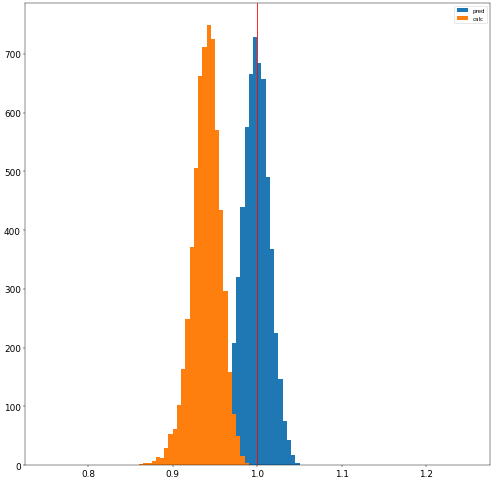

batches for test: 61
test loss: 13.879838193049196
calib weights: Parameter containing:
tensor([1.1470, 1.1629, 1.1861, 1.0827, 1.0671, 1.0910, 1.0254, 1.1063, 1.0391,
        1.0655, 0.9950, 1.0451, 1.0563, 1.0513, 1.0336, 1.1167, 1.0605, 1.1635,
        1.1108, 1.1802, 0.9317, 1.0218, 0.9206, 1.2045, 0.9982, 1.3043, 1.0532,
        2.5232], device='cuda:1', requires_grad=True)
new best test loss: 13.879838193049196
epoch: 127


100%|██████████| 121/121 [00:00<00:00, 529.01it/s]


batches for train: 121
train loss: 13.486815184601083


100%|██████████| 61/61 [00:00<00:00, 156.30it/s]


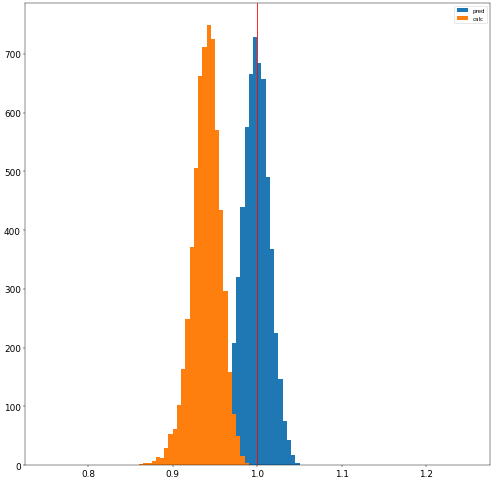

batches for test: 61
test loss: 13.879802266105276
calib weights: Parameter containing:
tensor([1.1470, 1.1628, 1.1861, 1.0826, 1.0670, 1.0910, 1.0253, 1.1064, 1.0391,
        1.0656, 0.9950, 1.0451, 1.0564, 1.0513, 1.0336, 1.1167, 1.0605, 1.1636,
        1.1108, 1.1802, 0.9317, 1.0217, 0.9206, 1.2044, 0.9980, 1.3041, 1.0528,
        2.5261], device='cuda:1', requires_grad=True)
new best test loss: 13.879802266105276
epoch: 128


100%|██████████| 121/121 [00:00<00:00, 563.73it/s]


batches for train: 121
train loss: 13.48682428785592


100%|██████████| 61/61 [00:00<00:00, 154.02it/s]


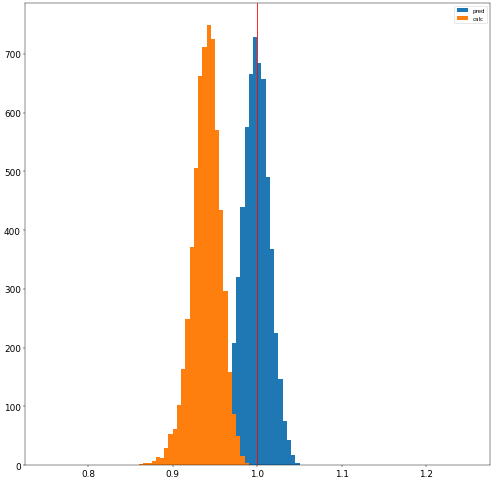

batches for test: 61
test loss: 13.879763743916495
calib weights: Parameter containing:
tensor([1.1469, 1.1628, 1.1862, 1.0826, 1.0670, 1.0911, 1.0252, 1.1064, 1.0391,
        1.0656, 0.9950, 1.0451, 1.0564, 1.0513, 1.0335, 1.1168, 1.0604, 1.1636,
        1.1108, 1.1803, 0.9316, 1.0217, 0.9205, 1.2044, 0.9979, 1.3040, 1.0525,
        2.5290], device='cuda:1', requires_grad=True)
new best test loss: 13.879763743916495
epoch: 129


100%|██████████| 121/121 [00:00<00:00, 525.32it/s]


batches for train: 121
train loss: 13.486831136971466


100%|██████████| 61/61 [00:00<00:00, 153.77it/s]


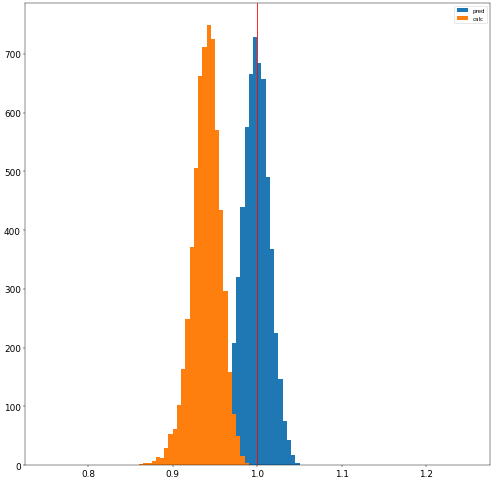

batches for test: 61
test loss: 13.87972520609371
calib weights: Parameter containing:
tensor([1.1469, 1.1628, 1.1863, 1.0826, 1.0670, 1.0911, 1.0252, 1.1065, 1.0390,
        1.0656, 0.9949, 1.0451, 1.0564, 1.0513, 1.0335, 1.1168, 1.0604, 1.1637,
        1.1108, 1.1803, 0.9316, 1.0217, 0.9205, 1.2044, 0.9978, 1.3038, 1.0522,
        2.5318], device='cuda:1', requires_grad=True)
new best test loss: 13.87972520609371


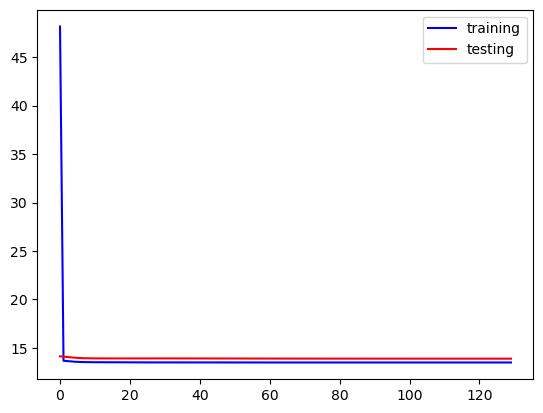

epoch: 130


100%|██████████| 121/121 [00:00<00:00, 510.37it/s]


batches for train: 121
train loss: 13.486839743685131


100%|██████████| 61/61 [00:00<00:00, 154.92it/s]


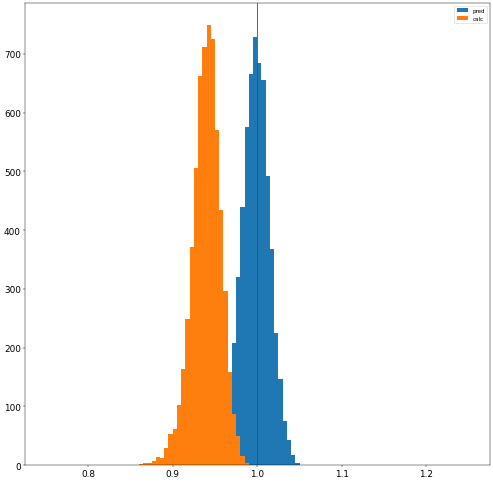

batches for test: 61
test loss: 13.879687668847255
calib weights: Parameter containing:
tensor([1.1468, 1.1627, 1.1864, 1.0825, 1.0670, 1.0912, 1.0251, 1.1066, 1.0390,
        1.0657, 0.9949, 1.0451, 1.0564, 1.0513, 1.0335, 1.1169, 1.0603, 1.1637,
        1.1107, 1.1804, 0.9316, 1.0217, 0.9204, 1.2044, 0.9976, 1.3037, 1.0519,
        2.5345], device='cuda:1', requires_grad=True)
new best test loss: 13.879687668847255
epoch: 131


100%|██████████| 121/121 [00:00<00:00, 394.74it/s]


batches for train: 121
train loss: 13.486848350398796


100%|██████████| 61/61 [00:00<00:00, 132.07it/s]


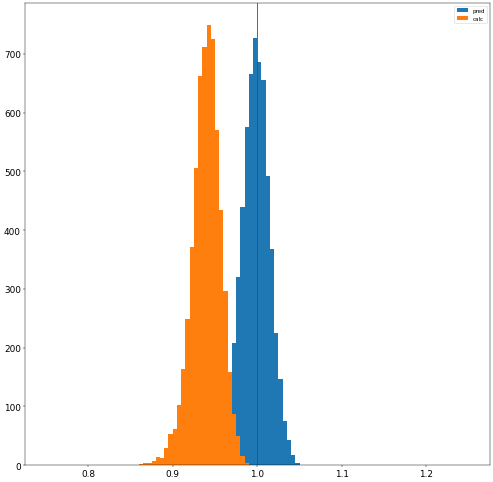

batches for test: 61
test loss: 13.879650553718943
calib weights: Parameter containing:
tensor([1.1468, 1.1627, 1.1864, 1.0825, 1.0670, 1.0912, 1.0250, 1.1066, 1.0390,
        1.0657, 0.9948, 1.0451, 1.0565, 1.0513, 1.0334, 1.1169, 1.0603, 1.1638,
        1.1107, 1.1804, 0.9315, 1.0216, 0.9204, 1.2043, 0.9975, 1.3036, 1.0516,
        2.5372], device='cuda:1', requires_grad=True)
new best test loss: 13.879650553718943
epoch: 132


100%|██████████| 121/121 [00:00<00:00, 543.71it/s]


batches for train: 121
train loss: 13.486855270448794


100%|██████████| 61/61 [00:00<00:00, 153.52it/s]


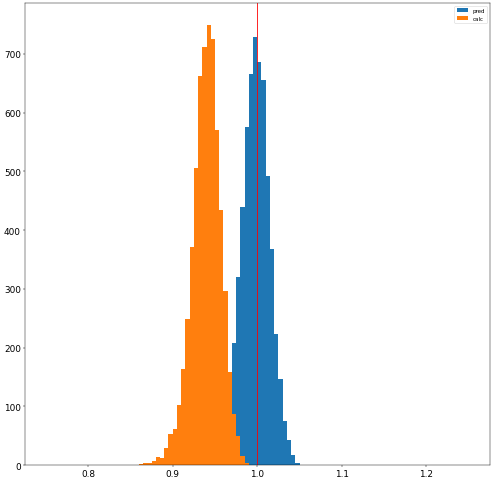

batches for test: 61
test loss: 13.879617925550116
calib weights: Parameter containing:
tensor([1.1467, 1.1626, 1.1865, 1.0825, 1.0670, 1.0913, 1.0250, 1.1067, 1.0389,
        1.0657, 0.9948, 1.0452, 1.0565, 1.0513, 1.0334, 1.1169, 1.0602, 1.1638,
        1.1107, 1.1805, 0.9315, 1.0216, 0.9204, 1.2043, 0.9974, 1.3034, 1.0513,
        2.5399], device='cuda:1', requires_grad=True)
new best test loss: 13.879617925550116
epoch: 133


100%|██████████| 121/121 [00:00<00:00, 526.79it/s]


batches for train: 121
train loss: 13.48686146539105


100%|██████████| 61/61 [00:00<00:00, 98.65it/s] 


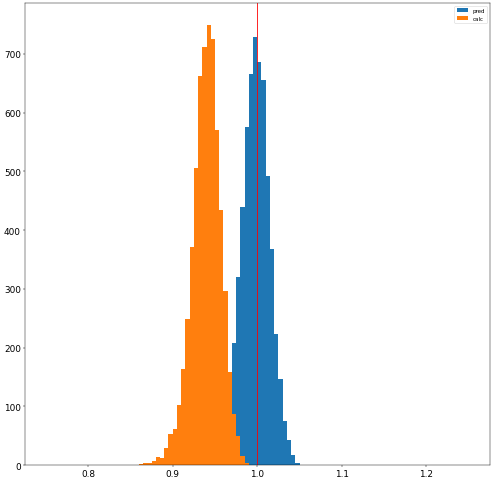

batches for test: 61
test loss: 13.879582092410228
calib weights: Parameter containing:
tensor([1.1467, 1.1626, 1.1866, 1.0825, 1.0670, 1.0913, 1.0249, 1.1068, 1.0389,
        1.0657, 0.9948, 1.0452, 1.0565, 1.0513, 1.0334, 1.1170, 1.0602, 1.1639,
        1.1107, 1.1805, 0.9314, 1.0216, 0.9203, 1.2043, 0.9973, 1.3033, 1.0510,
        2.5425], device='cuda:1', requires_grad=True)
new best test loss: 13.879582092410228
epoch: 134


100%|██████████| 121/121 [00:00<00:00, 496.62it/s]


batches for train: 121
train loss: 13.486870994252607


100%|██████████| 61/61 [00:00<00:00, 152.17it/s]


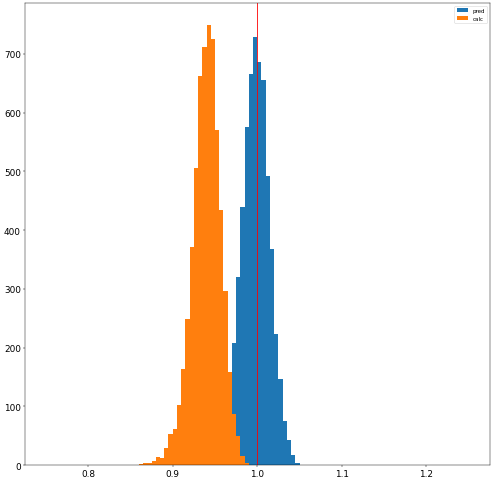

batches for test: 61
test loss: 13.879549558045435
calib weights: Parameter containing:
tensor([1.1466, 1.1626, 1.1867, 1.0824, 1.0669, 1.0913, 1.0249, 1.1068, 1.0389,
        1.0658, 0.9947, 1.0452, 1.0565, 1.0513, 1.0333, 1.1170, 1.0601, 1.1639,
        1.1107, 1.1806, 0.9314, 1.0216, 0.9203, 1.2042, 0.9972, 1.3031, 1.0507,
        2.5450], device='cuda:1', requires_grad=True)
new best test loss: 13.879549558045435
epoch: 135


100%|██████████| 121/121 [00:00<00:00, 528.45it/s]


batches for train: 121
train loss: 13.486877733025668


100%|██████████| 61/61 [00:00<00:00, 155.44it/s]


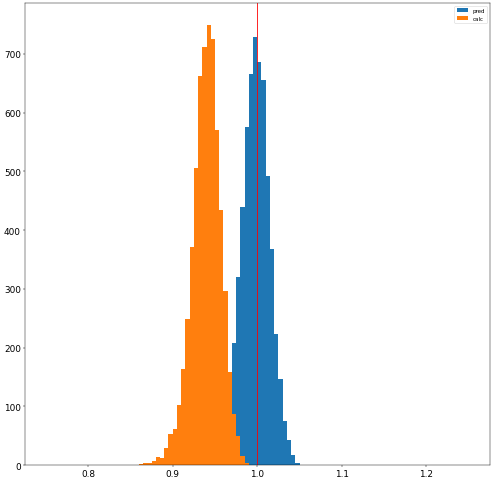

batches for test: 61
test loss: 13.879518008622966
calib weights: Parameter containing:
tensor([1.1466, 1.1625, 1.1867, 1.0824, 1.0669, 1.0914, 1.0248, 1.1069, 1.0389,
        1.0658, 0.9947, 1.0452, 1.0565, 1.0513, 1.0333, 1.1170, 1.0601, 1.1640,
        1.1107, 1.1806, 0.9314, 1.0216, 0.9203, 1.2042, 0.9971, 1.3030, 1.0504,
        2.5475], device='cuda:1', requires_grad=True)
new best test loss: 13.879518008622966
epoch: 136


100%|██████████| 121/121 [00:00<00:00, 561.31it/s]


batches for train: 121
train loss: 13.486884660957273


100%|██████████| 61/61 [00:00<00:00, 155.38it/s]


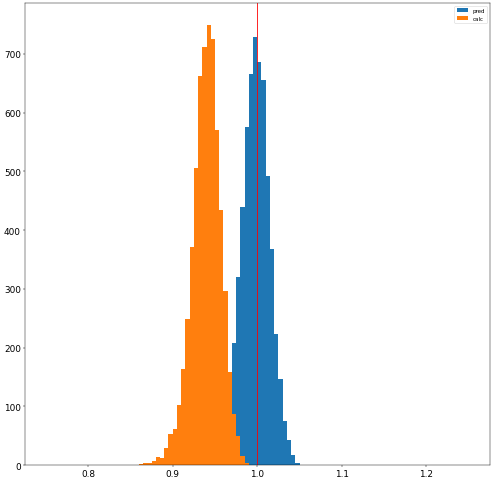

batches for test: 61
test loss: 13.879487709920914
calib weights: Parameter containing:
tensor([1.1466, 1.1625, 1.1868, 1.0824, 1.0669, 1.0914, 1.0248, 1.1069, 1.0388,
        1.0658, 0.9947, 1.0452, 1.0566, 1.0513, 1.0333, 1.1171, 1.0601, 1.1640,
        1.1106, 1.1807, 0.9313, 1.0215, 0.9202, 1.2042, 0.9970, 1.3029, 1.0501,
        2.5499], device='cuda:1', requires_grad=True)
new best test loss: 13.879487709920914
epoch: 137


100%|██████████| 121/121 [00:00<00:00, 530.15it/s]


batches for train: 121
train loss: 13.486891691349754


100%|██████████| 61/61 [00:00<00:00, 155.06it/s]


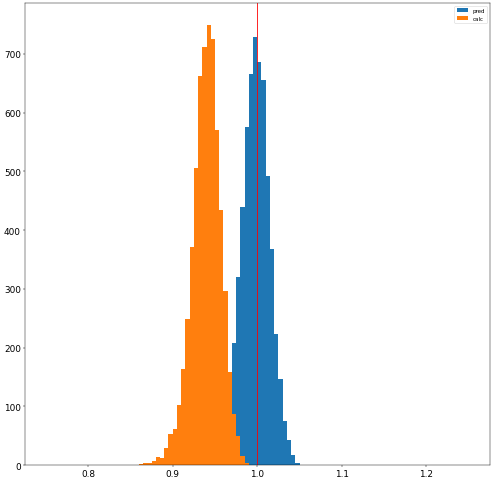

batches for test: 61
test loss: 13.879457817702997
calib weights: Parameter containing:
tensor([1.1465, 1.1625, 1.1868, 1.0823, 1.0669, 1.0915, 1.0247, 1.1070, 1.0388,
        1.0658, 0.9946, 1.0452, 1.0566, 1.0513, 1.0333, 1.1171, 1.0600, 1.1641,
        1.1106, 1.1807, 0.9313, 1.0215, 0.9202, 1.2042, 0.9969, 1.3027, 1.0499,
        2.5523], device='cuda:1', requires_grad=True)
new best test loss: 13.879457817702997
epoch: 138


100%|██████████| 121/121 [00:00<00:00, 550.04it/s]


batches for train: 121
train loss: 13.486898382833182


100%|██████████| 61/61 [00:00<00:00, 156.07it/s]


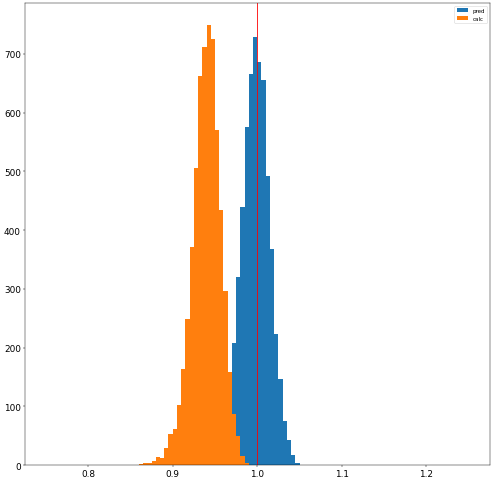

batches for test: 61
test loss: 13.87942883225738
calib weights: Parameter containing:
tensor([1.1465, 1.1624, 1.1869, 1.0823, 1.0669, 1.0915, 1.0247, 1.1070, 1.0388,
        1.0659, 0.9946, 1.0452, 1.0566, 1.0513, 1.0332, 1.1171, 1.0600, 1.1641,
        1.1106, 1.1808, 0.9313, 1.0215, 0.9202, 1.2041, 0.9968, 1.3026, 1.0496,
        2.5546], device='cuda:1', requires_grad=True)
new best test loss: 13.87942883225738
epoch: 139


100%|██████████| 121/121 [00:00<00:00, 514.62it/s]


batches for train: 121
train loss: 13.486905168895879


100%|██████████| 61/61 [00:00<00:00, 155.41it/s]


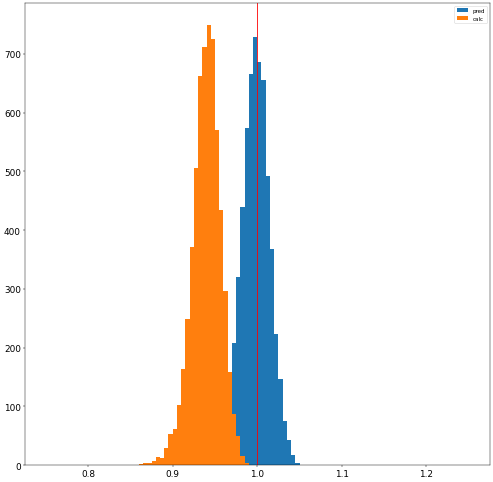

batches for test: 61
test loss: 13.879401066264169
calib weights: Parameter containing:
tensor([1.1464, 1.1624, 1.1870, 1.0823, 1.0669, 1.0915, 1.0246, 1.1071, 1.0388,
        1.0659, 0.9946, 1.0452, 1.0566, 1.0513, 1.0332, 1.1172, 1.0599, 1.1642,
        1.1106, 1.1808, 0.9312, 1.0215, 0.9202, 1.2041, 0.9967, 1.3025, 1.0493,
        2.5569], device='cuda:1', requires_grad=True)
new best test loss: 13.879401066264169


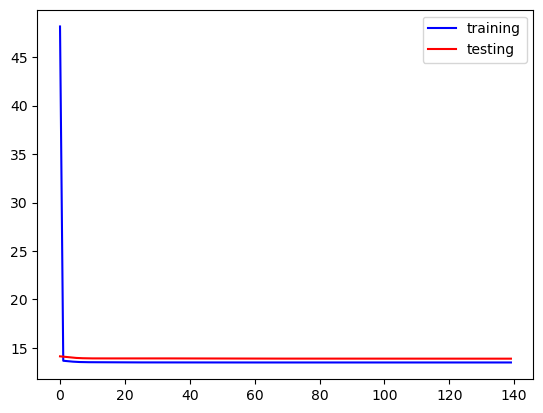

epoch: 140


100%|██████████| 121/121 [00:00<00:00, 533.41it/s]


batches for train: 121
train loss: 13.486911221969226


100%|██████████| 61/61 [00:00<00:00, 154.33it/s]


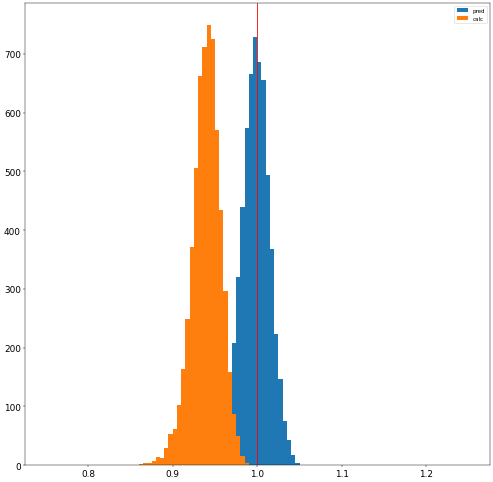

batches for test: 61
test loss: 13.879372612374727
calib weights: Parameter containing:
tensor([1.1464, 1.1624, 1.1870, 1.0823, 1.0669, 1.0916, 1.0246, 1.1072, 1.0387,
        1.0659, 0.9945, 1.0452, 1.0566, 1.0513, 1.0332, 1.1172, 1.0599, 1.1642,
        1.1106, 1.1808, 0.9312, 1.0215, 0.9201, 1.2041, 0.9966, 1.3023, 1.0491,
        2.5592], device='cuda:1', requires_grad=True)
new best test loss: 13.879372612374727
epoch: 141


100%|██████████| 121/121 [00:00<00:00, 452.40it/s]


batches for train: 121
train loss: 13.486918717376456


100%|██████████| 61/61 [00:00<00:00, 151.42it/s]


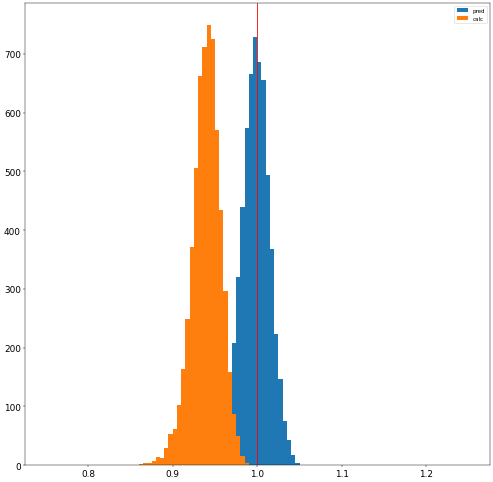

batches for test: 61
test loss: 13.879344095949266
calib weights: Parameter containing:
tensor([1.1464, 1.1623, 1.1871, 1.0822, 1.0669, 1.0916, 1.0245, 1.1072, 1.0387,
        1.0659, 0.9945, 1.0452, 1.0566, 1.0513, 1.0332, 1.1172, 1.0599, 1.1643,
        1.1106, 1.1809, 0.9312, 1.0214, 0.9201, 1.2041, 0.9965, 1.3022, 1.0488,
        2.5614], device='cuda:1', requires_grad=True)
new best test loss: 13.879344095949266
epoch: 142


100%|██████████| 121/121 [00:00<00:00, 519.86it/s]


batches for train: 121
train loss: 13.486926252191717


100%|██████████| 61/61 [00:00<00:00, 156.54it/s]


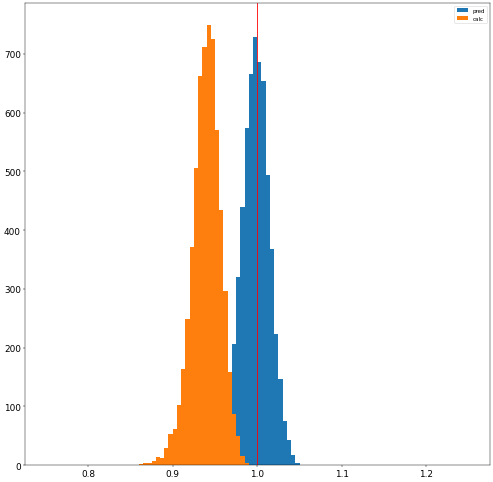

batches for test: 61
test loss: 13.879316658270163
calib weights: Parameter containing:
tensor([1.1463, 1.1623, 1.1871, 1.0822, 1.0668, 1.0916, 1.0245, 1.1073, 1.0387,
        1.0660, 0.9945, 1.0452, 1.0567, 1.0513, 1.0331, 1.1173, 1.0598, 1.1643,
        1.1105, 1.1809, 0.9311, 1.0214, 0.9201, 1.2040, 0.9964, 1.3021, 1.0486,
        2.5635], device='cuda:1', requires_grad=True)
new best test loss: 13.879316658270163
epoch: 143


100%|██████████| 121/121 [00:00<00:00, 526.85it/s]


batches for train: 121
train loss: 13.486931201840235


100%|██████████| 61/61 [00:00<00:00, 154.75it/s]


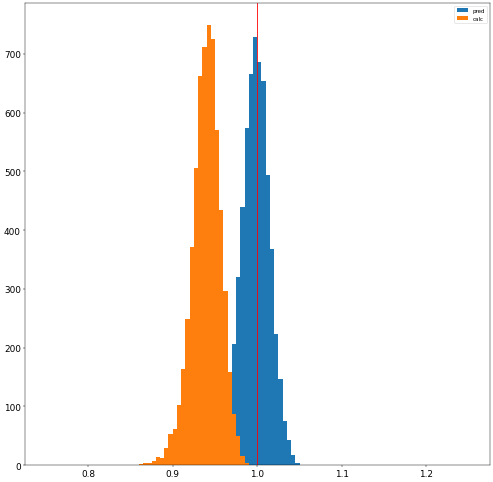

batches for test: 61
test loss: 13.879289267493077
calib weights: Parameter containing:
tensor([1.1463, 1.1623, 1.1872, 1.0822, 1.0668, 1.0917, 1.0244, 1.1073, 1.0387,
        1.0660, 0.9944, 1.0453, 1.0567, 1.0513, 1.0331, 1.1173, 1.0598, 1.1643,
        1.1105, 1.1809, 0.9311, 1.0214, 0.9201, 1.2040, 0.9963, 1.3019, 1.0483,
        2.5657], device='cuda:1', requires_grad=True)
new best test loss: 13.879289267493077
epoch: 144


100%|██████████| 121/121 [00:00<00:00, 531.11it/s]


batches for train: 121
train loss: 13.486938121890233


100%|██████████| 61/61 [00:00<00:00, 98.97it/s] 


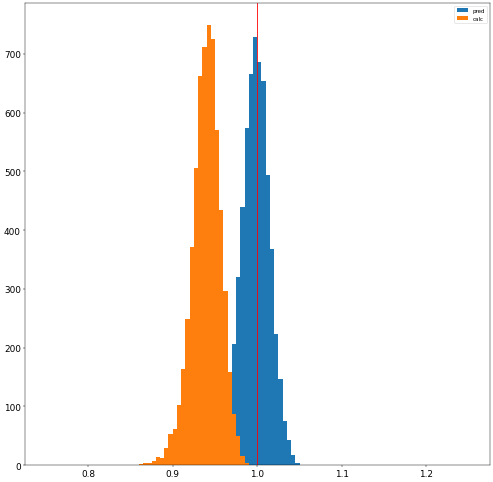

batches for test: 61
test loss: 13.87926329941046
calib weights: Parameter containing:
tensor([1.1463, 1.1622, 1.1872, 1.0822, 1.0668, 1.0917, 1.0244, 1.1074, 1.0386,
        1.0660, 0.9944, 1.0453, 1.0567, 1.0513, 1.0331, 1.1173, 1.0598, 1.1644,
        1.1105, 1.1810, 0.9311, 1.0214, 0.9200, 1.2040, 0.9962, 1.3018, 1.0481,
        2.5677], device='cuda:1', requires_grad=True)
new best test loss: 13.87926329941046
epoch: 145


100%|██████████| 121/121 [00:00<00:00, 499.56it/s]


batches for train: 121
train loss: 13.486945570007828


100%|██████████| 61/61 [00:00<00:00, 154.38it/s]


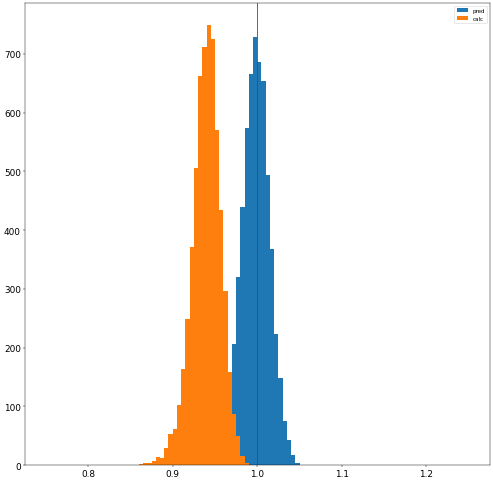

batches for test: 61
test loss: 13.879241380535188
calib weights: Parameter containing:
tensor([1.1463, 1.1622, 1.1873, 1.0821, 1.0668, 1.0917, 1.0243, 1.1074, 1.0386,
        1.0660, 0.9944, 1.0453, 1.0567, 1.0513, 1.0331, 1.1173, 1.0597, 1.1644,
        1.1105, 1.1810, 0.9311, 1.0214, 0.9200, 1.2040, 0.9961, 1.3017, 1.0479,
        2.5698], device='cuda:1', requires_grad=True)
new best test loss: 13.879241380535188
epoch: 146


100%|██████████| 121/121 [00:00<00:00, 518.47it/s]


batches for train: 121
train loss: 13.486950228036928


100%|██████████| 61/61 [00:00<00:00, 155.90it/s]


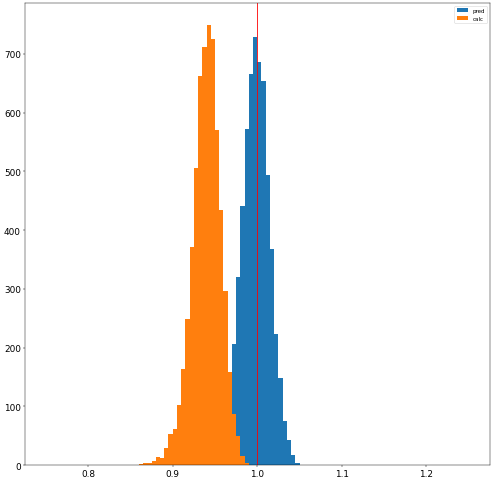

batches for test: 61
test loss: 13.879216647538982
calib weights: Parameter containing:
tensor([1.1462, 1.1622, 1.1873, 1.0821, 1.0668, 1.0918, 1.0243, 1.1074, 1.0386,
        1.0660, 0.9944, 1.0453, 1.0567, 1.0513, 1.0330, 1.1174, 1.0597, 1.1645,
        1.1105, 1.1810, 0.9311, 1.0214, 0.9200, 1.2039, 0.9960, 1.3016, 1.0477,
        2.5718], device='cuda:1', requires_grad=True)
new best test loss: 13.879216647538982
epoch: 147


100%|██████████| 121/121 [00:00<00:00, 494.25it/s]


batches for train: 121
train loss: 13.486957171731744


100%|██████████| 61/61 [00:00<00:00, 153.86it/s]


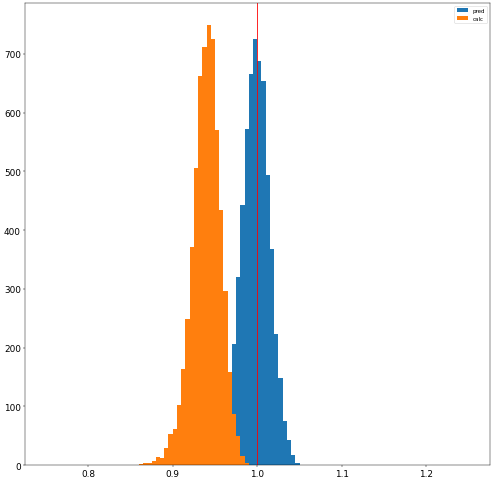

batches for test: 61
test loss: 13.879192899485103
calib weights: Parameter containing:
tensor([1.1462, 1.1621, 1.1874, 1.0821, 1.0668, 1.0918, 1.0242, 1.1075, 1.0386,
        1.0661, 0.9943, 1.0453, 1.0567, 1.0513, 1.0330, 1.1174, 1.0597, 1.1645,
        1.1105, 1.1811, 0.9310, 1.0214, 0.9200, 1.2039, 0.9960, 1.3014, 1.0474,
        2.5737], device='cuda:1', requires_grad=True)
new best test loss: 13.879192899485103
epoch: 148


100%|██████████| 121/121 [00:00<00:00, 448.97it/s]


batches for train: 121
train loss: 13.486963004120126


100%|██████████| 61/61 [00:00<00:00, 144.80it/s]


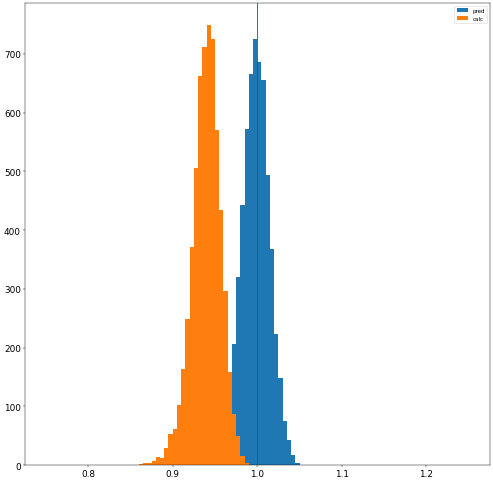

batches for test: 61
test loss: 13.879173075566527
calib weights: Parameter containing:
tensor([1.1462, 1.1621, 1.1874, 1.0821, 1.0668, 1.0918, 1.0242, 1.1075, 1.0386,
        1.0661, 0.9943, 1.0453, 1.0568, 1.0513, 1.0330, 1.1174, 1.0596, 1.1645,
        1.1105, 1.1811, 0.9310, 1.0213, 0.9199, 1.2039, 0.9959, 1.3013, 1.0472,
        2.5757], device='cuda:1', requires_grad=True)
new best test loss: 13.879173075566527
epoch: 149


100%|██████████| 121/121 [00:00<00:00, 529.53it/s]


batches for train: 121
train loss: 13.486968899561354


100%|██████████| 61/61 [00:00<00:00, 155.90it/s]


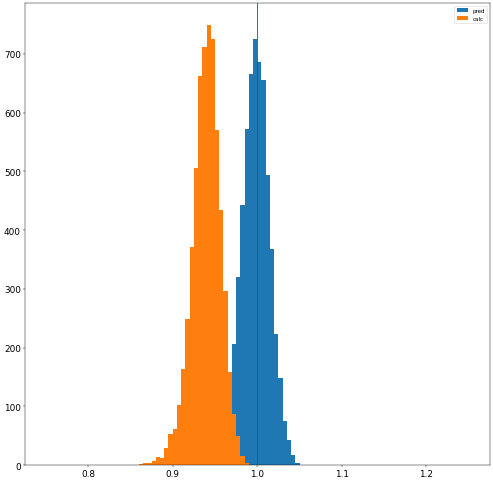

batches for test: 61
test loss: 13.879147295091974
calib weights: Parameter containing:
tensor([1.1462, 1.1621, 1.1875, 1.0821, 1.0668, 1.0919, 1.0242, 1.1076, 1.0385,
        1.0661, 0.9943, 1.0453, 1.0568, 1.0513, 1.0330, 1.1174, 1.0596, 1.1646,
        1.1104, 1.1811, 0.9310, 1.0213, 0.9199, 1.2039, 0.9958, 1.3012, 1.0470,
        2.5776], device='cuda:1', requires_grad=True)
new best test loss: 13.879147295091974


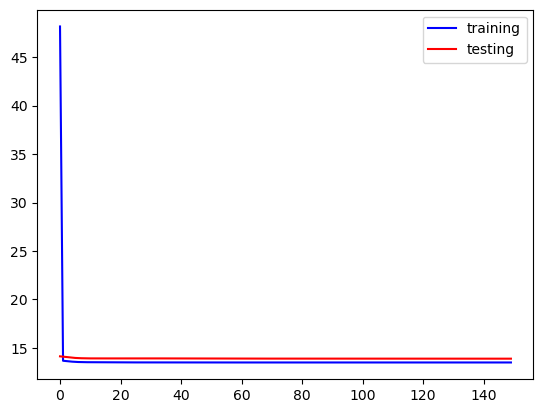

epoch: 150


100%|██████████| 121/121 [00:00<00:00, 526.96it/s]


batches for train: 121
train loss: 13.486975015687548


100%|██████████| 61/61 [00:00<00:00, 155.59it/s]


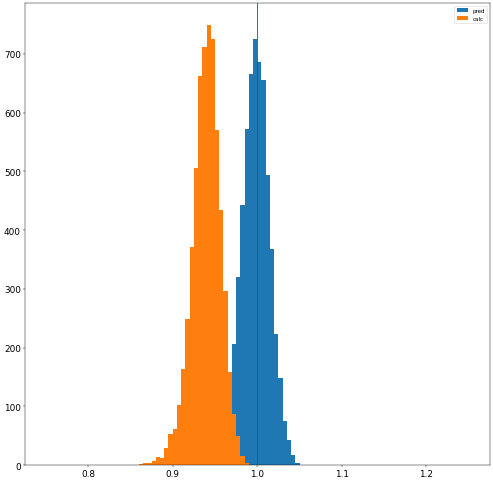

batches for test: 61
test loss: 13.879128409213708
calib weights: Parameter containing:
tensor([1.1461, 1.1621, 1.1875, 1.0820, 1.0668, 1.0919, 1.0241, 1.1076, 1.0385,
        1.0661, 0.9943, 1.0453, 1.0568, 1.0513, 1.0330, 1.1175, 1.0596, 1.1646,
        1.1104, 1.1811, 0.9310, 1.0213, 0.9199, 1.2038, 0.9957, 1.3011, 1.0468,
        2.5794], device='cuda:1', requires_grad=True)
new best test loss: 13.879128409213708
epoch: 151


100%|██████████| 121/121 [00:00<00:00, 515.14it/s]


batches for train: 121
train loss: 13.486981344617103


100%|██████████| 61/61 [00:00<00:00, 154.75it/s]


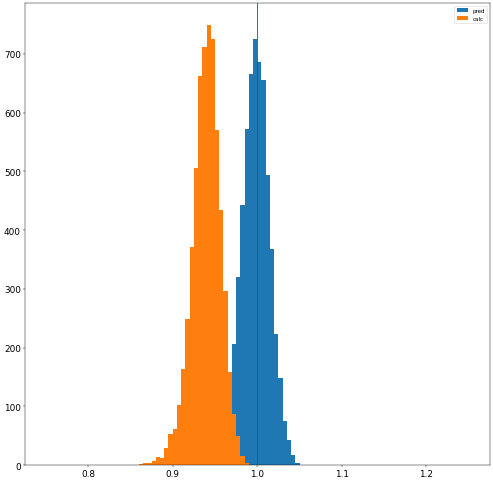

batches for test: 61
test loss: 13.879105818076212
calib weights: Parameter containing:
tensor([1.1461, 1.1620, 1.1876, 1.0820, 1.0668, 1.0919, 1.0241, 1.1077, 1.0385,
        1.0661, 0.9943, 1.0453, 1.0568, 1.0513, 1.0329, 1.1175, 1.0596, 1.1646,
        1.1104, 1.1812, 0.9309, 1.0213, 0.9199, 1.2038, 0.9957, 1.3010, 1.0466,
        2.5812], device='cuda:1', requires_grad=True)
new best test loss: 13.879105818076212
epoch: 152


100%|██████████| 121/121 [00:00<00:00, 530.63it/s]


batches for train: 121
train loss: 13.486985963238173


100%|██████████| 61/61 [00:00<00:00, 156.05it/s]


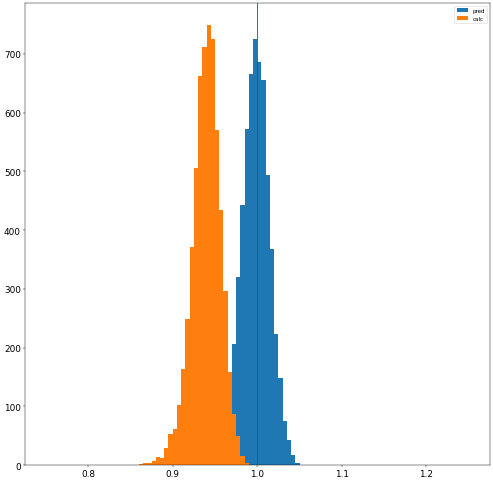

batches for test: 61
test loss: 13.879086869661926
calib weights: Parameter containing:
tensor([1.1461, 1.1620, 1.1876, 1.0820, 1.0668, 1.0919, 1.0240, 1.1077, 1.0385,
        1.0661, 0.9942, 1.0453, 1.0568, 1.0513, 1.0329, 1.1175, 1.0595, 1.1647,
        1.1104, 1.1812, 0.9309, 1.0213, 0.9199, 1.2038, 0.9956, 1.3009, 1.0464,
        2.5830], device='cuda:1', requires_grad=True)
new best test loss: 13.879086869661926
epoch: 153


100%|██████████| 121/121 [00:00<00:00, 493.39it/s]


batches for train: 121
train loss: 13.486992370983787


100%|██████████| 61/61 [00:00<00:00, 152.08it/s]


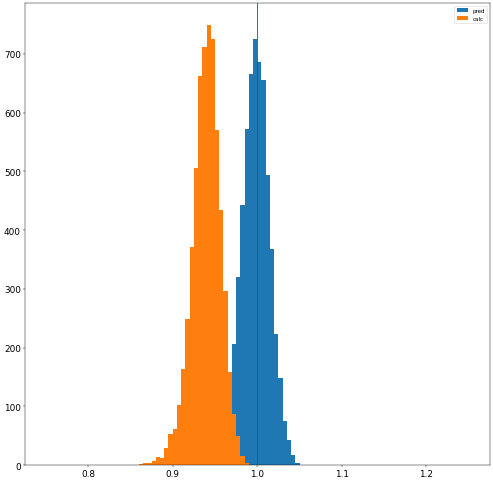

batches for test: 61
test loss: 13.879065732486913
calib weights: Parameter containing:
tensor([1.1461, 1.1620, 1.1876, 1.0820, 1.0668, 1.0920, 1.0240, 1.1077, 1.0385,
        1.0662, 0.9942, 1.0453, 1.0568, 1.0513, 1.0329, 1.1175, 1.0595, 1.1647,
        1.1104, 1.1812, 0.9309, 1.0213, 0.9198, 1.2038, 0.9955, 1.3007, 1.0462,
        2.5847], device='cuda:1', requires_grad=True)
new best test loss: 13.879065732486913
epoch: 154


100%|██████████| 121/121 [00:00<00:00, 449.46it/s]


batches for train: 121
train loss: 13.486996508826895


100%|██████████| 61/61 [00:00<00:00, 146.31it/s]


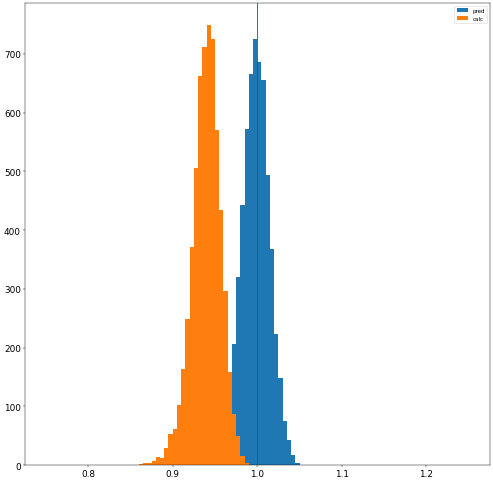

batches for test: 61
test loss: 13.879046721536605
calib weights: Parameter containing:
tensor([1.1460, 1.1619, 1.1877, 1.0820, 1.0667, 1.0920, 1.0240, 1.1078, 1.0384,
        1.0662, 0.9942, 1.0453, 1.0568, 1.0513, 1.0329, 1.1175, 1.0595, 1.1647,
        1.1104, 1.1812, 0.9309, 1.0213, 0.9198, 1.2037, 0.9954, 1.3006, 1.0460,
        2.5864], device='cuda:1', requires_grad=True)
new best test loss: 13.879046721536605
epoch: 155


100%|██████████| 121/121 [00:00<00:00, 477.00it/s]


batches for train: 121
train loss: 13.4870034367585


100%|██████████| 61/61 [00:00<00:00, 98.73it/s] 


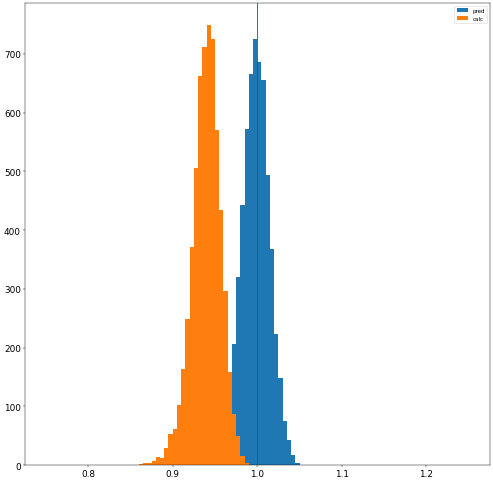

batches for test: 61
test loss: 13.87902461505327
calib weights: Parameter containing:
tensor([1.1460, 1.1619, 1.1877, 1.0819, 1.0667, 1.0920, 1.0239, 1.1078, 1.0384,
        1.0662, 0.9942, 1.0453, 1.0569, 1.0513, 1.0329, 1.1176, 1.0595, 1.1647,
        1.1104, 1.1813, 0.9309, 1.0213, 0.9198, 1.2037, 0.9954, 1.3005, 1.0458,
        2.5881], device='cuda:1', requires_grad=True)
new best test loss: 13.87902461505327
epoch: 156


100%|██████████| 121/121 [00:00<00:00, 440.25it/s]


batches for train: 121
train loss: 13.487008449459864


100%|██████████| 61/61 [00:00<00:00, 145.85it/s]


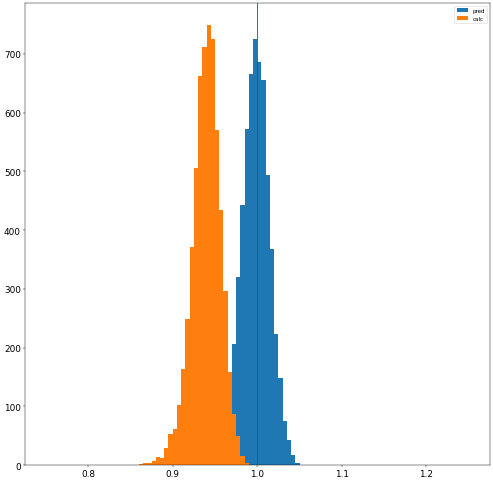

batches for test: 61
test loss: 13.879007214405497
calib weights: Parameter containing:
tensor([1.1460, 1.1619, 1.1878, 1.0819, 1.0667, 1.0921, 1.0239, 1.1078, 1.0384,
        1.0662, 0.9942, 1.0453, 1.0569, 1.0513, 1.0329, 1.1176, 1.0594, 1.1648,
        1.1104, 1.1813, 0.9309, 1.0213, 0.9198, 1.2037, 0.9953, 1.3004, 1.0457,
        2.5898], device='cuda:1', requires_grad=True)
new best test loss: 13.879007214405497
epoch: 157


100%|██████████| 121/121 [00:00<00:00, 418.10it/s]


batches for train: 121
train loss: 13.48701406116328


100%|██████████| 61/61 [00:00<00:00, 144.56it/s]


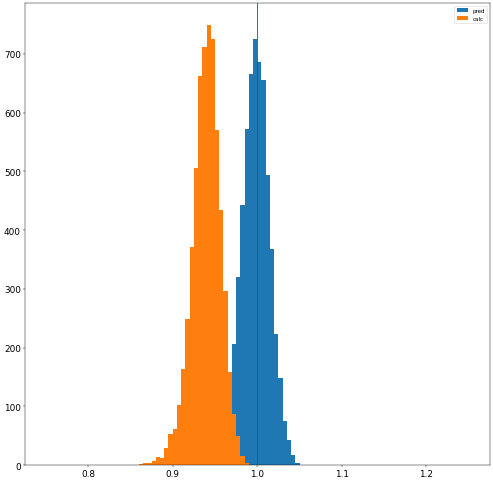

batches for test: 61
test loss: 13.878987859507076
calib weights: Parameter containing:
tensor([1.1460, 1.1619, 1.1878, 1.0819, 1.0667, 1.0921, 1.0239, 1.1079, 1.0384,
        1.0662, 0.9941, 1.0453, 1.0569, 1.0513, 1.0328, 1.1176, 1.0594, 1.1648,
        1.1104, 1.1813, 0.9308, 1.0212, 0.9198, 1.2037, 0.9952, 1.3003, 1.0455,
        2.5914], device='cuda:1', requires_grad=True)
new best test loss: 13.878987859507076
epoch: 158


100%|██████████| 121/121 [00:00<00:00, 508.18it/s]


batches for train: 121
train loss: 13.487018553678654


100%|██████████| 61/61 [00:00<00:00, 154.27it/s]


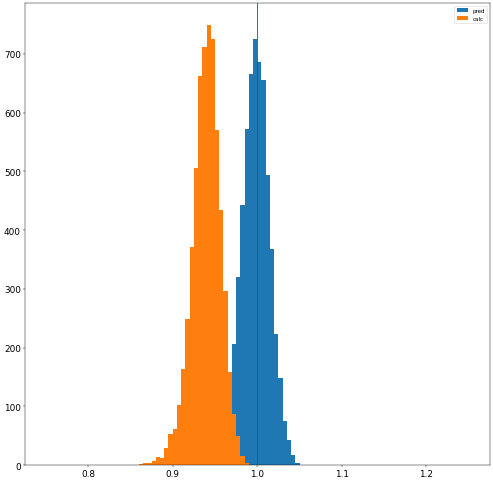

batches for test: 61
test loss: 13.87897063083336
calib weights: Parameter containing:
tensor([1.1460, 1.1618, 1.1878, 1.0819, 1.0667, 1.0921, 1.0238, 1.1079, 1.0384,
        1.0662, 0.9941, 1.0453, 1.0569, 1.0513, 1.0328, 1.1176, 1.0594, 1.1648,
        1.1103, 1.1813, 0.9308, 1.0212, 0.9198, 1.2036, 0.9952, 1.3002, 1.0453,
        2.5929], device='cuda:1', requires_grad=True)
new best test loss: 13.87897063083336
epoch: 159


100%|██████████| 121/121 [00:00<00:00, 467.76it/s]


batches for train: 121
train loss: 13.487023976223528


100%|██████████| 61/61 [00:00<00:00, 154.78it/s]


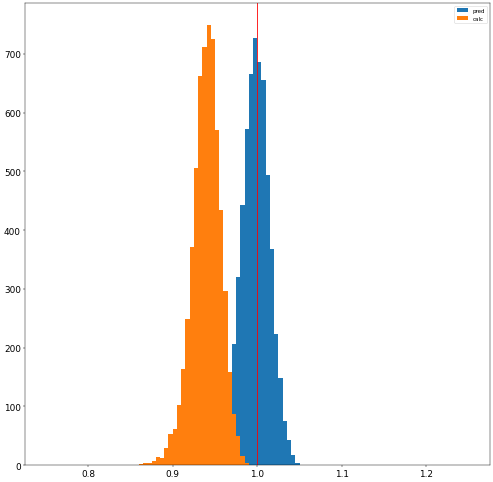

batches for test: 61
test loss: 13.878949884508478
calib weights: Parameter containing:
tensor([1.1460, 1.1618, 1.1879, 1.0819, 1.0667, 1.0921, 1.0238, 1.1079, 1.0384,
        1.0663, 0.9941, 1.0454, 1.0569, 1.0513, 1.0328, 1.1176, 1.0594, 1.1648,
        1.1103, 1.1813, 0.9308, 1.0212, 0.9197, 1.2036, 0.9951, 1.3001, 1.0451,
        2.5945], device='cuda:1', requires_grad=True)
new best test loss: 13.878949884508478


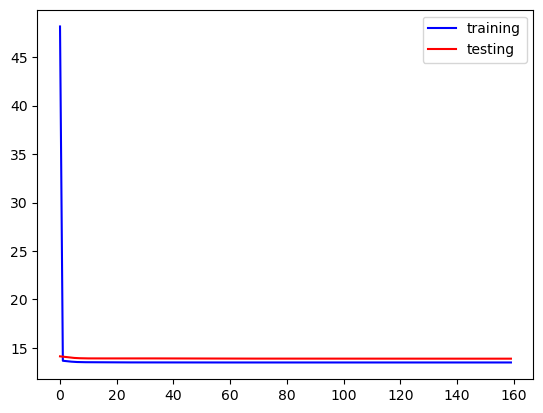

epoch: 160


100%|██████████| 121/121 [00:00<00:00, 497.16it/s]


batches for train: 121
train loss: 13.487028988924893


100%|██████████| 61/61 [00:00<00:00, 149.79it/s]


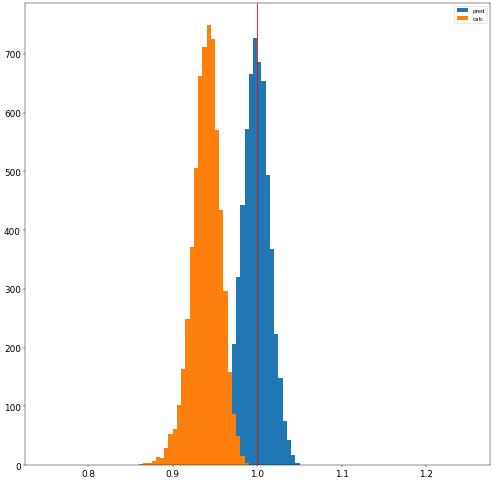

batches for test: 61
test loss: 13.878934688255436
calib weights: Parameter containing:
tensor([1.1459, 1.1618, 1.1879, 1.0819, 1.0667, 1.0922, 1.0238, 1.1080, 1.0383,
        1.0663, 0.9941, 1.0454, 1.0569, 1.0513, 1.0328, 1.1176, 1.0593, 1.1649,
        1.1103, 1.1814, 0.9308, 1.0212, 0.9197, 1.2036, 0.9951, 1.3000, 1.0450,
        2.5960], device='cuda:1', requires_grad=True)
new best test loss: 13.878934688255436
epoch: 161


100%|██████████| 121/121 [00:00<00:00, 465.49it/s]


batches for train: 121
train loss: 13.487033079478365


100%|██████████| 61/61 [00:00<00:00, 148.03it/s]


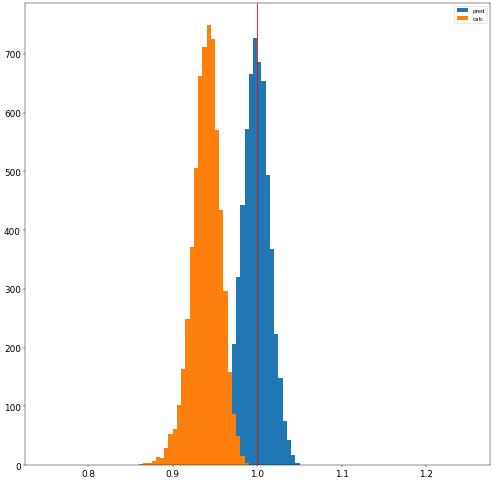

batches for test: 61
test loss: 13.878917959869884
calib weights: Parameter containing:
tensor([1.1459, 1.1618, 1.1879, 1.0818, 1.0667, 1.0922, 1.0237, 1.1080, 1.0383,
        1.0663, 0.9941, 1.0454, 1.0569, 1.0513, 1.0328, 1.1177, 1.0593, 1.1649,
        1.1103, 1.1814, 0.9308, 1.0212, 0.9197, 1.2036, 0.9950, 1.2999, 1.0448,
        2.5975], device='cuda:1', requires_grad=True)
new best test loss: 13.878917959869884
epoch: 162


100%|██████████| 121/121 [00:00<00:00, 444.50it/s]


batches for train: 121
train loss: 13.48703769021783


100%|██████████| 61/61 [00:00<00:00, 147.47it/s]


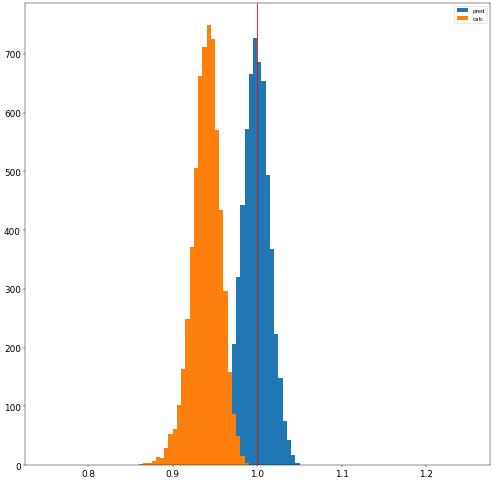

batches for test: 61
test loss: 13.87890121585033
calib weights: Parameter containing:
tensor([1.1459, 1.1618, 1.1880, 1.0818, 1.0667, 1.0922, 1.0237, 1.1080, 1.0383,
        1.0663, 0.9940, 1.0454, 1.0569, 1.0513, 1.0328, 1.1177, 1.0593, 1.1649,
        1.1103, 1.1814, 0.9308, 1.0212, 0.9197, 1.2036, 0.9949, 1.2998, 1.0447,
        2.5989], device='cuda:1', requires_grad=True)
new best test loss: 13.87890121585033
epoch: 163


100%|██████████| 121/121 [00:00<00:00, 424.14it/s]


batches for train: 121
train loss: 13.487043215223581


100%|██████████| 61/61 [00:00<00:00, 147.26it/s]


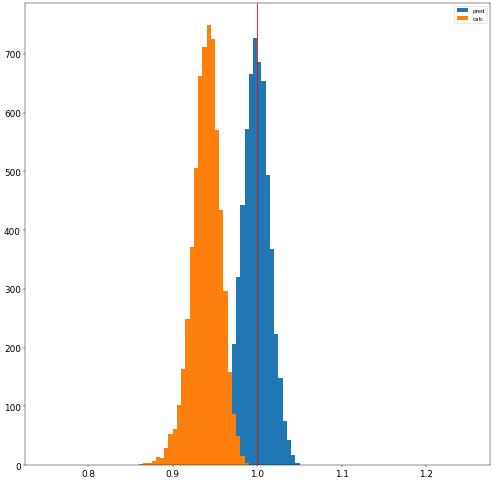

batches for test: 61
test loss: 13.878887379755739
calib weights: Parameter containing:
tensor([1.1459, 1.1617, 1.1880, 1.0818, 1.0667, 1.0922, 1.0237, 1.1081, 1.0383,
        1.0663, 0.9940, 1.0454, 1.0569, 1.0513, 1.0328, 1.1177, 1.0593, 1.1649,
        1.1103, 1.1814, 0.9308, 1.0212, 0.9197, 1.2035, 0.9949, 1.2997, 1.0445,
        2.6004], device='cuda:1', requires_grad=True)
new best test loss: 13.878887379755739
epoch: 164


100%|██████████| 121/121 [00:00<00:00, 528.90it/s]


batches for train: 121
train loss: 13.487047857489468


100%|██████████| 61/61 [00:00<00:00, 155.29it/s]


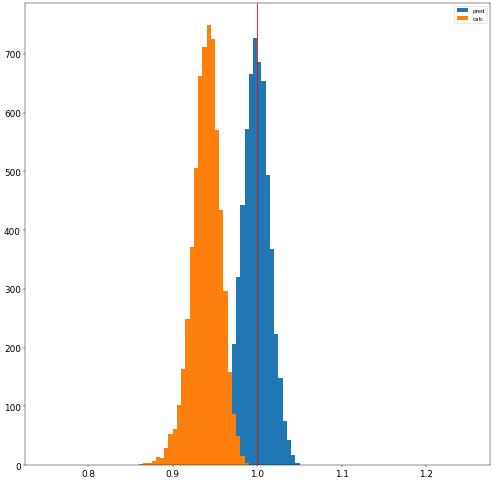

batches for test: 61
test loss: 13.878872558718822
calib weights: Parameter containing:
tensor([1.1459, 1.1617, 1.1880, 1.0818, 1.0667, 1.0922, 1.0237, 1.1081, 1.0383,
        1.0663, 0.9940, 1.0454, 1.0569, 1.0513, 1.0328, 1.1177, 1.0593, 1.1650,
        1.1103, 1.1814, 0.9308, 1.0212, 0.9197, 1.2035, 0.9948, 1.2996, 1.0443,
        2.6018], device='cuda:1', requires_grad=True)
new best test loss: 13.878872558718822
epoch: 165


100%|██████████| 121/121 [00:00<00:00, 524.34it/s]


batches for train: 121
train loss: 13.487051112592713


100%|██████████| 61/61 [00:00<00:00, 153.97it/s]


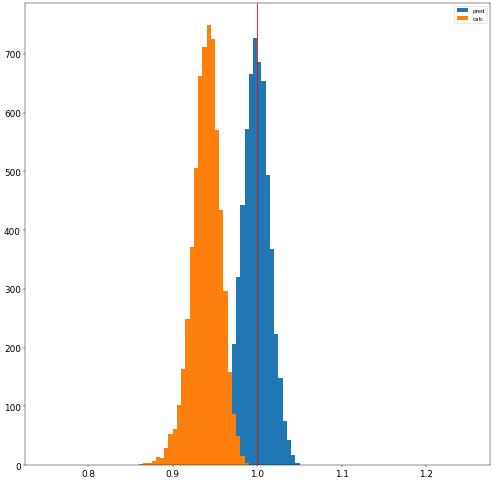

batches for test: 61
test loss: 13.878855627091205
calib weights: Parameter containing:
tensor([1.1459, 1.1617, 1.1881, 1.0818, 1.0667, 1.0923, 1.0236, 1.1081, 1.0383,
        1.0663, 0.9940, 1.0454, 1.0570, 1.0513, 1.0327, 1.1177, 1.0593, 1.1650,
        1.1103, 1.1814, 0.9307, 1.0212, 0.9197, 1.2035, 0.9948, 1.2995, 1.0442,
        2.6032], device='cuda:1', requires_grad=True)
new best test loss: 13.878855627091205
epoch: 166


100%|██████████| 121/121 [00:00<00:00, 493.42it/s]


batches for train: 121
train loss: 13.487055715450571


100%|██████████| 61/61 [00:00<00:00, 97.31it/s] 


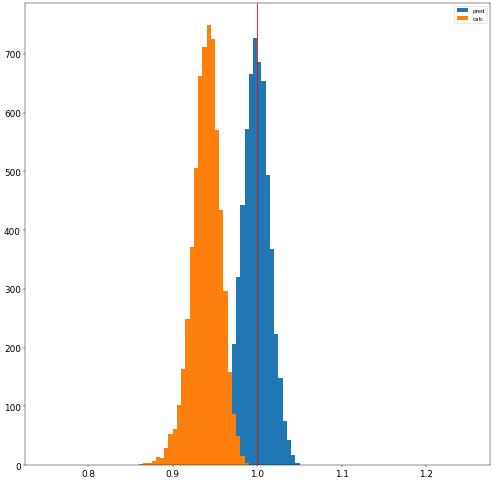

batches for test: 61
test loss: 13.878843088619044
calib weights: Parameter containing:
tensor([1.1459, 1.1617, 1.1881, 1.0818, 1.0667, 1.0923, 1.0236, 1.1082, 1.0383,
        1.0663, 0.9940, 1.0454, 1.0570, 1.0513, 1.0327, 1.1177, 1.0592, 1.1650,
        1.1103, 1.1815, 0.9307, 1.0212, 0.9196, 1.2035, 0.9947, 1.2994, 1.0440,
        2.6045], device='cuda:1', requires_grad=True)
new best test loss: 13.878843088619044
epoch: 167


100%|██████████| 121/121 [00:00<00:00, 532.78it/s]


batches for train: 121
train loss: 13.487060885784054


100%|██████████| 61/61 [00:00<00:00, 156.65it/s]


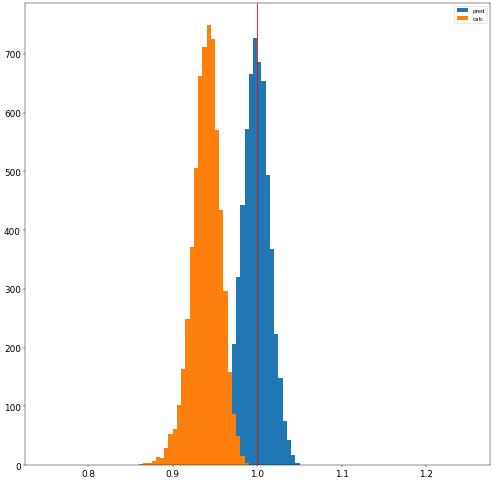

batches for test: 61
test loss: 13.878828783504298
calib weights: Parameter containing:
tensor([1.1459, 1.1616, 1.1881, 1.0818, 1.0667, 1.0923, 1.0236, 1.1082, 1.0382,
        1.0664, 0.9940, 1.0454, 1.0570, 1.0513, 1.0327, 1.1177, 1.0592, 1.1650,
        1.1103, 1.1815, 0.9307, 1.0212, 0.9196, 1.2035, 0.9947, 1.2993, 1.0439,
        2.6058], device='cuda:1', requires_grad=True)
new best test loss: 13.878828783504298
epoch: 168


100%|██████████| 121/121 [00:00<00:00, 517.90it/s]


batches for train: 121
train loss: 13.487064708362926


100%|██████████| 61/61 [00:00<00:00, 154.48it/s]


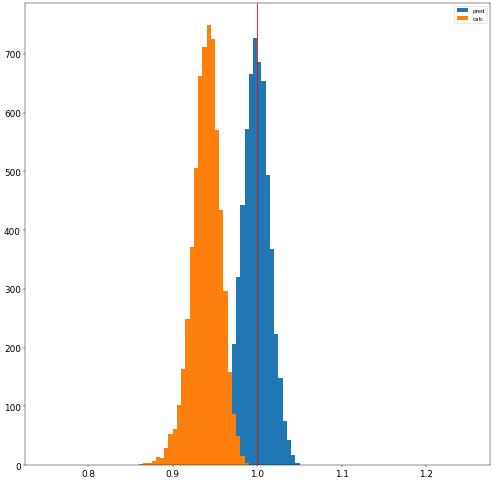

batches for test: 61
test loss: 13.87881597925405
calib weights: Parameter containing:
tensor([1.1458, 1.1616, 1.1882, 1.0817, 1.0667, 1.0923, 1.0235, 1.1082, 1.0382,
        1.0664, 0.9940, 1.0454, 1.0570, 1.0513, 1.0327, 1.1178, 1.0592, 1.1650,
        1.1103, 1.1815, 0.9307, 1.0211, 0.9196, 1.2034, 0.9946, 1.2992, 1.0438,
        2.6071], device='cuda:1', requires_grad=True)
new best test loss: 13.87881597925405
epoch: 169


100%|██████████| 121/121 [00:00<00:00, 532.32it/s]


batches for train: 121
train loss: 13.487069295457571


100%|██████████| 61/61 [00:00<00:00, 153.06it/s]


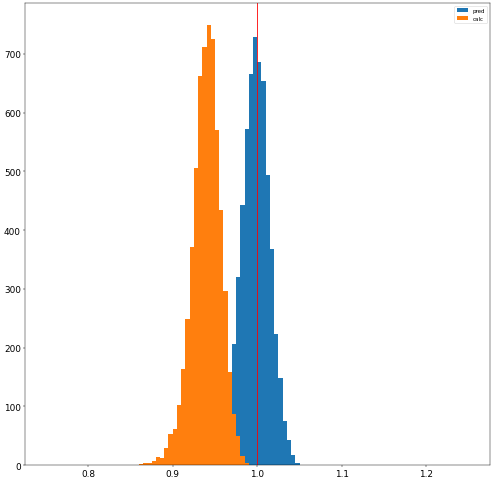

batches for test: 61
test loss: 13.87880139272721
calib weights: Parameter containing:
tensor([1.1458, 1.1616, 1.1882, 1.0817, 1.0666, 1.0923, 1.0235, 1.1082, 1.0382,
        1.0664, 0.9939, 1.0454, 1.0570, 1.0513, 1.0327, 1.1178, 1.0592, 1.1651,
        1.1102, 1.1815, 0.9307, 1.0211, 0.9196, 1.2034, 0.9946, 1.2991, 1.0436,
        2.6084], device='cuda:1', requires_grad=True)
new best test loss: 13.87880139272721


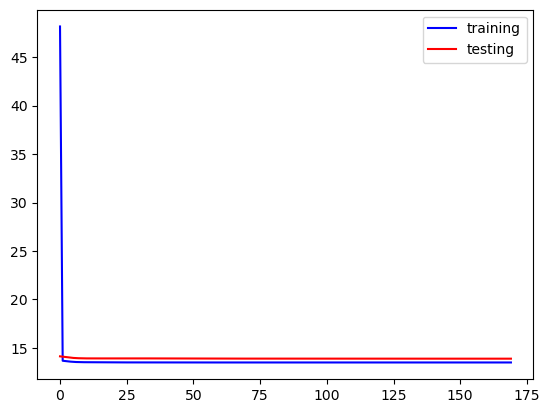

epoch: 170


100%|██████████| 121/121 [00:00<00:00, 524.02it/s]


batches for train: 121
train loss: 13.487074189934848


 26%|██▌       | 16/61 [00:00<00:00, 154.22it/s]

In [ ]:
nepoch=200
#os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch = evaluate(epoch)
    lossv.append(loss_epoch)
    epochs.append(epoch)
    #checkpoint = {
    #'epoch': epoch + 1,
    #'state_dict': model.state_dict(),
    #'optimizer': optimizer.state_dict()
    #}
    
    #checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    #torch.save(checkpoint,
    #               os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        #torch.save(checkpoint,
        #           os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if ((epoch+1)%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()

In [108]:
print(model.weights)

Parameter containing:
tensor([1.1630, 1.1665, 1.1660, 1.0908, 1.0724, 1.0829, 1.0403, 1.0881, 1.0439,
        1.0570, 1.0088, 1.0424, 1.0510, 1.0520, 1.0444, 1.1041, 1.0713, 1.1440,
        1.1108, 1.1569, 0.9614, 1.0356, 0.9445, 1.1924, 1.0347, 1.2896, 1.1103,
        1.9718], device='cuda:1', requires_grad=True)


In [72]:
x = torch.tensor([1, 2, 3])
x.repeat(4, 1)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [93]:
class Model(torch.nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        
        super().__init__()
        # initialize weights with random numbers
        #weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        weights = torch.ones(size=(28,),requires_grad=True,dtype=torch.float)
        # make weights torch parameters
        self.weights = torch.nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        #a, k, b = self.weights
        #return a * torch.exp(-k * X) + b
        batch_size = X.shape[0]
        print(X)
        print(self.weights.repeat(batch_size,1))
        output = X*self.weights.repeat(batch_size,1)
        return torch.sum(output,dim=-1)


model = Model().to(device)
for data in tqdm(trainloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            optimizer.zero_grad()
            result = model(data[0])
            print(data[0])
            print(result)
            for i in data[0].detach():
                print(i)
                print(torch.sum(i.detach().cpu()))
                #calc.append(np.sum(i.detach().cpu())) 
            break


  0%|          | 0/121 [00:00<?, ?it/s]

tensor([[0.0000, 0.3791, 1.2005,  ..., 0.4696, 0.1781, 0.0000],
        [0.3904, 0.6930, 2.1479,  ..., 0.2299, 0.0000, 0.0000],
        [0.2996, 1.5419, 2.8325,  ..., 0.0545, 0.1241, 0.0000],
        ...,
        [0.3669, 1.4619, 3.6918,  ..., 0.0866, 0.1014, 0.0000],
        [0.2174, 0.5748, 1.1254,  ..., 0.2315, 0.3292, 0.3019],
        [0.3496, 1.2412, 4.2877,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:1')
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:1',
       grad_fn=<RepeatBackward0>)
tensor([[0.0000, 0.3791, 1.2005,  ..., 0.4696, 0.1781, 0.0000],
        [0.3904, 0.6930, 2.1479,  ..., 0.2299, 0.0000, 0.0000],
        [0.2996, 1.5419, 2.8325,  ..., 0.0545, 0.1241, 0.0000],
        ...,
        [0.3669, 1.4619, 3.6918,  ..., 0.0866, 0.1014, 0.0000],
    


  0%|          | 0/121 [00:00<?, ?it/s]

tensor(267.8514)
tensor([ 1.1212,  2.3805,  4.3038,  7.7146, 11.8540, 14.0613, 15.7577, 15.1157,
        15.5953, 15.1885, 14.4095, 11.9817, 13.3229,  9.7633,  9.0517,  7.1542,
         7.2099,  3.4611,  3.1073,  1.4445,  1.5160,  1.3617,  0.1021,  0.5752,
         0.2829,  0.3256,  0.0898,  0.0811], device='cuda:1')
tensor(188.3331)
tensor([0.1338, 0.2571, 1.0926, 2.5152, 3.7098, 5.3714, 6.6415, 7.5978, 9.0577,
        9.2808, 7.7563, 8.7944, 7.1721, 4.1820, 4.9654, 3.4721, 2.6164, 1.6752,
        1.1404, 1.1921, 1.0259, 0.1678, 0.3646, 0.0498, 0.1344, 0.0000, 0.0000,
        0.0000], device='cuda:1')
tensor(90.3665)
tensor([ 0.6700,  0.9290,  2.7438,  4.7284,  8.3866,  9.4694, 14.1737, 15.7340,
        23.5359, 23.6849, 25.5470, 23.7592, 24.0240, 18.9955, 18.2023, 13.3890,
        13.2482,  7.0494,  6.9866,  4.7166,  4.0934,  3.2439,  1.7184,  2.3330,
         0.6087,  0.0000,  0.5532,  0.0000], device='cuda:1')
tensor(272.5242)
tensor([0.6132, 2.1885, 3.2286, 4.9799, 6.2748, 7.0648,

In [77]:
x = torch.tensor([[1, 2, 3],[1,2,3]])
x*x
x.shape[0]

2